# VCs Characteristics exploration

## Setup

In [66]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import warnings
from tqdm import tqdm  # For progress bar
from networkx.algorithms.community import greedy_modularity_communities

# warnings.filterwarnings('ignore')

import sys
import os
import re

sys.path.append('./libs') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *
from libs.nestedsness_calculator import *
from libs.curveball import *

plt.style.use('default')
sns.set_palette('husl')

In [67]:
country = "us"
raw_dir = f'../data/raw/{country}'
processed_dir = f'../data/processed/{country}'
figures_dir = f'../reports/figures/{country}'

communities_file = f"{processed_dir}/communities.csv.gz"
community_nestedness_file = f"{processed_dir}/community_nestedness_results.csv.gz"
community_2_ts_nestedness_file = f"{processed_dir}/community_2_ts_nestedness_file.csv.gz"

# Create figures directory if it doesn't exist
os.makedirs(figures_dir, exist_ok=True)

In [68]:
# Create cleaned data on processed_dir. 
# Useful for first time run, then deactivate to save resources
GENERATE_CLEAN_DATA = False  

# Generate kamada kawai layout, default to False, as it is expensive
PLOT_KKL = False

# Calculate communities using greedy_modularity_communities or load from saved parquet files
CALCULATE_COMMUNITIES = False

# Activate 
CALCULATE_COMMUNITIES_NESTEDNESS = False

CALCULATE_COMMUNITY_2_TS_NESTEDNESS = False

In [69]:
if (GENERATE_CLEAN_DATA):
  generate_cleaned_data(raw_dir, processed_dir)

cleaned_data = load_clean_data(processed_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 22,527
Investors: 38,843
Investments: 147,832
Funding rounds: 268,283


## Data ETL

In [70]:
vc_investments = extract_vc_investments(cleaned_data['investments'])
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)

Found 104618 VC investments
Unique companies with VC funding: 16932


In [71]:
overall_stats = {
  'unique_investors': vc_investments['investor_uuid'].nunique(),
  'unique_companies': vc_investments['org_uuid'].nunique(),
  'total_investments': len(vc_investments),
  'total_funding_sum': vc_investments['raised_amount_usd'].sum(),
  'mean_funding': vc_investments['raised_amount_usd'].mean(),
  'median_funding': vc_investments['raised_amount_usd'].median(),
  'min_year': vc_investments['announced_year'].min(),
  'max_year': vc_investments['announced_year'].max()
}
for k, v in overall_stats.items():
  print(f"{k}: {v}")


unique_investors: 11279
unique_companies: 16932
total_investments: 104618
total_funding_sum: 3194348637527.0
mean_funding: 34899852.9157644
median_funding: 10000000.0
min_year: 1990
max_year: 2025


In [72]:
early_stages = set(['angel', 'pre_seed', 'seed', 'series_a'])
late_stages = set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i'])
min_year = 2004
max_year = 2024

early_stage_mask = vc_investments['investment_type'].isin(early_stages)
late_stage_mask = vc_investments['investment_type'].isin(late_stages)

# Create left and right
right_investments = vc_investments[
  (early_stage_mask)
]

left_investments = vc_investments[
  (late_stage_mask)
]

investments_pairs = create_investment_pairs(left_investments, right_investments, 'left', 'right')
investments_pairs['announced_year'] = investments_pairs[['announced_year_left', 'announced_year_right']].max(axis=1)
investments_pairs['year'] = investments_pairs['announced_year']
investments_pairs['total_funding_usd'] = investments_pairs['total_funding_usd_left']
investments_pairs['company_country'] = investments_pairs['company_country_left']
investments_pairs['category'] = investments_pairs['category_left']

Created 169679 investment pairs
Covering 3666 unique statups


In [73]:
investments_pairs_clean = investments_pairs[[
    'investor_name_left',
    'investor_name_right',
    'announced_year_left',
    'announced_year_right', 
    'org_uuid',
    'total_funding_usd',
    'total_funding_usd_left',
    'total_funding_usd_right',
    'year',
    'total_funding_usd',
    'company_country',
    'investor_country_left',
    'investor_country_right',
    'investment_type_left',
    'investment_type_right',
    'category_left',
    'category_right',
]].copy()

investments_pairs_clean = investments_pairs_clean.dropna(subset=['year'])
investments_pairs_clean = investments_pairs_clean[(investments_pairs_clean['year'] >= min_year) & (investments_pairs_clean['year'] <= max_year)]

# Filter out pairs where the VCs might be related (first 5 characters of names match)
investments_pairs_clean = investments_pairs_clean[
    investments_pairs_clean['investor_name_left'].str[:5] != 
    investments_pairs_clean['investor_name_right'].str[:5]
]

## Descriptive Analysis

### Analysis of investments_clean dataframe

In [74]:
# This section provides comprehensive descriptive statistics and visualizations
# for the key variables used throughout the analysis

print("="*80)
print("COMPREHENSIVE DESCRIPTIVE ANALYSIS OF INVESTMENTS_CLEAN DATASET")
print("="*80)

# Basic dataset overview
print(f"\n1. DATASET OVERVIEW")
print("-" * 40)
print(f"Total investment records: {len(investments_clean):,}")
print(f"Time period: {investments_clean['announced_year'].min()} - {investments_clean['announced_year'].max()}")
print(f"Number of unique companies: {investments_clean['org_uuid'].nunique():,}")
print(f"Number of unique investors: {investments_clean['investor_uuid'].nunique():,}")
print(f"Number of unique funding rounds: {investments_clean['funding_round_uuid'].nunique() if 'funding_round_uuid' in investments_clean.columns else 'N/A'}")

# Check for missing values
print(f"\n2. DATA COMPLETENESS")
print("-" * 40)
missing_summary = investments_clean.isnull().sum()
missing_pct = (missing_summary / len(investments_clean)) * 100
print("Missing values by column:")
for col in investments_clean.columns:
    if missing_summary[col] > 0:
        print(f"  {col}: {missing_summary[col]:,} ({missing_pct[col]:.1f}%)")
    else:
        print(f"  {col}: 0 (0.0%)")

# Key columns analysis
key_numeric_cols = ['announced_year', 'total_funding_usd']
key_categorical_cols = ['investment_type', 'investor_country', 'investor_region', 'category']

print(f"\n3. NUMERIC VARIABLES SUMMARY")
print("-" * 40)
for col in key_numeric_cols:
    if col in investments_clean.columns:
        data = investments_clean[col].dropna()
        print(f"\n{col.upper()}:")
        print(f"  Count: {len(data):,}")
        print(f"  Mean: {data.mean():.2f}")
        print(f"  Median: {data.median():.2f}")
        print(f"  Std: {data.std():.2f}")
        print(f"  Min: {data.min():.2f}")
        print(f"  Max: {data.max():.2f}")
        print(f"  25th percentile: {data.quantile(0.25):.2f}")
        print(f"  75th percentile: {data.quantile(0.75):.2f}")

print(f"\n4. CATEGORICAL VARIABLES SUMMARY")
print("-" * 40)
for col in key_categorical_cols:
    if col in investments_clean.columns:
        data = investments_clean[col].dropna()
        value_counts = data.value_counts()
        print(f"\n{col.upper()} (top 10):")
        print(f"  Total unique values: {len(value_counts)}")
        print(f"  Most common values:")
        for i, (value, count) in enumerate(value_counts.head(10).items()):
            pct = (count / len(data)) * 100
            print(f"    {i+1}. {value}: {count:,} ({pct:.1f}%)")

# Syndication analysis summary
print(f"\n5. SYNDICATION CHARACTERISTICS")
print("-" * 40)
if 'syndication' in investments_clean.columns:
    syndicated_count = investments_clean['syndication'].sum()
    total_count = len(investments_clean)
    syndicated_pct = (syndicated_count / total_count) * 100
    print(f"Syndicated investments: {syndicated_count:,} ({syndicated_pct:.1f}%)")
    print(f"Non-syndicated investments: {total_count - syndicated_count:,} ({100-syndicated_pct:.1f}%)")
else:
    print("Syndication indicator not available in current dataset")

COMPREHENSIVE DESCRIPTIVE ANALYSIS OF INVESTMENTS_CLEAN DATASET

1. DATASET OVERVIEW
----------------------------------------
Total investment records: 147,832
Time period: 1990 - 2025
Number of unique companies: 22,527
Number of unique investors: 22,101
Number of unique funding rounds: 61615

2. DATA COMPLETENESS
----------------------------------------
Missing values by column:
  uuid: 0 (0.0%)
  funding_round_uuid: 0 (0.0%)
  investor_uuid: 0 (0.0%)
  is_lead_investor: 82,679 (55.9%)
  investor_name: 0 (0.0%)
  investor_types: 9,804 (6.6%)
  investment_count: 0 (0.0%)
  investor_region: 1,432 (1.0%)
  investor_country: 1,432 (1.0%)
  investor_founded_year: 5,859 (4.0%)
  investor_description: 3 (0.0%)
  num_exits: 17,449 (11.8%)
  investor_logo_url: 4,599 (3.1%)
  investment_type: 0 (0.0%)
  announced_year: 0 (0.0%)
  raised_amount_usd: 19,791 (13.4%)
  org_uuid: 0 (0.0%)
  company_name: 0 (0.0%)
  company_location: 0 (0.0%)
  company_city: 0 (0.0%)
  company_country: 0 (0.0%)
  com

### Syndication Trends

Structure of investments_clean:
Shape: (147832, 35)
Columns: ['uuid', 'funding_round_uuid', 'investor_uuid', 'is_lead_investor', 'investor_name', 'investor_types', 'investment_count', 'investor_region', 'investor_country', 'investor_founded_year', 'investor_description', 'num_exits', 'investor_logo_url', 'investment_type', 'announced_year', 'raised_amount_usd', 'org_uuid', 'company_name', 'company_location', 'company_city', 'company_country', 'company_continent', 'company_ecosystem', 'total_funding_usd', 'fundraising_speed', 'last_funding_year', 'category_groups_list', 'short_description', 'keywords', 'last_valuation', 'first_ipo_year', 'category', 'investor_ecosystem', 'syndication', 'total_funding_by_investor']

First few rows:
                                   uuid                    funding_round_uuid  \
0  f33089df-eb65-6d57-9301-5c927faff511  7a65fabf-64bb-51b4-7e8a-bb20a33aa38f   
1  bac91079-624f-31eb-f270-6aa3ab44775b  35fa83eb-4d9b-7537-f414-1dbdb5a3aa78   
2  c3fb96ae-31ae-

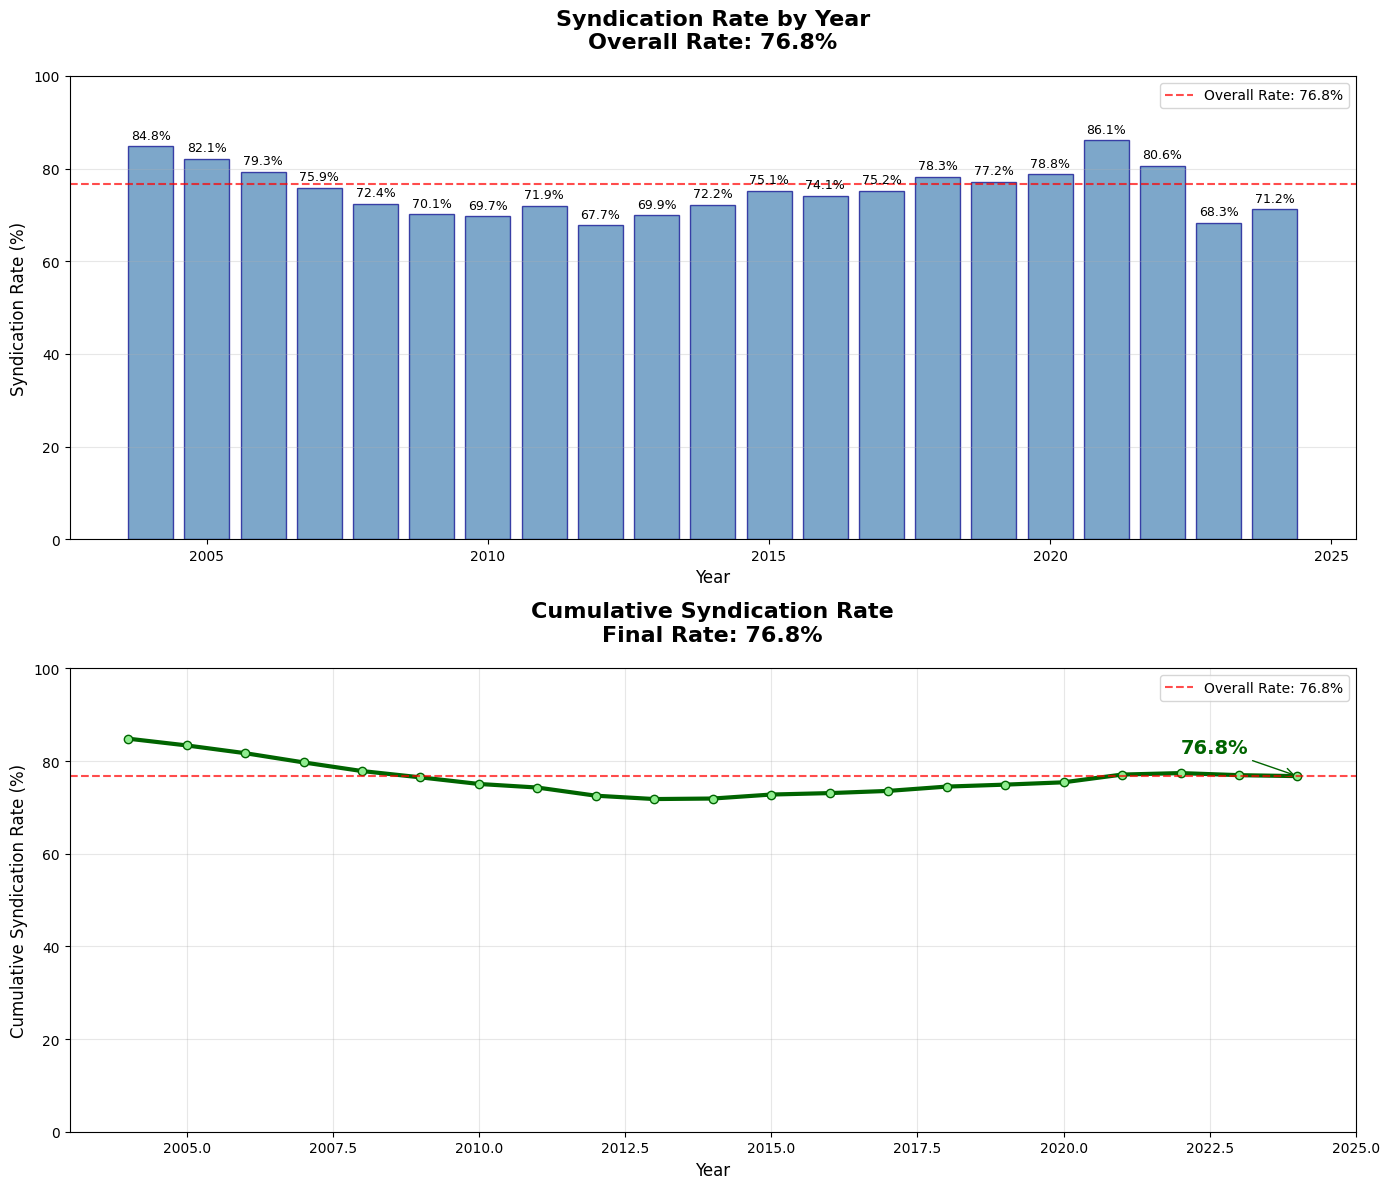


SYNDICATION TRENDS SUMMARY
Analysis period: 2004-2024
Total investments analyzed: 143,438
Syndicated investments: 110,108
Overall syndication rate: 76.8%

Year-by-year breakdown:
  2004: 84.8% (560/660)
  2005: 82.1% (620/755)
  2006: 79.3% (778/981)
  2007: 75.9% (940/1239)
  2008: 72.4% (896/1238)
  2009: 70.1% (733/1045)
  2010: 69.7% (1098/1575)
  2011: 71.9% (1758/2444)
  2012: 67.7% (2466/3641)
  2013: 69.9% (3623/5182)
  2014: 72.2% (5220/7228)
  2015: 75.1% (7129/9487)
  2016: 74.1% (7943/10715)
  2017: 75.2% (9803/13028)
  2018: 78.3% (11413/14579)
  2019: 77.2% (10629/13769)
  2020: 78.8% (10373/13170)
  2021: 86.1% (16133/18741)
  2022: 80.6% (9701/12036)
  2023: 68.3% (4653/6813)
  2024: 71.2% (3639/5112)

Trends:
  Highest year-by-year rate: 86.1% in 2021
  Lowest year-by-year rate: 67.7% in 2012
  Final cumulative rate: 76.8%


In [75]:
# First, let's understand the structure of investments_clean and create syndication indicator
print("Structure of investments_clean:")
print(f"Shape: {investments_clean.shape}")
print(f"Columns: {investments_clean.columns.tolist()}")
print("\nFirst few rows:")
print(investments_clean.head())

# Create syndication indicator - investments are syndicated if there are multiple investors in the same funding round
if 'funding_round_uuid' in investments_clean.columns:
    # Count investors per funding round
    investors_per_round = investments_clean.groupby('funding_round_uuid')['investor_uuid'].nunique().reset_index()
    investors_per_round.columns = ['funding_round_uuid', 'investor_count']
    
    # Merge back to create syndication indicator
    investments_with_syndication = investments_clean.merge(investors_per_round, on='funding_round_uuid', how='left')
    investments_with_syndication['syndication'] = investments_with_syndication['investor_count'] > 1
    
    print(f"\nSyndication analysis:")
    print(f"Total investments: {len(investments_with_syndication):,}")
    syndicated_count = investments_with_syndication['syndication'].sum()
    total_count = len(investments_with_syndication)
    syndicated_pct = (syndicated_count / total_count) * 100
    print(f"Syndicated investments: {syndicated_count:,} ({syndicated_pct:.1f}%)")
    print(f"Non-syndicated investments: {total_count - syndicated_count:,} ({100-syndicated_pct:.1f}%)")
    
else:
    print("No funding_round_uuid column found. Creating alternative syndication indicator...")
    # Alternative: identify syndication by company-year combinations with multiple investors
    # This is less precise but workable if funding_round_uuid is not available
    investments_with_syndication = investments_clean.copy()
    
    # Group by company and year to count unique investors
    company_year_investors = investments_clean.groupby(['org_uuid', 'announced_year'])['investor_uuid'].nunique().reset_index()
    company_year_investors.columns = ['org_uuid', 'announced_year', 'investor_count']
    
    # Merge back to create syndication indicator
    investments_with_syndication = investments_clean.merge(
        company_year_investors, 
        on=['org_uuid', 'announced_year'], 
        how='left'
    )
    investments_with_syndication['syndication'] = investments_with_syndication['investor_count'] > 1
    
    print(f"\nSyndication analysis (by company-year):")
    print(f"Total investments: {len(investments_with_syndication):,}")
    syndicated_count = investments_with_syndication['syndication'].sum()
    total_count = len(investments_with_syndication)
    syndicated_pct = (syndicated_count / total_count) * 100
    print(f"Investments with syndication: {syndicated_count:,} ({syndicated_pct:.1f}%)")
    print(f"Investments without syndication: {total_count - syndicated_count:,} ({100-syndicated_pct:.1f}%)")

# Update the investments_clean variable with syndication information
investments_clean = investments_with_syndication.copy()

# Now create the syndication trends plot
print(f"\nCreating syndication trends visualization...")

# Filter data for the analysis period
analysis_data = investments_clean[
    (investments_clean['announced_year'] >= min_year) & 
    (investments_clean['announced_year'] <= max_year)
].copy()

print(f"Analysis period: {min_year} to {max_year}")
print(f"Investments in analysis period: {len(analysis_data):,}")

# Calculate year-by-year syndication percentages
yearly_stats = analysis_data.groupby('announced_year').agg({
    'syndication': ['sum', 'count']
}).reset_index()

yearly_stats.columns = ['year', 'syndicated_count', 'total_count']
yearly_stats['syndicated_pct'] = (yearly_stats['syndicated_count'] / yearly_stats['total_count']) * 100

# Calculate cumulative syndication percentages
cumulative_syndicated = []
cumulative_total = []
cumulative_pct = []

for year in sorted(yearly_stats['year']):
    cum_data = analysis_data[analysis_data['announced_year'] <= year]
    cum_syndicated = cum_data['syndication'].sum()
    cum_total = len(cum_data)
    cum_pct = (cum_syndicated / cum_total * 100) if cum_total > 0 else 0
    
    cumulative_syndicated.append(cum_syndicated)
    cumulative_total.append(cum_total)
    cumulative_pct.append(cum_pct)

cumulative_df = pd.DataFrame({
    'year': sorted(yearly_stats['year']),
    'cumulative_syndicated': cumulative_syndicated,
    'cumulative_total': cumulative_total,
    'cumulative_pct': cumulative_pct
})

# Calculate overall syndication percentage
overall_syndicated = analysis_data['syndication'].sum()
overall_total = len(analysis_data)
overall_pct = (overall_syndicated / overall_total) * 100

print(f"\nOverall syndication rate: {overall_pct:.1f}% ({overall_syndicated:,}/{overall_total:,})")

# Create the plot
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Year-by-year syndication percentages
ax1 = axes[0]
bars = ax1.bar(yearly_stats['year'], yearly_stats['syndicated_pct'], 
               alpha=0.7, color='steelblue', edgecolor='darkblue', linewidth=1)
ax1.set_title(f'Syndication Rate by Year\nOverall Rate: {overall_pct:.1f}%', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Syndication Rate (%)', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 100)

# Add value labels on bars
for bar, pct in zip(bars, yearly_stats['syndicated_pct']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Cumulative syndication percentages
ax2 = axes[1]
line = ax2.plot(cumulative_df['year'], cumulative_df['cumulative_pct'], 
                marker='o', linewidth=3, markersize=6, color='darkgreen', 
                markerfacecolor='lightgreen', markeredgecolor='darkgreen')
ax2.set_title(f'Cumulative Syndication Rate\nFinal Rate: {overall_pct:.1f}%', 
              fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Cumulative Syndication Rate (%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

# Add final percentage as annotation
ax2.annotate(f'{overall_pct:.1f}%', 
             xy=(cumulative_df['year'].iloc[-1], cumulative_df['cumulative_pct'].iloc[-1]),
             xytext=(cumulative_df['year'].iloc[-1] - 2, cumulative_df['cumulative_pct'].iloc[-1] + 5),
             fontsize=14, fontweight='bold', color='darkgreen',
             arrowprops=dict(arrowstyle='->', color='darkgreen'))

# Add horizontal line for overall percentage
ax1.axhline(y=overall_pct, color='red', linestyle='--', alpha=0.7, 
            label=f'Overall Rate: {overall_pct:.1f}%')
ax1.legend()

ax2.axhline(y=overall_pct, color='red', linestyle='--', alpha=0.7, 
            label=f'Overall Rate: {overall_pct:.1f}%')
ax2.legend()

plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(figures_dir, 'syndication_trends.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\n" + "="*60)
print(f"SYNDICATION TRENDS SUMMARY")
print(f"="*60)
print(f"Analysis period: {min_year}-{max_year}")
print(f"Total investments analyzed: {overall_total:,}")
print(f"Syndicated investments: {overall_syndicated:,}")
print(f"Overall syndication rate: {overall_pct:.1f}%")
print(f"\nYear-by-year breakdown:")
for _, row in yearly_stats.iterrows():
    print(f"  {int(row['year'])}: {row['syndicated_pct']:.1f}% ({int(row['syndicated_count'])}/{int(row['total_count'])})")

print(f"\nTrends:")
print(f"  Highest year-by-year rate: {yearly_stats['syndicated_pct'].max():.1f}% in {yearly_stats.loc[yearly_stats['syndicated_pct'].idxmax(), 'year']}")
print(f"  Lowest year-by-year rate: {yearly_stats['syndicated_pct'].min():.1f}% in {yearly_stats.loc[yearly_stats['syndicated_pct'].idxmin(), 'year']}")
print(f"  Final cumulative rate: {cumulative_df['cumulative_pct'].iloc[-1]:.1f}%")

### Investment Activity Over Time


TEMPORAL ANALYSIS: Investment Activity Evolution


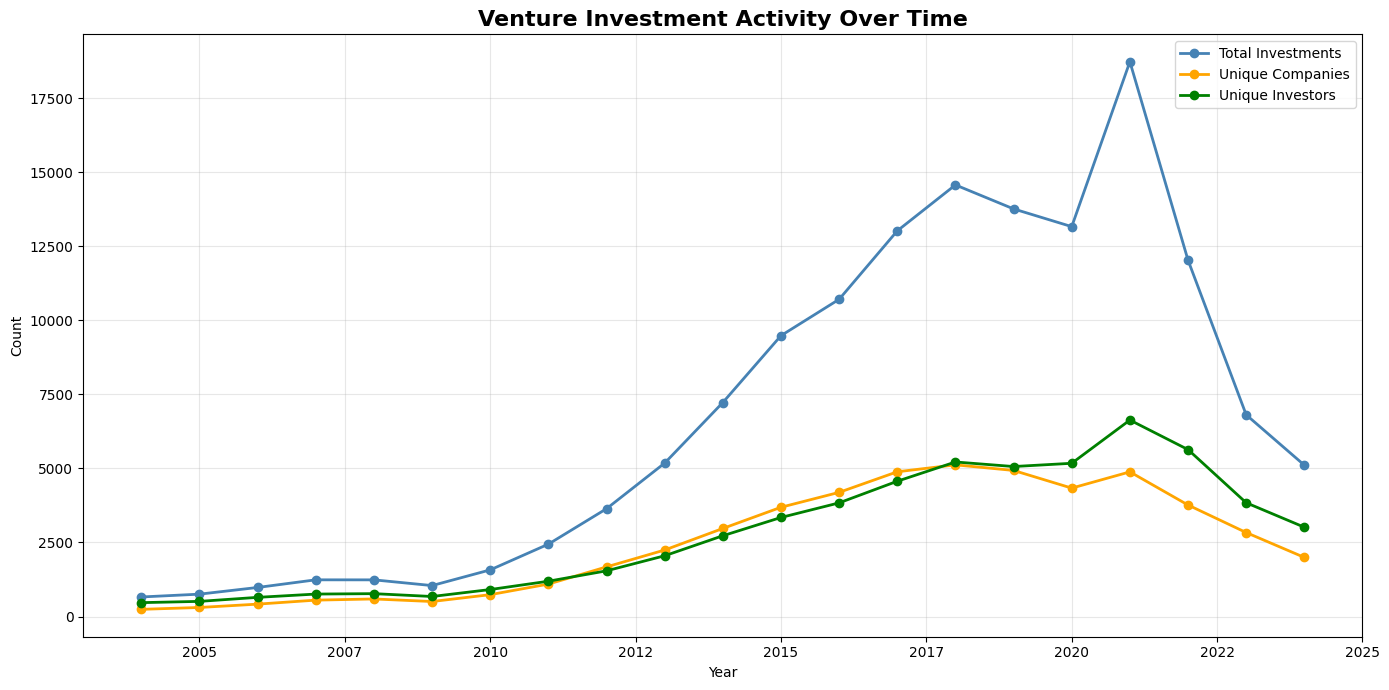

In [76]:
print("\nTEMPORAL ANALYSIS: Investment Activity Evolution")
print("="*60)

# Filter data for analysis period
analysis_data = investments_clean[
      (investments_clean['announced_year'] >= min_year) & 
      (investments_clean['announced_year'] <= max_year)
].copy()

# Yearly investment statistics
yearly_stats = analysis_data.groupby('announced_year').agg(
    unique_investors=('investor_uuid', 'nunique'),
    unique_companies=('org_uuid', 'nunique'),
    total_investments=('org_uuid', 'count'),
    total_funding_sum=('raised_amount_usd', 'sum'),
    mean_funding=('raised_amount_usd', 'mean'),
    median_funding=('raised_amount_usd', 'median')
).round(2)

# Flatten column names
yearly_stats.columns = ['unique_investors', 'unique_companies', 'total_investments', 
                                 'total_funding_sum', 'mean_funding', 'median_funding']
yearly_stats = yearly_stats.reset_index()

# Create comprehensive temporal visualization
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(yearly_stats['announced_year'], yearly_stats['total_investments'], 
  'o-', linewidth=2, markersize=6, color='steelblue', label='Total Investments')
ax.plot(yearly_stats['announced_year'], yearly_stats['unique_companies'], 
  'o-', linewidth=2, markersize=6, color='orange', label='Unique Companies')
ax.plot(yearly_stats['announced_year'], yearly_stats['unique_investors'], 
  'o-', linewidth=2, markersize=6, color='green', label='Unique Investors')
ax.set_title('Venture Investment Activity Over Time', fontweight='bold', fontsize=16)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'vc_investment_activity_over_time.png'), 
      dpi=300, bbox_inches='tight')
plt.show()


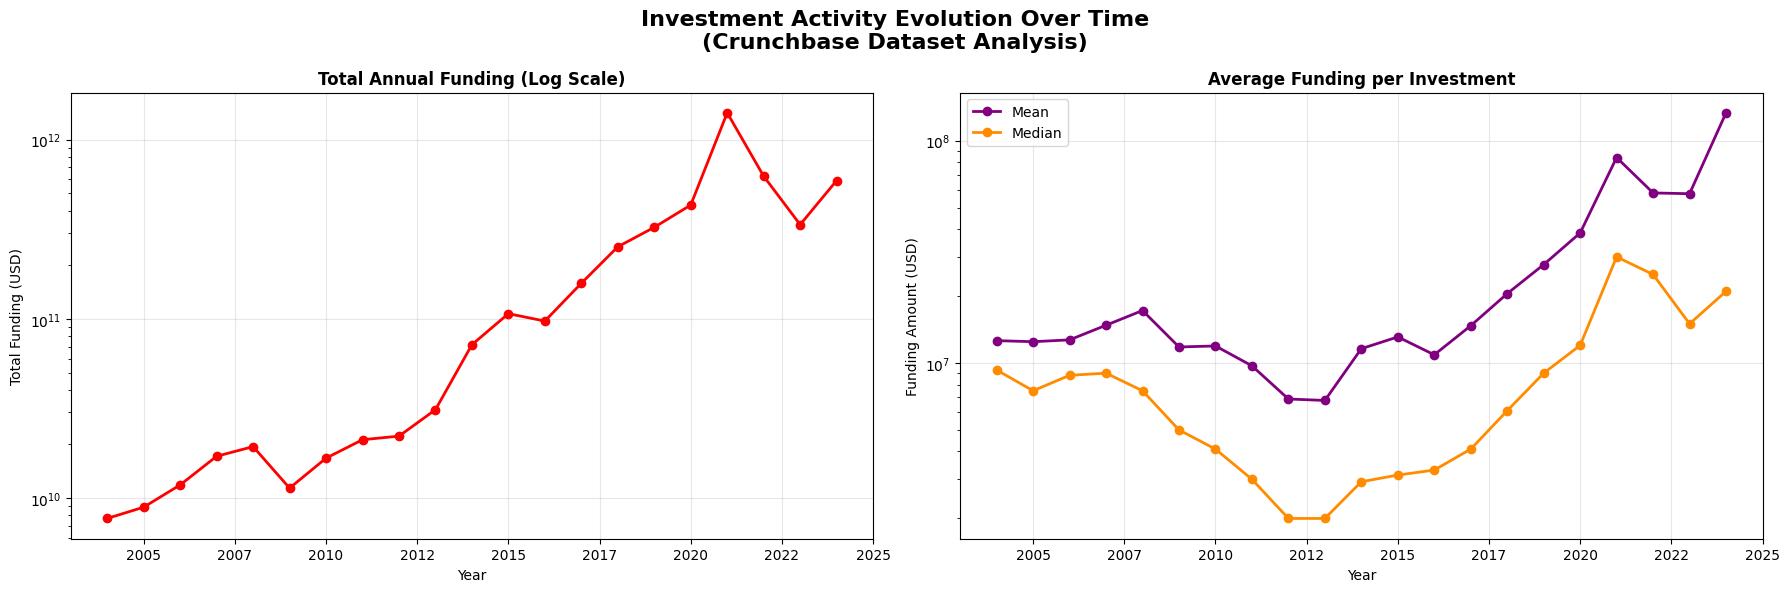


Temporal Analysis Summary (2004-2024):
Peak investment year: 2021 (18,741 investments)
Peak funding year: 2021 ($1409792455771)
Most active year (investors): 2021 (6,636 investors)

Growth from 2004 to 2024:
Total investments: 674.5%
Unique investors: 544.4%


In [77]:
# Create comprehensive temporal visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Investment Activity Evolution Over Time\n(Crunchbase Dataset Analysis)', 
                   fontsize=16, fontweight='bold', y=0.98)

# Plot 3: Funding amounts over time (log scale)
ax3 = axes[0]
ax3.plot(yearly_stats['announced_year'], yearly_stats['total_funding_sum'], 
             'o-', linewidth=2, markersize=6, color='red', label='Total Funding')
ax3.set_title('Total Annual Funding (Log Scale)', fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Total Funding (USD)')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)
# Format x-axis to show integers only
ax3.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

# Plot 4: Average funding per investment
ax4 = axes[1]
ax4.plot(yearly_stats['announced_year'], yearly_stats['mean_funding'], 
             'o-', linewidth=2, markersize=6, color='purple', label='Mean')
ax4.plot(yearly_stats['announced_year'], yearly_stats['median_funding'], 
             'o-', linewidth=2, markersize=6, color='darkorange', label='Median')
ax4.set_title('Average Funding per Investment', fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Funding Amount (USD)')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)
# Format x-axis to show integers only
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'investment_funding_temporal_evolution.png'), 
                  dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\nTemporal Analysis Summary ({min_year}-{max_year}):")
print(f"Peak investment year: {yearly_stats.loc[yearly_stats['total_investments'].idxmax(), 'announced_year']} "
        f"({yearly_stats['total_investments'].max():,} investments)")
print(f"Peak funding year: {yearly_stats.loc[yearly_stats['total_funding_sum'].idxmax(), 'announced_year']} "
        f"(${yearly_stats['total_funding_sum'].max():.0f})")
print(f"Most active year (investors): {yearly_stats.loc[yearly_stats['unique_investors'].idxmax(), 'announced_year']} "
        f"({yearly_stats['unique_investors'].max():,} investors)")

# Growth rates
total_investments_growth = ((yearly_stats['total_investments'].iloc[-1] / yearly_stats['total_investments'].iloc[0]) - 1) * 100
unique_investors_growth = ((yearly_stats['unique_investors'].iloc[-1] / yearly_stats['unique_investors'].iloc[0]) - 1) * 100
print(f"\nGrowth from {min_year} to {max_year}:")
print(f"Total investments: {total_investments_growth:.1f}%")
print(f"Unique investors: {unique_investors_growth:.1f}%")

### Investment Stage


INVESTMENT STAGE DISTRIBUTION ANALYSIS
Investment Type Distribution:
------------------------------
  seed           : 33,419 ( 23.3%)
  series_a       : 28,703 ( 20.0%)
  series_b       : 20,808 ( 14.5%)
  series_unknown : 14,328 ( 10.0%)
  series_c       : 12,160 (  8.5%)
  grant          :  9,434 (  6.6%)
  series_d       :  6,305 (  4.4%)
  pre_seed       :  3,714 (  2.6%)
  convertible_note:  3,498 (  2.4%)
  series_e       :  2,719 (  1.9%)
  private_equity :  2,293 (  1.6%)
  non_equity_assistance:  1,454 (  1.0%)
  angel          :  1,142 (  0.8%)
  series_f       :  1,126 (  0.8%)
  corporate_round:    616 (  0.4%)
  secondary_market:    480 (  0.3%)
  series_g       :    347 (  0.2%)
  undisclosed    :    293 (  0.2%)
  equity_crowdfunding:    204 (  0.1%)
  initial_coin_offering:    193 (  0.1%)
  series_h       :    124 (  0.1%)
  series_i       :     46 (  0.0%)
  series_j       :     20 (  0.0%)
  product_crowdfunding:      9 (  0.0%)
  post_ipo_equity:      2 (  0.0%)
 

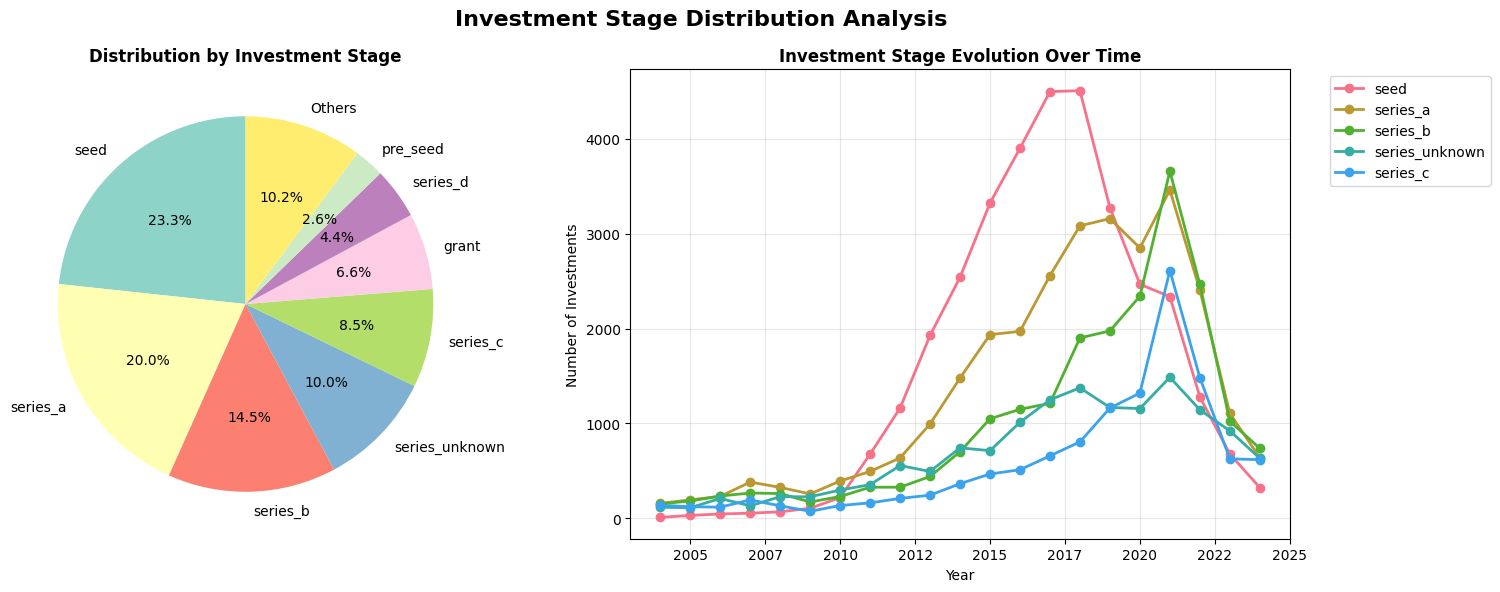


Early vs Late Stage Classification:
-----------------------------------
  Early-stage (angel to series_a): 66,978 ( 46.7%)
  Late-stage (series_b+):          43,635 ( 30.4%)
  Other stages:                    32,825 ( 22.9%)


In [78]:
print("\nINVESTMENT STAGE DISTRIBUTION ANALYSIS")
print("="*60)

# Investment type distribution
if 'investment_type' in analysis_data.columns:
    stage_counts = analysis_data['investment_type'].value_counts()
    stage_pct = (stage_counts / len(analysis_data)) * 100
    
    print("Investment Type Distribution:")
    print("-" * 30)
    for stage, count in stage_counts.items():
        pct = (count / len(analysis_data)) * 100
        print(f"  {stage:<15}: {count:>6,} ({pct:>5.1f}%)")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Investment Stage Distribution Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Investment type distribution (pie chart)
    ax1 = axes[0]
    top_stages = stage_counts.head(8)  # Top 8 stages
    other_count = stage_counts.iloc[8:].sum() if len(stage_counts) > 8 else 0
    
    if other_count > 0:
        plot_data = pd.concat([top_stages, pd.Series({'Others': other_count})])
    else:
        plot_data = top_stages
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
    wedges, texts, autotexts = ax1.pie(plot_data.values, labels=plot_data.index, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
    ax1.set_title('Distribution by Investment Stage', fontweight='bold')
    
    # Plot 2: Stage evolution over time
    ax2 = axes[1]
    stage_evolution_sum_inv = analysis_data.groupby(['announced_year', 'investment_type']).size().unstack(fill_value=0)
    
    # Select top 5 most common stages for clarity
    top_5_stages = stage_counts.head(5).index
    stage_evolution_sum_inv_top = stage_evolution_sum_inv[top_5_stages]
    
    for stage in top_5_stages:
        ax2.plot(stage_evolution_sum_inv_top.index, stage_evolution_sum_inv_top[stage], 
                marker='o', linewidth=2, label=stage)
    
    ax2.set_title('Investment Stage Evolution Over Time', fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Investments')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'investment_stage_distribution.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Early vs Late stage classification
    early_stages_set = {'angel', 'pre_seed', 'seed', 'series_a'}
    late_stages_set = {'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i'}
    
    early_count = analysis_data[analysis_data['investment_type'].isin(early_stages_set)].shape[0]
    late_count = analysis_data[analysis_data['investment_type'].isin(late_stages_set)].shape[0]
    other_count = len(analysis_data) - early_count - late_count
    
    early_pct = (early_count / len(analysis_data)) * 100
    late_pct = (late_count / len(analysis_data)) * 100
    other_pct = (other_count / len(analysis_data)) * 100
    
    print(f"\nEarly vs Late Stage Classification:")
    print("-" * 35)
    print(f"  Early-stage (angel to series_a): {early_count:>6,} ({early_pct:>5.1f}%)")
    print(f"  Late-stage (series_b+):          {late_count:>6,} ({late_pct:>5.1f}%)")
    print(f"  Other stages:                    {other_count:>6,} ({other_pct:>5.1f}%)")
    
else:
    print("Investment type data not available in dataset")

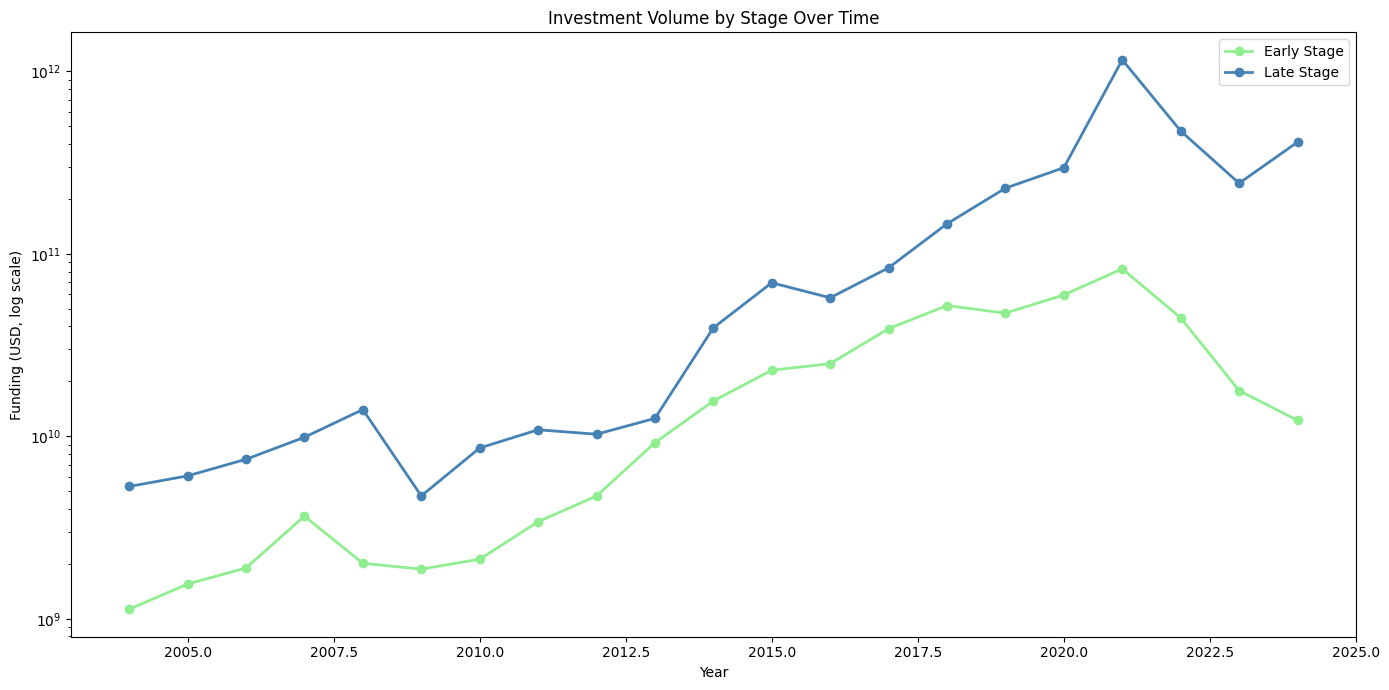

Years: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Early stage funding per year:
announced_year
2004    1.127283e+09
2005    1.549240e+09
2006    1.896952e+09
2007    3.650950e+09
2008    2.012929e+09
2009    1.871129e+09
2010    2.119001e+09
2011    3.402714e+09
2012    4.707979e+09
2013    9.223905e+09
2014    1.561811e+10
2015    2.302760e+10
2016    2.500914e+10
2017    3.886735e+10
2018    5.205573e+10
2019    4.730622e+10
2020    5.953172e+10
2021    8.273965e+10
2022    4.458275e+10
2023    1.779207e+10
2024    1.223629e+10
dtype: float64
Late stage funding per year:
announced_year
2004    5.309557e+09
2005    6.067180e+09
2006    7.482923e+09
2007    9.876643e+09
2008    1.400841e+10
2009    4.711558e+09
2010    8.628031e+09
2011    1.085590e+10
2012    1.026272e+10
2013    1.253259e+10
2014    3.929473e+10
2015    6.941731e+10
2016    5.743686e+10
2017    8.380857e+10
2018    1.461116e+11
2019  

In [79]:
stage_evolution_sum_funding = analysis_data.groupby(['announced_year', 'investment_type'])['raised_amount_usd'].sum().unstack(fill_value=0)

# Define early and late stage sets
early_stages_set = {'angel', 'pre_seed', 'seed', 'series_a'}
late_stages_set = {'series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i', 'series_j'}

years = stage_evolution_sum_funding.index.tolist()
early_stage_cols = list(early_stages_set.intersection(stage_evolution_sum_funding.columns))
late_stage_cols = list(late_stages_set.intersection(stage_evolution_sum_funding.columns))

early_counts = stage_evolution_sum_funding[early_stage_cols].sum(axis=1)
late_counts = stage_evolution_sum_funding[late_stage_cols].sum(axis=1)

plt.figure(figsize=(14, 7))
plt.plot(years, early_counts, marker='o', linewidth=2, color='lightgreen', label='Early Stage')
plt.plot(years, late_counts, marker='o', linewidth=2, color='steelblue', label='Late Stage')
plt.xlabel('Year')
plt.ylabel('Funding (USD, log scale)')
plt.title('Investment Volume by Stage Over Time')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'investment_stage_curves_log.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Years:", years)
print("Early stage funding per year:")
print(early_counts)
print("Late stage funding per year:")
print(late_counts)


### Geographic distribution


GEOGRAPHIC DISTRIBUTION ANALYSIS
Top 15 Countries by Investment Count:
----------------------------------------
   1. United States            : 118,859 ( 82.9%)
   2. United Kingdom           :  3,210 (  2.2%)
   3. China                    :  1,855 (  1.3%)
   4. Canada                   :  1,743 (  1.2%)
   5. Israel                   :  1,463 (  1.0%)
   6. Japan                    :  1,424 (  1.0%)
   7. Germany                  :  1,111 (  0.8%)
   8. Singapore                :  1,021 (  0.7%)
   9. France                   :  1,019 (  0.7%)
  10. Korea, Republic of       :    991 (  0.7%)
  11. India                    :    871 (  0.6%)
  12. Australia                :    727 (  0.5%)
  13. Switzerland              :    701 (  0.5%)
  14. Hong Kong                :    693 (  0.5%)
  15. Brazil                   :    681 (  0.5%)

US vs International Breakdown:
-----------------------------------
  United States: 118,859 ( 82.9%)
  International: 24,579 ( 17.1%)


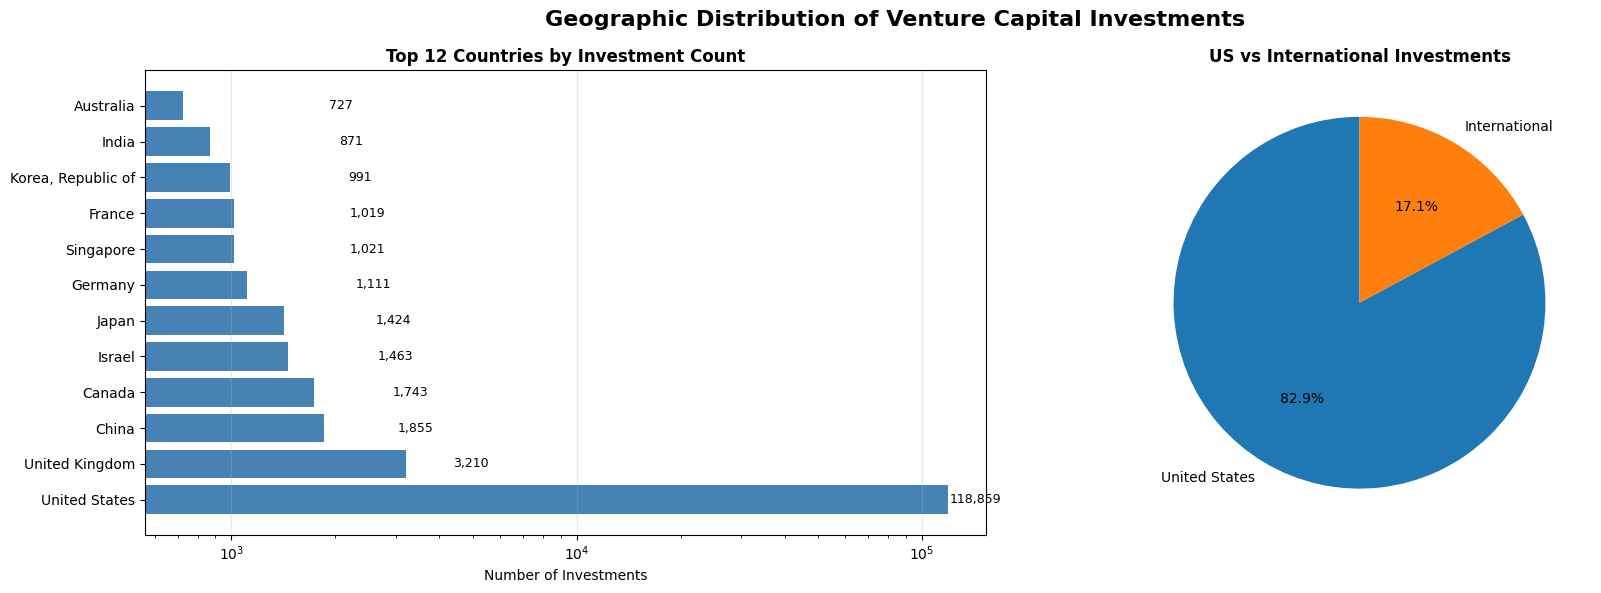

In [80]:
print("\nGEOGRAPHIC DISTRIBUTION ANALYSIS")
print("="*60)

# Country analysis
if 'investor_country' in analysis_data.columns:
    country_counts = analysis_data['investor_country'].value_counts()
    
    print("Top 15 Countries by Investment Count:")
    print("-" * 40)
    for i, (country, count) in enumerate(country_counts.head(15).items()):
        pct = (count / len(analysis_data)) * 100
        print(f"  {i+1:2d}. {country:<25}: {count:>6,} ({pct:>5.1f}%)")
    
    # US vs International analysis
    us_count = analysis_data[analysis_data['investor_country'] == 'United States'].shape[0]
    intl_count = len(analysis_data) - us_count
    us_pct = (us_count / len(analysis_data)) * 100
    intl_pct = (intl_count / len(analysis_data)) * 100
    
    print(f"\nUS vs International Breakdown:")
    print("-" * 35)
    print(f"  United States: {us_count:>6,} ({us_pct:>5.1f}%)")
    print(f"  International: {intl_count:>6,} ({intl_pct:>5.1f}%)")

# Create geographic visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Geographic Distribution of Venture Capital Investments', 
             fontsize=16, fontweight='bold', y=0.98)

# Plot 1: Top countries
ax1 = axes[0]
top_countries = country_counts.head(12)
bars1 = ax1.barh(range(len(top_countries)), top_countries.values, color='steelblue')
ax1.set_yticks(range(len(top_countries)))
ax1.set_yticklabels([country[:20] + '...' if len(country) > 20 else country 
                     for country in top_countries.index])
ax1.set_xlabel('Number of Investments')
ax1.set_title('Top 12 Countries by Investment Count', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.set_xscale('log')

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.01*max(top_countries.values), bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontsize=9)

# Plot 2: US vs International pie chart
ax2 = axes[1]
us_intl_data = pd.Series({'United States': us_count, 'International': intl_count})
colors = ['#1f77b4', '#ff7f0e']
wedges, texts, autotexts = ax2.pie(us_intl_data.values, labels=us_intl_data.index, 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('US vs International Investments', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'geographic_distribution_country_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.show()


Top 10 US Regions by Investment Count:
---------------------------------------------
   1. California               : 48,033 ( 40.4%)
   2. New York                 : 18,755 ( 15.8%)
   3. Massachusetts            :  7,946 (  6.7%)
   4. Virginia                 :  4,114 (  3.5%)
   5. Illinois                 :  3,919 (  3.3%)
   6. Texas                    :  3,734 (  3.1%)
   7. Colorado                 :  3,065 (  2.6%)
   8. Pennsylvania             :  2,593 (  2.2%)
   9. District of Columbia     :  2,500 (  2.1%)
  10. Florida                  :  2,113 (  1.8%)

California vs Other US Regions:
-----------------------------------
  California:     48,033 ( 40.4%)
  Other US:       70,826 ( 59.6%)


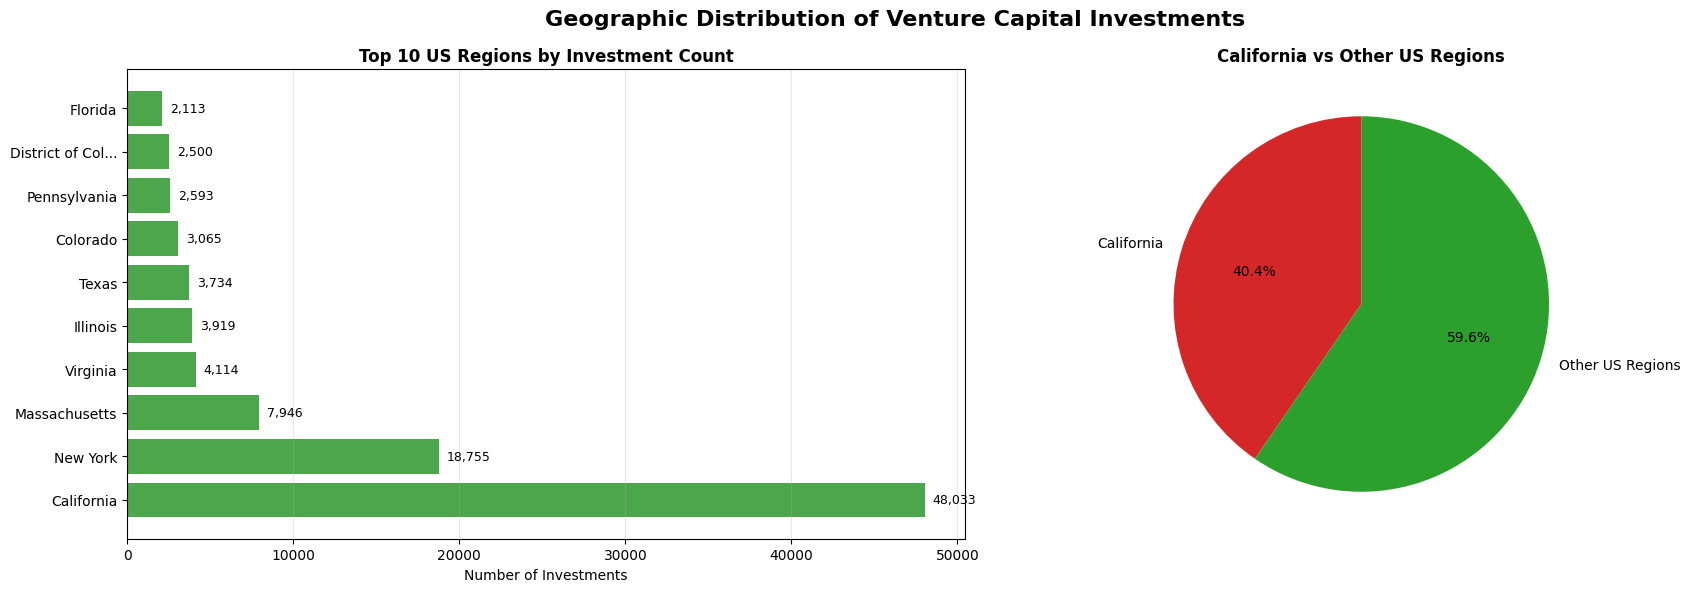

In [81]:
# Region analysis (for US investors)
us_data = analysis_data[analysis_data['investor_country'] == 'United States']
if len(us_data) > 0:
    region_counts = us_data['investor_region'].value_counts()
    
    print(f"\nTop 10 US Regions by Investment Count:")
    print("-" * 45)
    for i, (region, count) in enumerate(region_counts.head(10).items()):
        pct = (count / len(us_data)) * 100
        print(f"  {i+1:2d}. {region:<25}: {count:>6,} ({pct:>5.1f}%)")
    
    # California analysis
    ca_count = us_data[us_data['investor_region'] == 'California'].shape[0]
    other_us_count = len(us_data) - ca_count
    ca_pct = (ca_count / len(us_data)) * 100
    other_us_pct = (other_us_count / len(us_data)) * 100
    
    print(f"\nCalifornia vs Other US Regions:")
    print("-" * 35)
    print(f"  California:     {ca_count:>6,} ({ca_pct:>5.1f}%)")
    print(f"  Other US:       {other_us_count:>6,} ({other_us_pct:>5.1f}%)")

# Create geographic visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Geographic Distribution of Venture Capital Investments', 
             fontsize=16, fontweight='bold', y=0.98)

# Plot 3: Top US regions
ax3 = axes[0]
top_regions = region_counts.head(10)
bars3 = ax3.barh(range(len(top_regions)), top_regions.values, color='green', alpha=0.7)
ax3.set_yticks(range(len(top_regions)))
ax3.set_yticklabels([region[:15] + '...' if len(region) > 15 else region 
                        for region in top_regions.index])
ax3.set_xlabel('Number of Investments')
ax3.set_title('Top 10 US Regions by Investment Count', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width + 0.01*max(top_regions.values), bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontsize=9)

# Plot 4: California vs Other US pie chart
ax4 = axes[1]
ca_other_data = pd.Series({'California': ca_count, 'Other US Regions': other_us_count})
colors = ['#d62728', '#2ca02c']
wedges, texts, autotexts = ax4.pie(ca_other_data.values, labels=ca_other_data.index, 
                                    autopct='%1.1f%%', colors=colors, startangle=90)
ax4.set_title('California vs Other US Regions', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'geographic_distribution_region_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

### Funding Characteristics

Not used in the Thesis


FUNDING CHARACTERISTICS ANALYSIS
Funding Amount Statistics:
------------------------------
  Count: 143,438
  Mean: $158,401,951
  Median: $33,364,004
  Std: $721,767,451
  Min: $20,000
  Max: $17,900,120,000
  25th percentile: $7,079,100
  75th percentile: $115,300,000
  95th percentile: $563,903,667
  99th percentile: $1,441,100,000

Funding Statistics by Investment Stage:
--------------------------------------------------
Stage           Count    Mean         Median       Std         
--------------------------------------------------
series_j        20       $13,251,668,769 $13,997,000,000 $1,529,387,416
series_i        46       $11,358,908,718 $13,997,000,000 $3,528,621,091
series_h        124      $5,001,369,304 $995,408,718 $5,753,888,749
series_g        347      $2,194,327,076 $802,081,804 $3,857,361,261
secondary_market 480      $1,796,662,566 $536,620,000 $3,886,630,994
series_f        1126     $790,321,282 $472,550,000 $1,538,729,710
series_e        2719     $588,709,456 $3

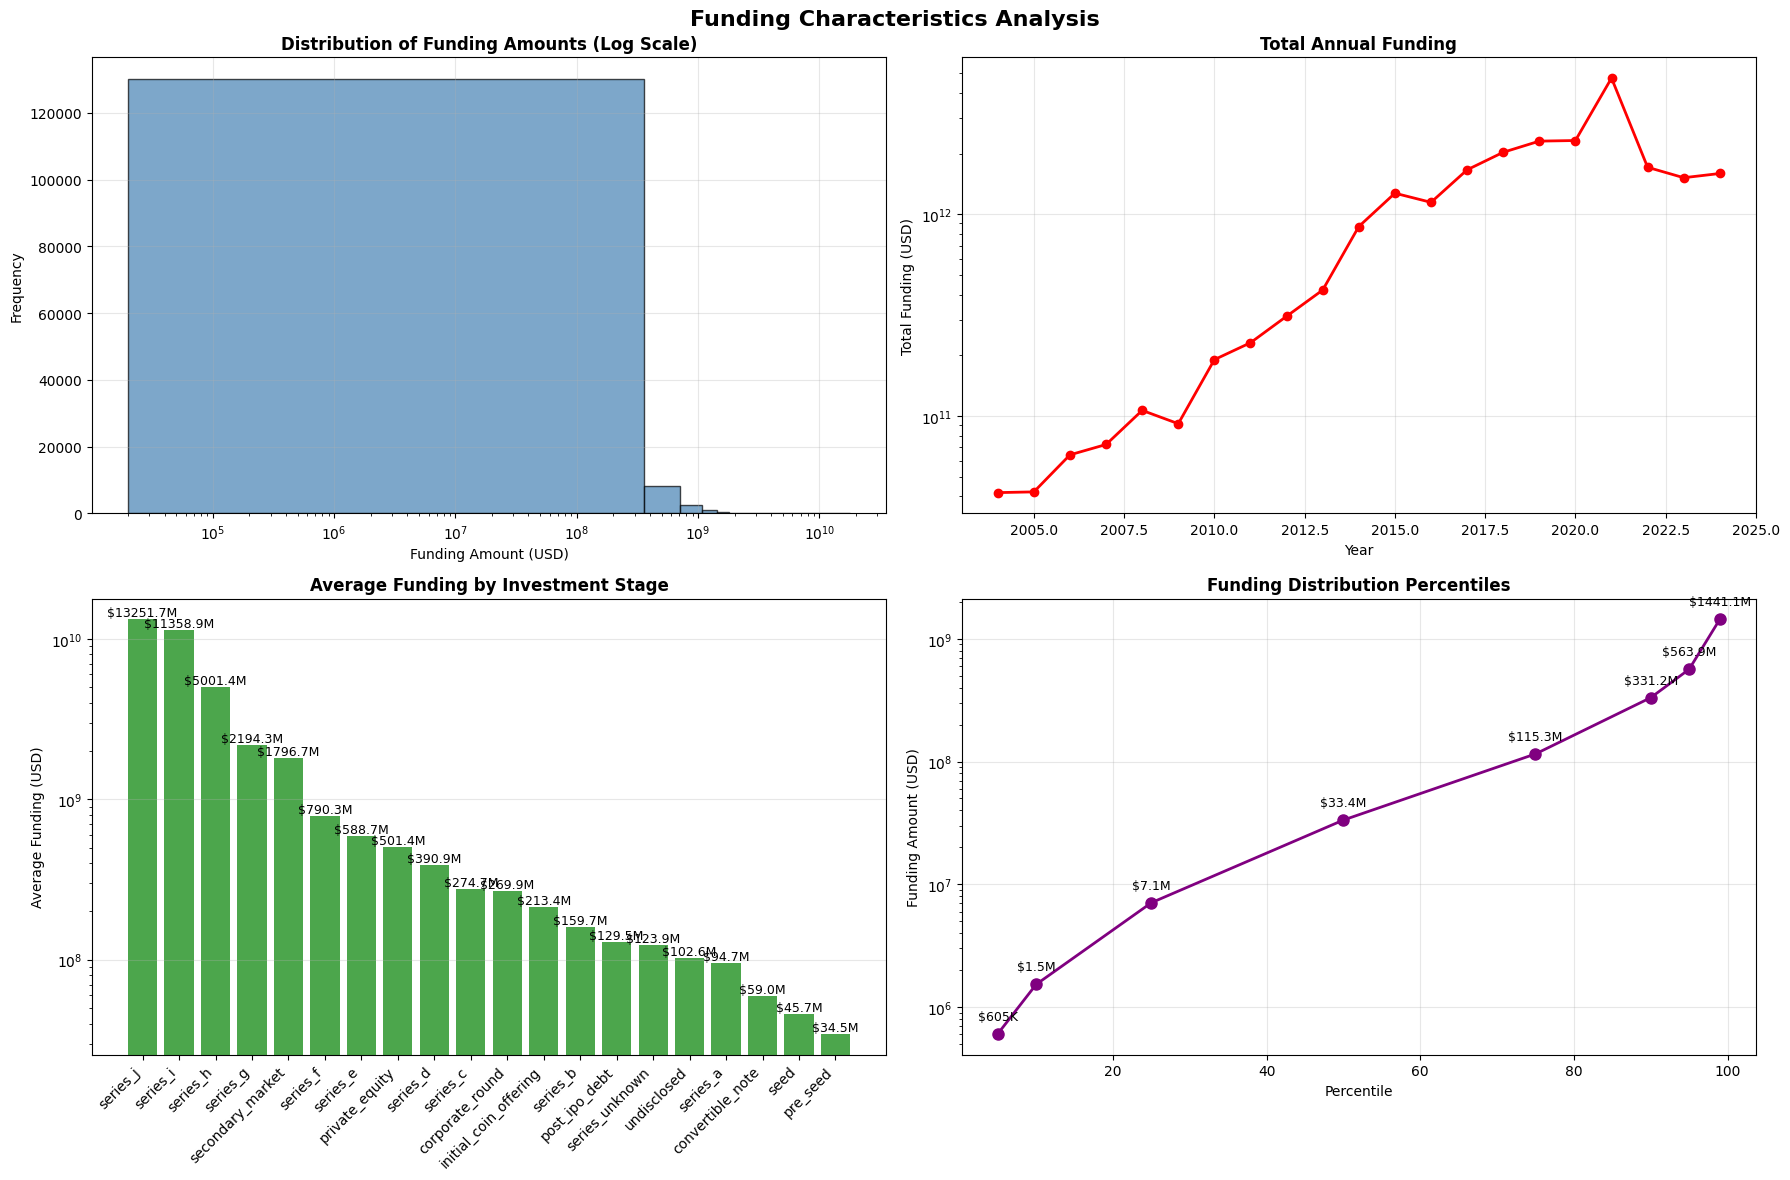


Funding Concentration Analysis:
-----------------------------------
  Top 1% of rounds: 32.9% of total funding
  Top 5% of rounds: 54.4% of total funding
  Top 10% of rounds: 67.9% of total funding


In [82]:
print("\nFUNDING CHARACTERISTICS ANALYSIS")
print("="*60)

# Funding amount analysis
if 'total_funding_usd' in analysis_data.columns:
    funding_data = analysis_data['total_funding_usd'].dropna()
    
    print("Funding Amount Statistics:")
    print("-" * 30)
    print(f"  Count: {len(funding_data):,}")
    print(f"  Mean: ${funding_data.mean():,.0f}")
    print(f"  Median: ${funding_data.median():,.0f}")
    print(f"  Std: ${funding_data.std():,.0f}")
    print(f"  Min: ${funding_data.min():,.0f}")
    print(f"  Max: ${funding_data.max():,.0f}")
    print(f"  25th percentile: ${funding_data.quantile(0.25):,.0f}")
    print(f"  75th percentile: ${funding_data.quantile(0.75):,.0f}")
    print(f"  95th percentile: ${funding_data.quantile(0.95):,.0f}")
    print(f"  99th percentile: ${funding_data.quantile(0.99):,.0f}")
    
    # Funding by investment stage
    if 'investment_type' in analysis_data.columns:
        funding_by_stage = analysis_data.groupby('investment_type')['total_funding_usd'].agg([
            'count', 'mean', 'median', 'std'
        ]).round(0)
        funding_by_stage.columns = ['Count', 'Mean', 'Median', 'Std']
        funding_by_stage = funding_by_stage.sort_values('Mean', ascending=False)
        
        print(f"\nFunding Statistics by Investment Stage:")
        print("-" * 50)
        print(f"{'Stage':<15} {'Count':<8} {'Mean':<12} {'Median':<12} {'Std':<12}")
        print("-" * 50)
        for stage, row in funding_by_stage.head(10).iterrows():
            print(f"{stage:<15} {row['Count']:<8.0f} ${row['Mean']:<11,.0f} ${row['Median']:<11,.0f} ${row['Std']:<11,.0f}")

# Create funding analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Funding Characteristics Analysis', fontsize=16, fontweight='bold', y=0.98)

# Plot 1: Funding distribution (log scale histogram)
ax1 = axes[0, 0]
funding_clean = funding_data[funding_data > 0]  # Remove zeros for log scale
ax1.hist(funding_clean, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Funding Amount (USD)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Funding Amounts (Log Scale)', fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

# Plot 2: Funding by year
ax2 = axes[0, 1]
yearly_funding = analysis_data.groupby('announced_year')['total_funding_usd'].agg(['sum', 'mean', 'count'])
ax2.plot(yearly_funding.index, yearly_funding['sum'], 'o-', linewidth=2, markersize=6, color='red')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total Funding (USD)')
ax2.set_title('Total Annual Funding', fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Plot 3: Average funding by investment stage
if 'investment_type' in analysis_data.columns:
    ax3 = axes[1, 0]
    stage_avg_funding = funding_by_stage.head(20)  # Top 8 stages
    bars3 = ax3.bar(range(len(stage_avg_funding)), stage_avg_funding['Mean'], 
                    color='green', alpha=0.7)
    ax3.set_xticks(range(len(stage_avg_funding)))
    ax3.set_xticklabels(stage_avg_funding.index, rotation=45, ha='right')
    ax3.set_ylabel('Average Funding (USD)')
    ax3.set_title('Average Funding by Investment Stage', fontweight='bold')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'${height/1e6:.1f}M', ha='center', va='bottom', fontsize=9)

# Plot 4: Funding distribution percentiles
ax4 = axes[1, 1]
percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = [funding_data.quantile(p/100) for p in percentiles]
ax4.plot(percentiles, percentile_values, 'o-', linewidth=2, markersize=8, color='purple')
ax4.set_xlabel('Percentile')
ax4.set_ylabel('Funding Amount (USD)')
ax4.set_title('Funding Distribution Percentiles', fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# Add value labels
for i, (p, v) in enumerate(zip(percentiles, percentile_values)):
    if v > 1e6:
        label = f'${v/1e6:.1f}M'
    elif v > 1e3:
        label = f'${v/1e3:.0f}K'
    else:
        label = f'${v:.0f}'
    ax4.annotate(label, (p, v), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'funding_characteristics_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Funding concentration analysis
if len(funding_data) > 0:
    total_funding = funding_data.sum()
    top_1_pct_threshold = funding_data.quantile(0.99)
    top_5_pct_threshold = funding_data.quantile(0.95)
    top_10_pct_threshold = funding_data.quantile(0.90)
    
    top_1_pct_funding = funding_data[funding_data >= top_1_pct_threshold].sum()
    top_5_pct_funding = funding_data[funding_data >= top_5_pct_threshold].sum()
    top_10_pct_funding = funding_data[funding_data >= top_10_pct_threshold].sum()
    
    print(f"\nFunding Concentration Analysis:")
    print("-" * 35)
    print(f"  Top 1% of rounds: {(top_1_pct_funding/total_funding)*100:.1f}% of total funding")
    print(f"  Top 5% of rounds: {(top_5_pct_funding/total_funding)*100:.1f}% of total funding")
    print(f"  Top 10% of rounds: {(top_10_pct_funding/total_funding)*100:.1f}% of total funding")

### Sector


SECTORAL/INDUSTRY DISTRIBUTION ANALYSIS
Top 20 Industry Categories by Investment Count:
--------------------------------------------------
   1. Health Care                   : 21,574 ( 15.0%)
   2. Financial Services            : 11,409 (  8.0%)
   3. Data and Analytics            :  8,626 (  6.0%)
   4. Biotechnology                 :  7,047 (  4.9%)
   5. Hardware                      :  6,158 (  4.3%)
   6. Information Technology        :  5,879 (  4.1%)
   7. Artificial Intelligence       :  5,729 (  4.0%)
   8. Food and Beverage             :  4,727 (  3.3%)
   9. Transportation                :  4,648 (  3.2%)
  10. Science and Engineering       :  4,499 (  3.1%)
  11. Education                     :  4,461 (  3.1%)
  12. Commerce and Shopping         :  4,307 (  3.0%)
  13. Manufacturing                 :  4,188 (  2.9%)
  14. Privacy and Security          :  4,029 (  2.8%)
  15. Energy                        :  3,962 (  2.8%)
  16. Internet Services             :  3,778 (  2.

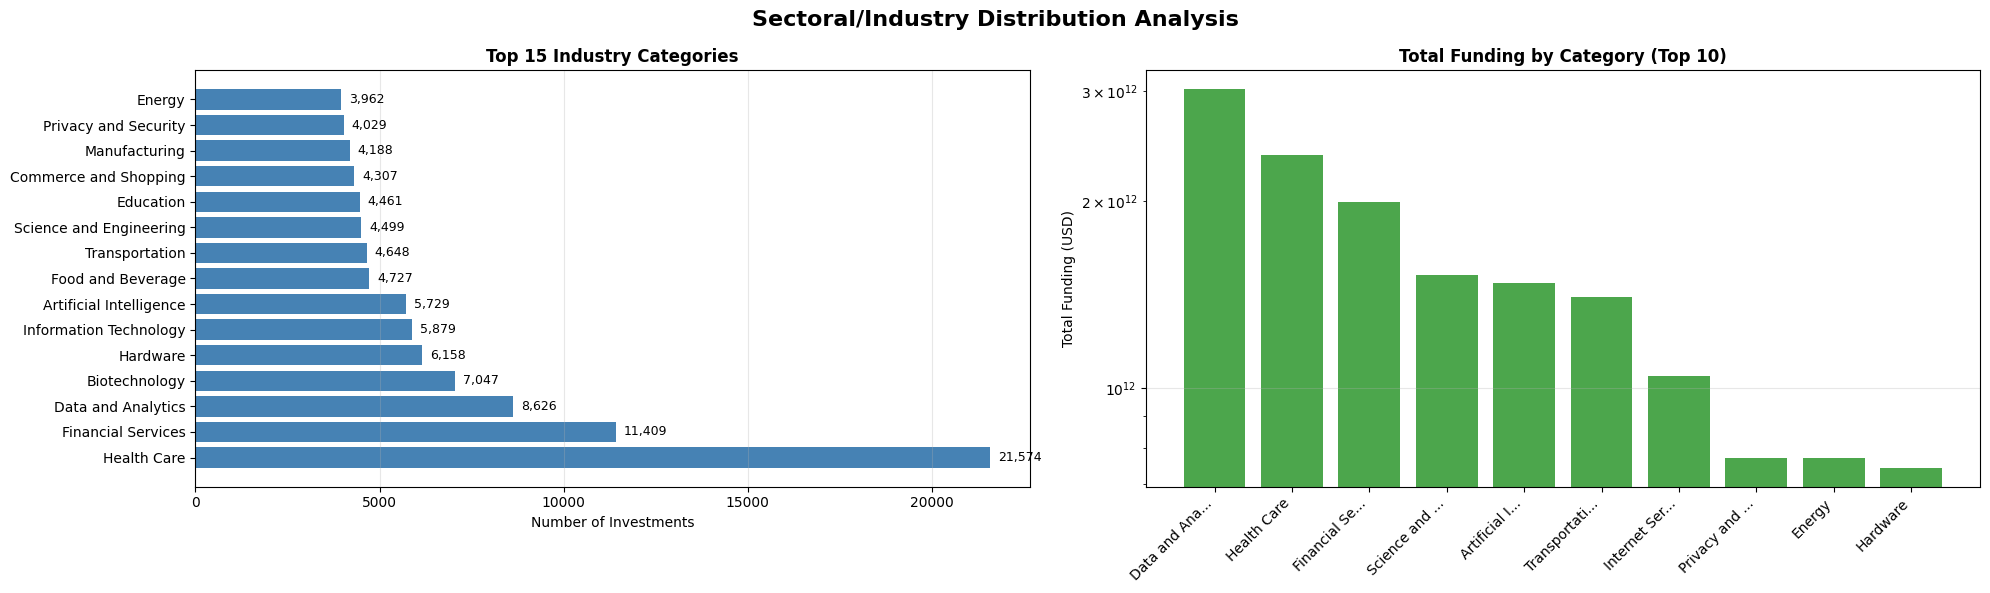


Technology vs Non-Technology Classification:
---------------------------------------------
  Technology-related: 33,998 ( 23.7%)
  Non-technology:     109,440 ( 76.3%)
  Technology categories identified: 6


In [83]:
print("\nSECTORAL/INDUSTRY DISTRIBUTION ANALYSIS")
print("="*60)

# Industry category analysis
if 'category' in analysis_data.columns:
    category_counts = analysis_data['category'].value_counts()
    
    print("Top 20 Industry Categories by Investment Count:")
    print("-" * 50)
    for i, (category, count) in enumerate(category_counts.head(20).items()):
        pct = (count / len(analysis_data)) * 100
        print(f"  {i+1:2d}. {category:<30}: {count:>6,} ({pct:>5.1f}%)")
    
    # Industry concentration analysis
    top_5_categories = category_counts.head(5)
    top_10_categories = category_counts.head(10)
    top_20_categories = category_counts.head(20)
    
    top_5_pct = (top_5_categories.sum() / len(analysis_data)) * 100
    top_10_pct = (top_10_categories.sum() / len(analysis_data)) * 100
    top_20_pct = (top_20_categories.sum() / len(analysis_data)) * 100
    
    print(f"\nIndustry Concentration:")
    print("-" * 25)
    print(f"  Top 5 categories:  {top_5_pct:.1f}% of total investments")
    print(f"  Top 10 categories: {top_10_pct:.1f}% of total investments")
    print(f"  Top 20 categories: {top_20_pct:.1f}% of total investments")
    print(f"  Total unique categories: {len(category_counts)}")

# Create sectoral visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Sectoral/Industry Distribution Analysis', fontsize=16, fontweight='bold', y=0.98)

# Plot 1: Top categories bar chart
ax1 = axes[0]
top_categories_plot = category_counts.head(15)
bars1 = ax1.barh(range(len(top_categories_plot)), top_categories_plot.values, color='steelblue')
ax1.set_yticks(range(len(top_categories_plot)))
ax1.set_yticklabels([cat[:25] + '...' if len(cat) > 25 else cat 
                     for cat in top_categories_plot.index])
ax1.set_xlabel('Number of Investments')
ax1.set_title('Top 15 Industry Categories', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.01*max(top_categories_plot.values), bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontsize=9)

# Plot 4: Funding by category (top 10)
if 'total_funding_usd' in analysis_data.columns:
    ax4 = axes[1]
    funding_by_category = analysis_data.groupby('category')['total_funding_usd'].agg(['sum', 'mean', 'count'])
    funding_by_category = funding_by_category.sort_values('sum', ascending=False).head(10)
    
    bars4 = ax4.bar(range(len(funding_by_category)), funding_by_category['sum'], 
                    color='green', alpha=0.7)
    ax4.set_xticks(range(len(funding_by_category)))
    ax4.set_xticklabels([cat[:12] + '...' if len(cat) > 12 else cat 
                         for cat in funding_by_category.index], 
                        rotation=45, ha='right')
    ax4.set_ylabel('Total Funding (USD)')
    ax4.set_title('Total Funding by Category (Top 10)', fontweight='bold')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'sectoral_industry_analysis_bars.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Technology vs non-technology classification
if 'category' in analysis_data.columns:
    tech_keywords = ['software', 'technology', 'internet', 'mobile', 'artificial intelligence', 
                     'information technology', 'fintech', 'biotech', 'healthtech', 'edtech', 
                     'proptech', 'blockchain', 'cryptocurrency', 'cyber', 'data']
    
    tech_categories = []
    for cat in category_counts.index:
        if any(keyword.lower() in cat.lower() for keyword in tech_keywords):
            tech_categories.append(cat)
    
    tech_count = analysis_data[analysis_data['category'].isin(tech_categories)].shape[0]
    non_tech_count = len(analysis_data) - tech_count
    tech_pct = (tech_count / len(analysis_data)) * 100
    non_tech_pct = (non_tech_count / len(analysis_data)) * 100
    
    print(f"\nTechnology vs Non-Technology Classification:")
    print("-" * 45)
    print(f"  Technology-related: {tech_count:>6,} ({tech_pct:>5.1f}%)")
    print(f"  Non-technology:     {non_tech_count:>6,} ({non_tech_pct:>5.1f}%)")
    print(f"  Technology categories identified: {len(tech_categories)}")

else:
    print("Category data not available in dataset")

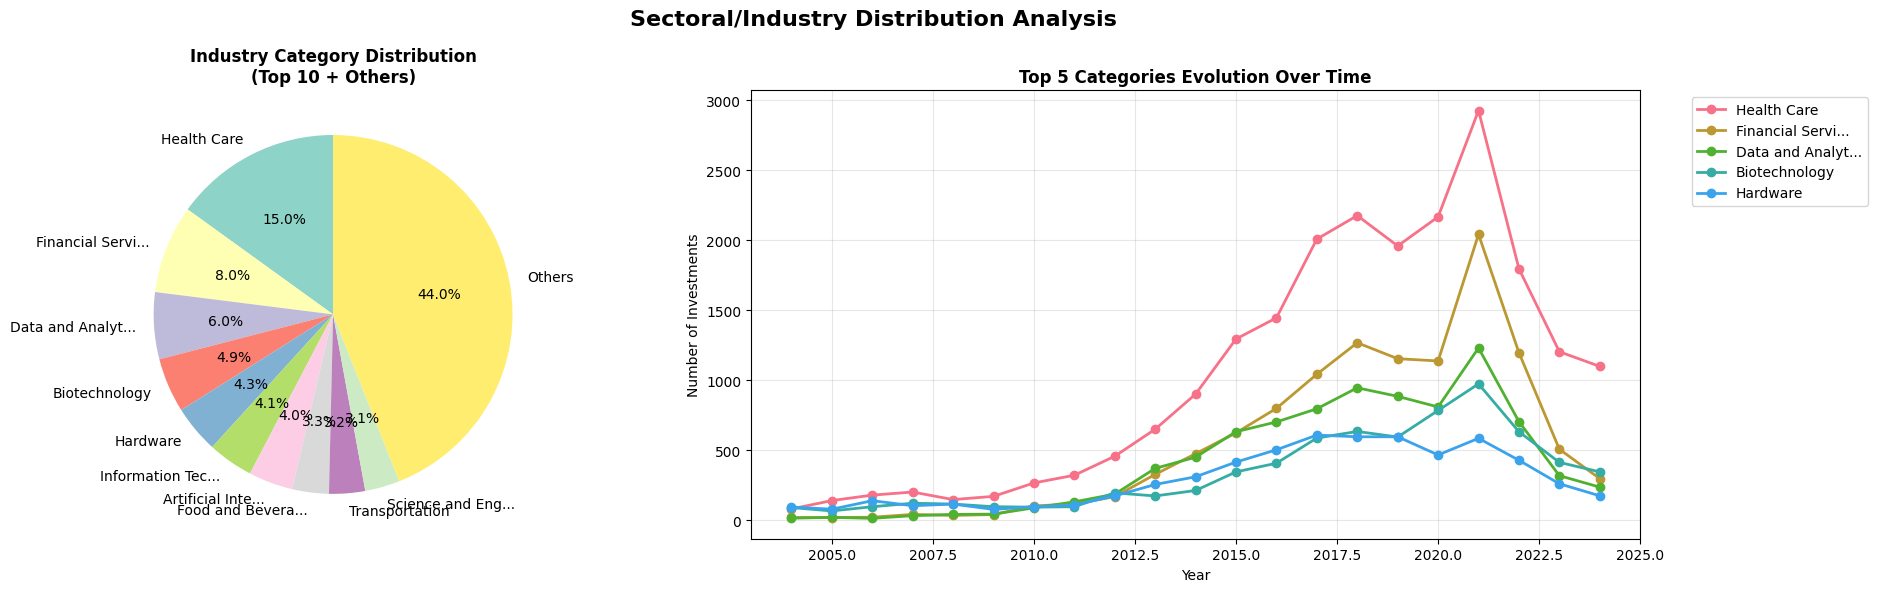

In [84]:
# Create sectoral visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Sectoral/Industry Distribution Analysis', fontsize=16, fontweight='bold', y=0.98)

# Plot 2: Category distribution pie chart (top 10 + others)
ax2 = axes[0]
top_10_categories = category_counts.head(10)
other_count = category_counts.iloc[10:].sum()
plot_data = pd.concat([top_10_categories, pd.Series({'Others': other_count})])

colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
wedges, texts, autotexts = ax2.pie(plot_data.values, 
                                   labels=[label[:15] + '...' if len(label) > 15 else label 
                                          for label in plot_data.index],
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Industry Category Distribution\n(Top 10 + Others)', fontweight='bold')

# Plot 3: Category evolution over time (top 5 categories)
if 'announced_year' in analysis_data.columns:
    ax3 = axes[1]
    top_5_cats = category_counts.head(5).index
    category_evolution = analysis_data.groupby(['announced_year', 'category']).size().unstack(fill_value=0)
    
    for cat in top_5_cats:
        if cat in category_evolution.columns:
            ax3.plot(category_evolution.index, category_evolution[cat], 
                    marker='o', linewidth=2, label=cat[:15] + '...' if len(cat) > 15 else cat)
    
    ax3.set_title('Top 5 Categories Evolution Over Time', fontweight='bold')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Number of Investments')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'sectoral_industry_analysis_trends.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

### Investor activity and network characteristics

Not used in the Thesis


INVESTOR ACTIVITY AND NETWORK CHARACTERISTICS
Investor Activity Statistics:
------------------------------
  Total unique investors: 21,165
  Mean investments per investor: 6.8
  Median investments per investor: 2.0
  Max investments by single investor: 2,798
  Investors with only 1 investment: 10,020 (47.3%)

Top 20 Most Active Investors:
--------------------------------------------------
Rank Investor UUID                            Investments  Companies 
--------------------------------------------------
1    e66e2167-b9fc-08d4-d3bc-e222202583c...   2798         1772      
2    3718597a-dd39-6661-3630-09cdd43bcac...   1400         876       
3    73633ee4-ea65-2967-6c5d-9b5fec7d2d5...   1042         660       
4    56e40f50-97c7-2a77-255d-1d97d5f3064...   626          446       
5    e8487396-f60c-25f1-2bb5-bfcb4e0f4b6...   574          402       
6    39041e62-6b24-ae8d-1347-4cea947e832...   546          191       
7    3bfb69a8-61b6-ec30-1512-73bd1ca35bc...   526          493   

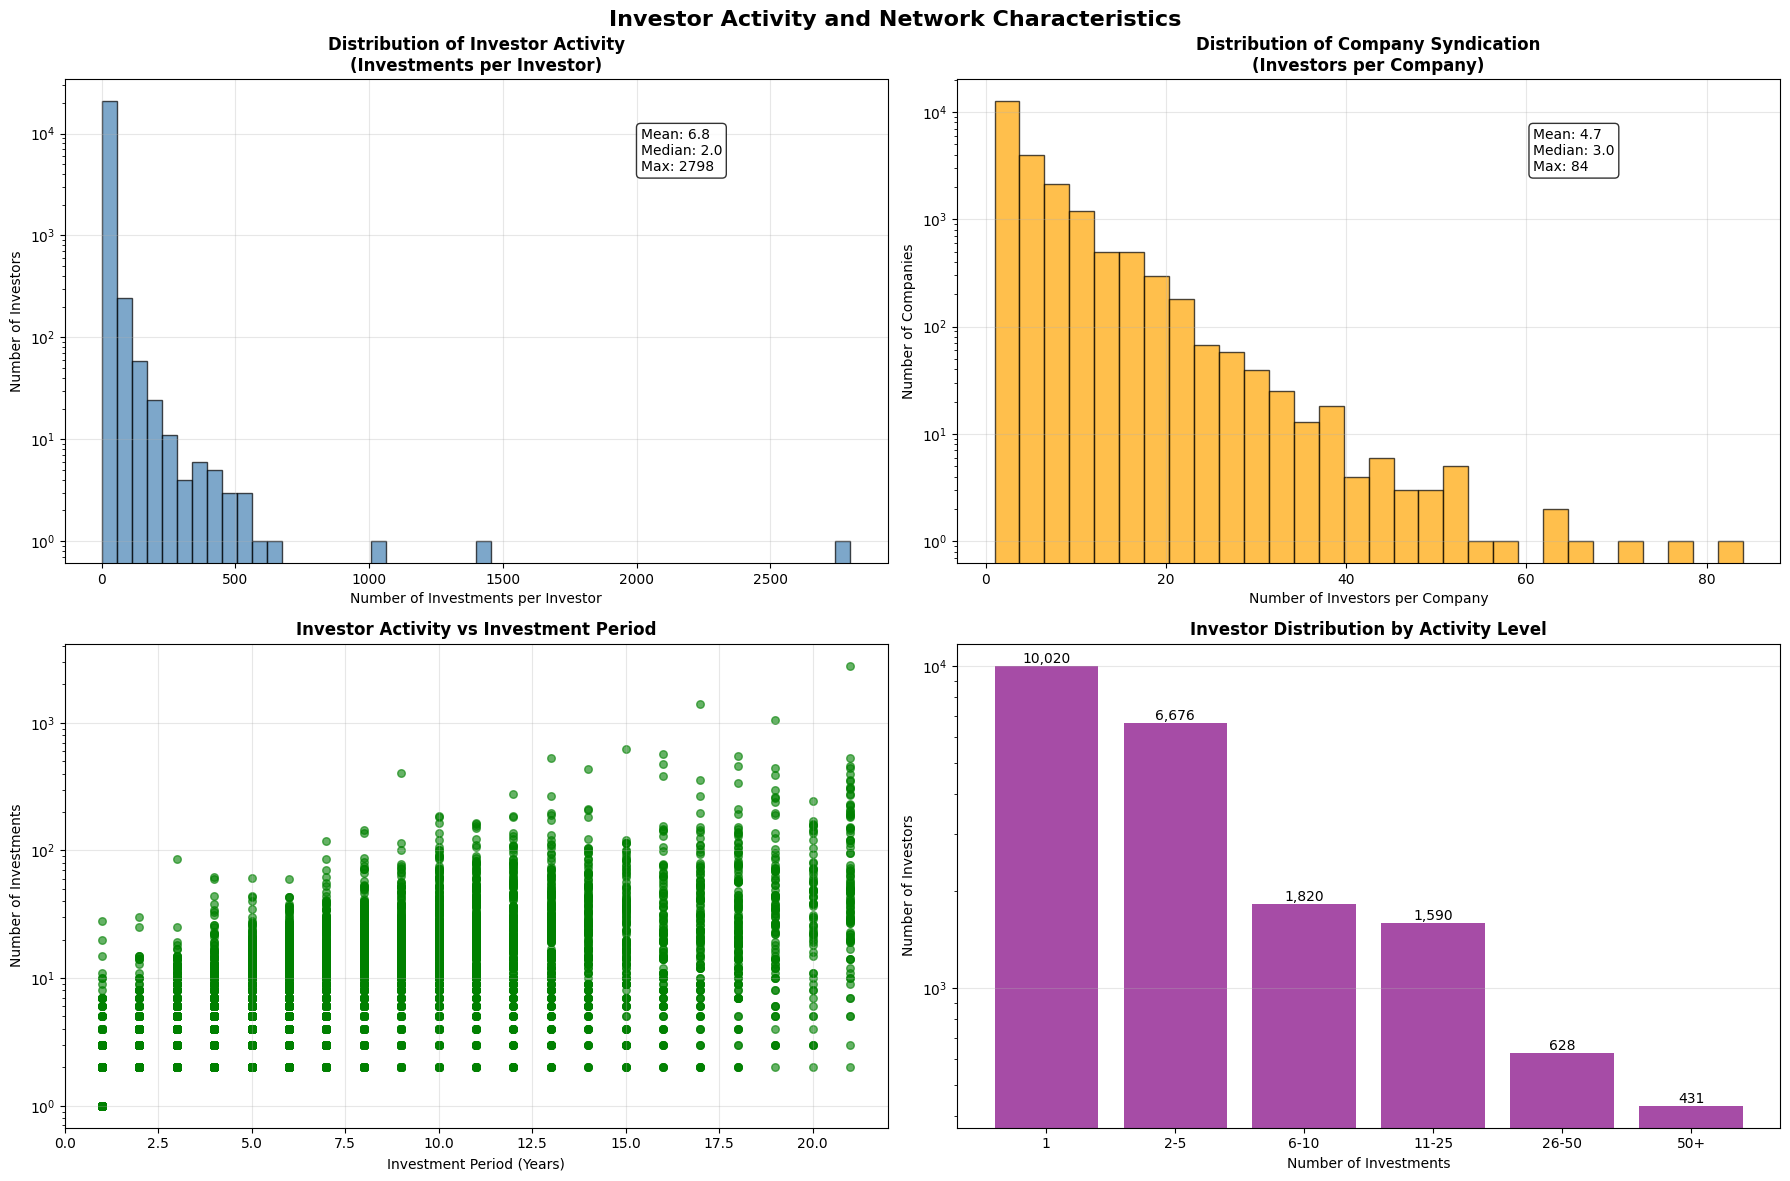


Network Connectivity Analysis:
-----------------------------------
  Companies with syndication: 14,973 (69.1%)
  Highly active investors (top 5%): 1,059
  Threshold for top 5%: 26 investments
  These investors account for: 74,311 investments (51.8%)


In [85]:
print("\nINVESTOR ACTIVITY AND NETWORK CHARACTERISTICS")
print("="*60)

# Investor activity analysis
investor_activity = analysis_data.groupby('investor_uuid').agg(
    num_investments=('org_uuid', 'count'),                # Number of investments per investor
    unique_companies=('org_uuid', 'nunique'),             # Number of unique companies invested in
    total_funding=('total_funding_usd', 'sum'),           # Total funding
    avg_funding=('total_funding_usd', 'mean'),            # Average funding
    first_year=('announced_year', 'min'),                 # First investment year
    last_year=('announced_year', 'max')                   # Last investment year
).round(2)

# Flatten column names
investor_activity.columns = ['num_investments', 'unique_companies', 'total_funding', 
                           'avg_funding', 'first_year', 'last_year']
investor_activity['investment_period'] = investor_activity['last_year'] - investor_activity['first_year'] + 1
investor_activity = investor_activity.reset_index()

print("Investor Activity Statistics:")
print("-" * 30)
print(f"  Total unique investors: {len(investor_activity):,}")
print(f"  Mean investments per investor: {investor_activity['num_investments'].mean():.1f}")
print(f"  Median investments per investor: {investor_activity['num_investments'].median():.1f}")
print(f"  Max investments by single investor: {investor_activity['num_investments'].max():,}")
print(f"  Investors with only 1 investment: {(investor_activity['num_investments'] == 1).sum():,} "
      f"({(investor_activity['num_investments'] == 1).sum()/len(investor_activity)*100:.1f}%)")

# Most active investors
most_active = investor_activity.nlargest(20, 'num_investments')
print(f"\nTop 20 Most Active Investors:")
print("-" * 50)
print(f"{'Rank':<4} {'Investor UUID':<40} {'Investments':<12} {'Companies':<10}")
print("-" * 50)
for i, (_, row) in enumerate(most_active.iterrows()):
    print(f"{i+1:<4} {row['investor_uuid'][:35] + '...' if len(row['investor_uuid']) > 35 else row['investor_uuid']:<40} "
          f"{row['num_investments']:<12.0f} {row['unique_companies']:<10.0f}")

# Company activity analysis
company_activity = analysis_data.groupby('org_uuid').agg(
    total_investments=('investor_uuid', 'count'),         # Total investments per company
    unique_investors=('investor_uuid', 'nunique'),        # Number of unique investors
    total_funding=('total_funding_usd', 'first'),         # Total funding (assumed same for all records of company)
    first_year=('announced_year', 'min'),                 # First investment year
    last_year=('announced_year', 'max'),                  # Last investment year
    investment_stages=('investment_type', lambda x: list(x.unique())) # Investment stages
).round(2)

# Flatten column names
company_activity.columns = ['total_investments', 'unique_investors', 'total_funding', 
                          'first_year', 'last_year', 'investment_stages']
company_activity['fundraising_period'] = company_activity['last_year'] - company_activity['first_year'] + 1
company_activity['num_stages'] = company_activity['investment_stages'].apply(len)
company_activity = company_activity.reset_index()

print(f"\nCompany Fundraising Statistics:")
print("-" * 35)
print(f"  Total unique companies: {len(company_activity):,}")
print(f"  Mean investors per company: {company_activity['unique_investors'].mean():.1f}")
print(f"  Median investors per company: {company_activity['unique_investors'].median():.1f}")
print(f"  Max investors for single company: {company_activity['unique_investors'].max():,}")
print(f"  Companies with only 1 investor: {(company_activity['unique_investors'] == 1).sum():,} "
      f"({(company_activity['unique_investors'] == 1).sum()/len(company_activity)*100:.1f}%)")

# Create investor activity visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Investor Activity and Network Characteristics', 
             fontsize=16, fontweight='bold', y=0.98)

# Plot 1: Distribution of investments per investor
ax1 = axes[0, 0]
inv_per_investor = investor_activity['num_investments']
ax1.hist(inv_per_investor, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Investments per Investor')
ax1.set_ylabel('Number of Investors')
ax1.set_title('Distribution of Investor Activity\n(Investments per Investor)', fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Add statistics text
stats_text = f'Mean: {inv_per_investor.mean():.1f}\nMedian: {inv_per_investor.median():.1f}\nMax: {inv_per_investor.max()}'
ax1.text(0.7, 0.9, stats_text, transform=ax1.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         verticalalignment='top')

# Plot 2: Distribution of investors per company
ax2 = axes[0, 1]
inv_per_company = company_activity['unique_investors']
ax2.hist(inv_per_company, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax2.set_xlabel('Number of Investors per Company')
ax2.set_ylabel('Number of Companies')
ax2.set_title('Distribution of Company Syndication\n(Investors per Company)', fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Add statistics text
stats_text2 = f'Mean: {inv_per_company.mean():.1f}\nMedian: {inv_per_company.median():.1f}\nMax: {inv_per_company.max()}'
ax2.text(0.7, 0.9, stats_text2, transform=ax2.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         verticalalignment='top')

# Plot 3: Investment period vs number of investments
ax3 = axes[1, 0]
active_investors = investor_activity[investor_activity['investment_period'] > 0]
scatter = ax3.scatter(active_investors['investment_period'], active_investors['num_investments'], 
                     alpha=0.6, s=30, color='green')
ax3.set_xlabel('Investment Period (Years)')
ax3.set_ylabel('Number of Investments')
ax3.set_title('Investor Activity vs Investment Period', fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Plot 4: Top investor categories by activity level
ax4 = axes[1, 1]
activity_categories = pd.cut(investor_activity['num_investments'], 
                           bins=[0, 1, 5, 10, 25, 50, float('inf')], 
                           labels=['1', '2-5', '6-10', '11-25', '26-50', '50+'])
activity_counts = activity_categories.value_counts()

bars4 = ax4.bar(range(len(activity_counts)), activity_counts.values, 
                color='purple', alpha=0.7)
ax4.set_xticks(range(len(activity_counts)))
ax4.set_xticklabels(activity_counts.index)
ax4.set_xlabel('Number of Investments')
ax4.set_ylabel('Number of Investors')
ax4.set_title('Investor Distribution by Activity Level', fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'investor_activity_network_characteristics.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Network density and connectivity analysis
print(f"\nNetwork Connectivity Analysis:")
print("-" * 35)

# Potential syndication pairs (companies with multiple investors)
syndicated_companies = company_activity[company_activity['unique_investors'] > 1]
print(f"  Companies with syndication: {len(syndicated_companies):,} "
      f"({len(syndicated_companies)/len(company_activity)*100:.1f}%)")

# Highly connected investors (top 5%)
high_activity_threshold = investor_activity['num_investments'].quantile(0.95)
high_activity_investors = investor_activity[investor_activity['num_investments'] >= high_activity_threshold]
print(f"  Highly active investors (top 5%): {len(high_activity_investors):,}")
print(f"  Threshold for top 5%: {high_activity_threshold:.0f} investments")
print(f"  These investors account for: "
      f"{high_activity_investors['num_investments'].sum():,} investments "
      f"({high_activity_investors['num_investments'].sum()/investor_activity['num_investments'].sum()*100:.1f}%)")

## Bipartite Network Analysis

### Create bipartite graph

In [86]:
# Create bipartite graph
bipartite_graph = create_bipartite_graph(investments_pairs_clean, 'investor_name_left', 'investor_name_right', None, 'left', 'right')
bipartite_sets = get_bipartite_sets(bipartite_graph)

set_0 = bipartite_sets['set_0']
set_1 = bipartite_sets['set_1']

### Identify communities

In [87]:
G = bipartite_graph.copy()

if CALCULATE_COMMUNITIES or not os.path.exists(communities_file):
    print("Calculating communities using greedy_modularity_communities...")
    communities = list(greedy_modularity_communities(G))
    # Convert communities to a DataFrame for saving
    communities_data = []
    for comm_idx, community in enumerate(communities):
        for node in community:
            communities_data.append({
                'community_id': comm_idx,
                'node': node,
                'community_size': len(community)
            })
    
    communities_df = pd.DataFrame(communities_data)
    
    # Create output directory if it doesn't exist
    os.makedirs(processed_dir, exist_ok=True)
    
    # Save to parquet file
    communities_df.to_csv(communities_file, compression='gzip')
    print(f"Saved {len(communities)} communities to {communities_file}")
else:
    # Load communities from parquet file
    print(f"Loading communities from {communities_file}")
    communities_df = pd.read_csv(communities_file, compression='gzip')
    
    # Reconstruct communities list from DataFrame
    communities = []
    for comm_id in sorted(communities_df['community_id'].unique()):
        community_nodes = communities_df[communities_df['community_id'] == comm_id]['node'].tolist()
        communities.append(set(community_nodes))
    
    print(f"Loaded {len(communities)} communities from csv file")

print(f"Total communities: {len(communities)}")

Loading communities from ../data/processed/us/communities.csv.gz
Loaded 168 communities from csv file
Total communities: 168


In [88]:
max_top_communities = 10

top_communities = sorted(communities, key=lambda x: len(x), reverse=True)[:max_top_communities]
print("Top 5 investor communities by size:")
for c_idx, top_community in enumerate(top_communities):
    print(f"Community {c_idx}: {len(top_community)} investors")
    
color_map = {}
for c_idx, community in enumerate(communities):
    comm_size = len(community)
    for node in community:
        color_map[node] = c_idx

colors = [color_map[node] for node in G.nodes]
unique_colors = sorted(set(colors))

Top 5 investor communities by size:
Community 0: 4248 investors
Community 1: 4089 investors
Community 2: 3959 investors
Community 3: 979 investors
Community 4: 188 investors
Community 5: 155 investors
Community 6: 137 investors
Community 7: 122 investors
Community 8: 64 investors
Community 9: 64 investors


In [89]:
if PLOT_KKL:
    plt.figure(figsize=(12, 10))

    pos = nx.kamada_kawai_layout(G)
    color_map = plt.cm.Set1  # Use a color palette with distinct colors

    # Draw the graph with improved visibility
    nx.draw(G, pos, 
    node_color=colors, 
    node_size=20,  # Increased for better visibility
    width=0.2,     # Slightly thicker edges
    cmap=color_map,
    with_labels=False,
    alpha=0.8)

    # Create a legend map
    legend_elements = []
    for i, comm_idx in enumerate(unique_colors[:10]):  # Limit to top 10 for readability
        comm_size = colors.count(comm_idx)
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
            label=f'Community {comm_idx} ({comm_size} nodes)',
            markerfacecolor=color_map(comm_idx), 
            markersize=10))

    plt.legend(handles=legend_elements, loc='upper right', title='Investor Communities')
    plt.title("Clusters of investors detected via communities", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(figures_dir, 'investor_communities_kamada_kawai.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

### Analyse communities

#### Nestdness

In [90]:
# Function to parse the null_scores column
def parse_null_scores(scores_str):
    if isinstance(scores_str, str):
        try:
            # Extract numbers from np.float64(...) format
            pattern = r'np\.float64\((\d+\.\d+(?:e[+-]?\d+)?)\)'
            matches = re.findall(pattern, scores_str)
            
            # If no matches found, try a more general pattern
            if not matches:
                pattern = r'\d+\.\d+(?:e[+-]?\d+)?'
                matches = re.findall(pattern, scores_str)
            
            # Convert to float
            values = [float(match) for match in matches]
            return np.array(values)
        except Exception as e:
            print(f"Error parsing null_scores: {e}")
    return np.array([])

In [91]:
if CALCULATE_COMMUNITIES_NESTEDNESS or not os.path.exists(community_nestedness_file):
    # Initialize storage for community nestedness results
    community_nestedness_results = []

    # Parameters for null model analysis
    n_iterations = 100  # Number of null models to generate
    n_iterations_cv = 10000  # Number of curveball iterations
    min_community_size = 100  # Minimum nodes required for analysis

    print(f"Analyzing nestedness for {len(top_communities)} communities...")
    print("=" * 60)

    for comm_idx, community in enumerate(top_communities):
        if len(community) < min_community_size:
            print(f"Community {comm_idx}: Skipping (only {len(community)} nodes)")
            continue
        
        try:
            # Extract subgraph for this community
            subgraph = bipartite_graph.subgraph(community)
            
            # Get bipartite sets for this community
            community_set_0 = [node for node in community if node in set_0]
            community_set_1 = [node for node in community if node in set_1]
            
            # Skip if either set is empty
            if len(community_set_0) == 0 or len(community_set_1) == 0:
                print(f"Community {comm_idx}: Skipping (empty bipartite set)")
                continue
            
            print(f"Community {comm_idx}: {len(community_set_0)} left nodes, {len(community_set_1)} right nodes")
            
            # Create adjacency matrix for this community
            left_indices = {node: i for i, node in enumerate(community_set_0)}
            right_indices = {node: j for j, node in enumerate(community_set_1)}
            
            # Initialize adjacency matrix
            community_adjacency_matrix = np.zeros((len(community_set_0), len(community_set_1)))
            
            # Fill matrix with connections within this community
            for left_node in community_set_0:
                for right_node in community_set_1:
                    if subgraph.has_edge(left_node, right_node):
                        left_idx = left_indices[left_node]
                        right_idx = right_indices[right_node]
                        community_adjacency_matrix[left_idx, right_idx] = 1
            
            # Calculate observed nestedness
            calculator = NestednessCalculator(community_adjacency_matrix)
            nestedness_score = calculator.nodf(community_adjacency_matrix)
            
            # Calculate basic network metrics
            num_edges = int(community_adjacency_matrix.sum())
            density = community_adjacency_matrix.mean()
            
            print(f"  Observed nestedness (NODF): {nestedness_score:.4f}")
            print(f"  Edges: {num_edges}, Density: {density:.4f}")
            
            # Generate null models using curveball algorithm
            null_nestedness_scores = []
            
            print(f"  Generating {n_iterations} null models...")
            for i in tqdm(range(n_iterations), desc=f"Community {comm_idx}"):
                try:
                    # Generate null model matrix by swapping while preserving degrees
                    M = community_adjacency_matrix.copy()
                    r_hp = find_presences(M)
                    RM = curve_ball(M, r_hp, n_iterations_cv)
                    
                    null_matrix = RM.astype(community_adjacency_matrix.dtype)
                    
                    # Calculate nestedness of the null model
                    calculator_null = NestednessCalculator(null_matrix)
                    null_score = calculator_null.nodf(null_matrix)
                    null_nestedness_scores.append(null_score)
                    
                except Exception as e:
                    print(f"    Error in null model iteration {i}: {e}")
                    continue
            
            # Calculate statistical significance
            if len(null_nestedness_scores) > 0:
                null_nestedness_scores_np = np.array(null_nestedness_scores)
                mean_null = np.mean(null_nestedness_scores_np)
                std_null = np.std(null_nestedness_scores_np)
                
                if std_null > 0:
                    z_score = (nestedness_score - mean_null) / std_null
                else:
                    z_score = np.nan
                
                # Corrected p-value calculation for empirical distributions
                # Adding 1 to both numerator and denominator to avoid p-values of exactly 0
                # This is the standard approach for empirical p-values with discrete distributions
                p_value = (np.sum(null_nestedness_scores_np >= nestedness_score) + 1) / (len(null_nestedness_scores_np) + 1)
                significance = 'significant' if p_value < 0.05 else 'not_significant'
                
                print(f"  Null model mean: {mean_null:.4f} ± {std_null:.4f}")
                print(f"  Z-score: {z_score:.10f}, P-value: {p_value:.10f} ({significance})")
            else:
                mean_null = std_null = z_score = p_value = np.nan
                significance = 'null_model_failed'
                print(f"  Warning: No valid null models generated")
            
            # Store results
            community_nestedness_results.append({
                'community_id': comm_idx,
                'community_size': len(community),
                'left_nodes': len(community_set_0),
                'right_nodes': len(community_set_1),
                'num_edges': num_edges,
                'density': density,
                'observed_nestedness': nestedness_score,
                'null_mean': mean_null,
                'null_std': std_null,
                'z_score': z_score,
                'p_value': p_value,
                'significance': significance,
                'null_scores': null_nestedness_scores if len(null_nestedness_scores) > 0 else []
            })
            
        except Exception as e:
            print(f"Community {comm_idx}: Error - {str(e)}")
            continue

    print(f"\nAnalyzed {len(community_nestedness_results)} communities successfully")
    community_nestedness_df = pd.DataFrame(community_nestedness_results)
    community_nestedness_df.to_csv(community_nestedness_file, compression='gzip')
    print(f"Saved nestedness results to {community_nestedness_file}")
else:
    community_nestedness_df = pd.read_csv(community_nestedness_file, compression='gzip')

    # Apply the parsing function to the null_scores column
    community_nestedness_df['null_scores'] = community_nestedness_df['null_scores'].apply(parse_null_scores)
    print(f"Got nestedness results from {community_nestedness_file}")

Got nestedness results from ../data/processed/us/community_nestedness_results.csv.gz


In [92]:
# Convert results to DataFrame for analysis
if len(community_nestedness_df) > 0:
    print("Community Nestedness Analysis Summary:")
    print("=" * 50)
    print(f"Total communities analyzed: {len(community_nestedness_df)}")
    print(f"Significant communities (p < 0.05): {len(community_nestedness_df[community_nestedness_df['significance'] == 'significant'])}")
    
    # Display summary statistics
    print("\nNestedness Statistics:")
    valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
    if len(valid_results) > 0:
        print(f"Mean observed nestedness: {valid_results['observed_nestedness'].mean():.4f} ± {valid_results['observed_nestedness'].std():.4f}")
        print(f"Mean null nestedness: {valid_results['null_mean'].mean():.4f} ± {valid_results['null_mean'].std():.4f}")
        print(f"Mean Z-score: {valid_results['z_score'].mean():.4f} ± {valid_results['z_score'].std():.4f}")
else:
    print("No communities were successfully analyzed")

Community Nestedness Analysis Summary:
Total communities analyzed: 8
Significant communities (p < 0.05): 1

Nestedness Statistics:
Mean observed nestedness: 0.0520 ± 0.0336
Mean null nestedness: 0.0711 ± 0.0491
Mean Z-score: -10.1882 ± 9.2847


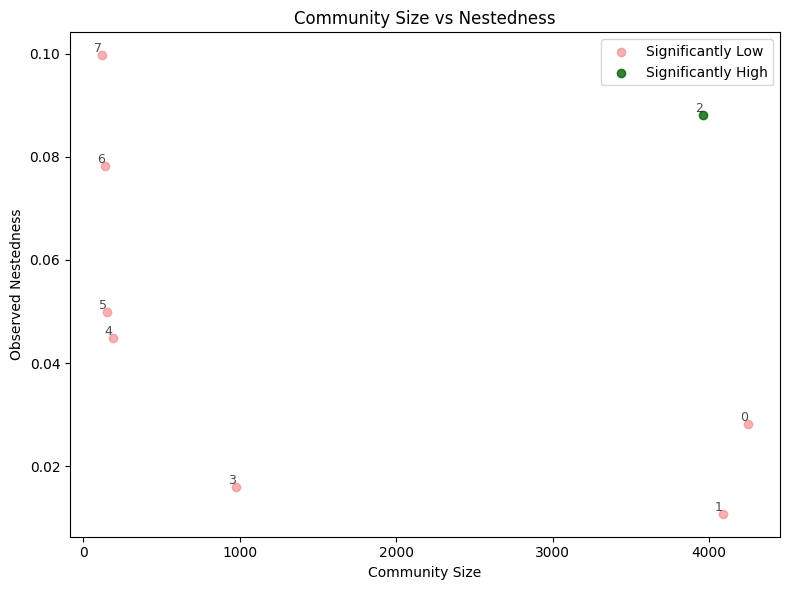

Plotted data (community_id, community_size, observed_nestedness, significance):
   community_id  community_size  observed_nestedness     significance
0             0            4248             0.028264  not_significant
1             1            4089             0.010790  not_significant
2             2            3959             0.088167      significant
3             3             979             0.015946  not_significant
4             4             188             0.044920  not_significant
5             5             155             0.049980  not_significant
6             6             137             0.078298  not_significant
7             7             122             0.099695  not_significant


" plt.figure(figsize=(8, 6))\nplt.hist(valid_results_community_nestedness['p_value'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')\nplt.axvline(0.05, color='red', linestyle='--', label='α=0.05')\nplt.xlabel('P-value')\nplt.ylabel('Frequency')\nplt.title('Distribution of P-values')\nplt.legend()\nplt.tight_layout()\nplt.savefig(os.path.join(figures_dir, 'nestedness_pvalue_distribution.png'), dpi=300, bbox_inches='tight')\nplt.show() "

In [93]:
# Visualize community nestedness results
valid_results_community_nestedness = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]

# Plot 2: Distribution of Z-scores
""" plt.figure(figsize=(8, 6))
plt.hist(valid_results_community_nestedness['z_score'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Z=0')
plt.axvline(1.96, color='orange', linestyle='--', label='Z=1.96 (p=0.05)')
plt.axvline(-1.96, color='orange', linestyle='--')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Distribution of Nestedness Z-scores')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'nestedness_zscores_distribution.png'), dpi=300, bbox_inches='tight')
plt.show() """

# Plot 3: Community size vs Nestedness, with community labels
plt.figure(figsize=(8, 6))
significant_mask = valid_results_community_nestedness['significance'] == 'significant'

# Plot not significant
plt.scatter(valid_results_community_nestedness[~significant_mask]['community_size'], 
  valid_results_community_nestedness[~significant_mask]['observed_nestedness'],
  c='lightcoral', alpha=0.6, label='Significantly Low')

# Plot significant
plt.scatter(valid_results_community_nestedness[significant_mask]['community_size'], 
  valid_results_community_nestedness[significant_mask]['observed_nestedness'],
  c='darkgreen', alpha=0.8, label='Significantly High')

# Annotate each point with its community_id
for idx, row in valid_results_community_nestedness.iterrows():
  plt.text(row['community_size'], row['observed_nestedness'], str(row['community_id']),
   fontsize=9, ha='right', va='bottom', alpha=0.7)

plt.xlabel('Community Size')
plt.ylabel('Observed Nestedness')
plt.title('Community Size vs Nestedness')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'nestedness_by_community_size.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print the data being plotted
print("Plotted data (community_id, community_size, observed_nestedness, significance):")
print(valid_results_community_nestedness[['community_id', 'community_size', 'observed_nestedness', 'significance']])

# Plot 4: P-value distribution
""" plt.figure(figsize=(8, 6))
plt.hist(valid_results_community_nestedness['p_value'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of P-values')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'nestedness_pvalue_distribution.png'), dpi=300, bbox_inches='tight')
plt.show() """

In [94]:
def plot_communities_null_models_and_structure(communities_to_plot, dir_to_save, fig_name, title_column = 'community_id'):
    fig, axes = plt.subplots(len(communities_to_plot), 2, figsize=(16, 4 * len(communities_to_plot)))

    for i, (_, row) in enumerate(communities_to_plot.iterrows()):
        comm_idx = row['community_id']
        null_scores = row['null_scores']
        
        title = row[title_column]
        
        if len(null_scores) > 0:
            # Histogram of null model distribution
            sns.histplot(null_scores, kde=True, color='skyblue', ax=axes[i, 0])
            axes[i, 0].axvline(row['observed_nestedness'], color='red', linestyle='--', 
                            linewidth=2, label=f'Observed (NODF={row["observed_nestedness"]:.4f})')
            axes[i, 0].axvline(row['null_mean'], color='black', linestyle='-', 
                            linewidth=1, label=f'Null mean (NODF={row["null_mean"]:.4f})')
            axes[i, 0].set_title(f'Community {title} Null Model Analysis\n'
                                f'Z-score: {row["z_score"]:.4f}, p-value: {row["p_value"]:.4f}')
            axes[i, 0].set_xlabel('Nestedness (NODF)')
            axes[i, 0].set_ylabel('Frequency')
            axes[i, 0].legend()
        
        # Bar plot of community structure
        axes[i, 1].bar(['Left Nodes', 'Right Nodes'], 
                    [row['left_nodes'], row['right_nodes']], 
                    color=['lightblue', 'lightcoral'])
        axes[i, 1].set_title(f'Community {comm_idx} Structure\n'
                            f'Total size: {row["community_size"]}, Edges: {row["num_edges"]}')
        axes[i, 1].set_ylabel('Number of Nodes')

    plt.tight_layout()

    # Save figure
    plt.savefig(os.path.join(dir_to_save, fig_name), dpi=300, bbox_inches='tight')
    plt.show()


Detailed analysis for top 5 significant communities:


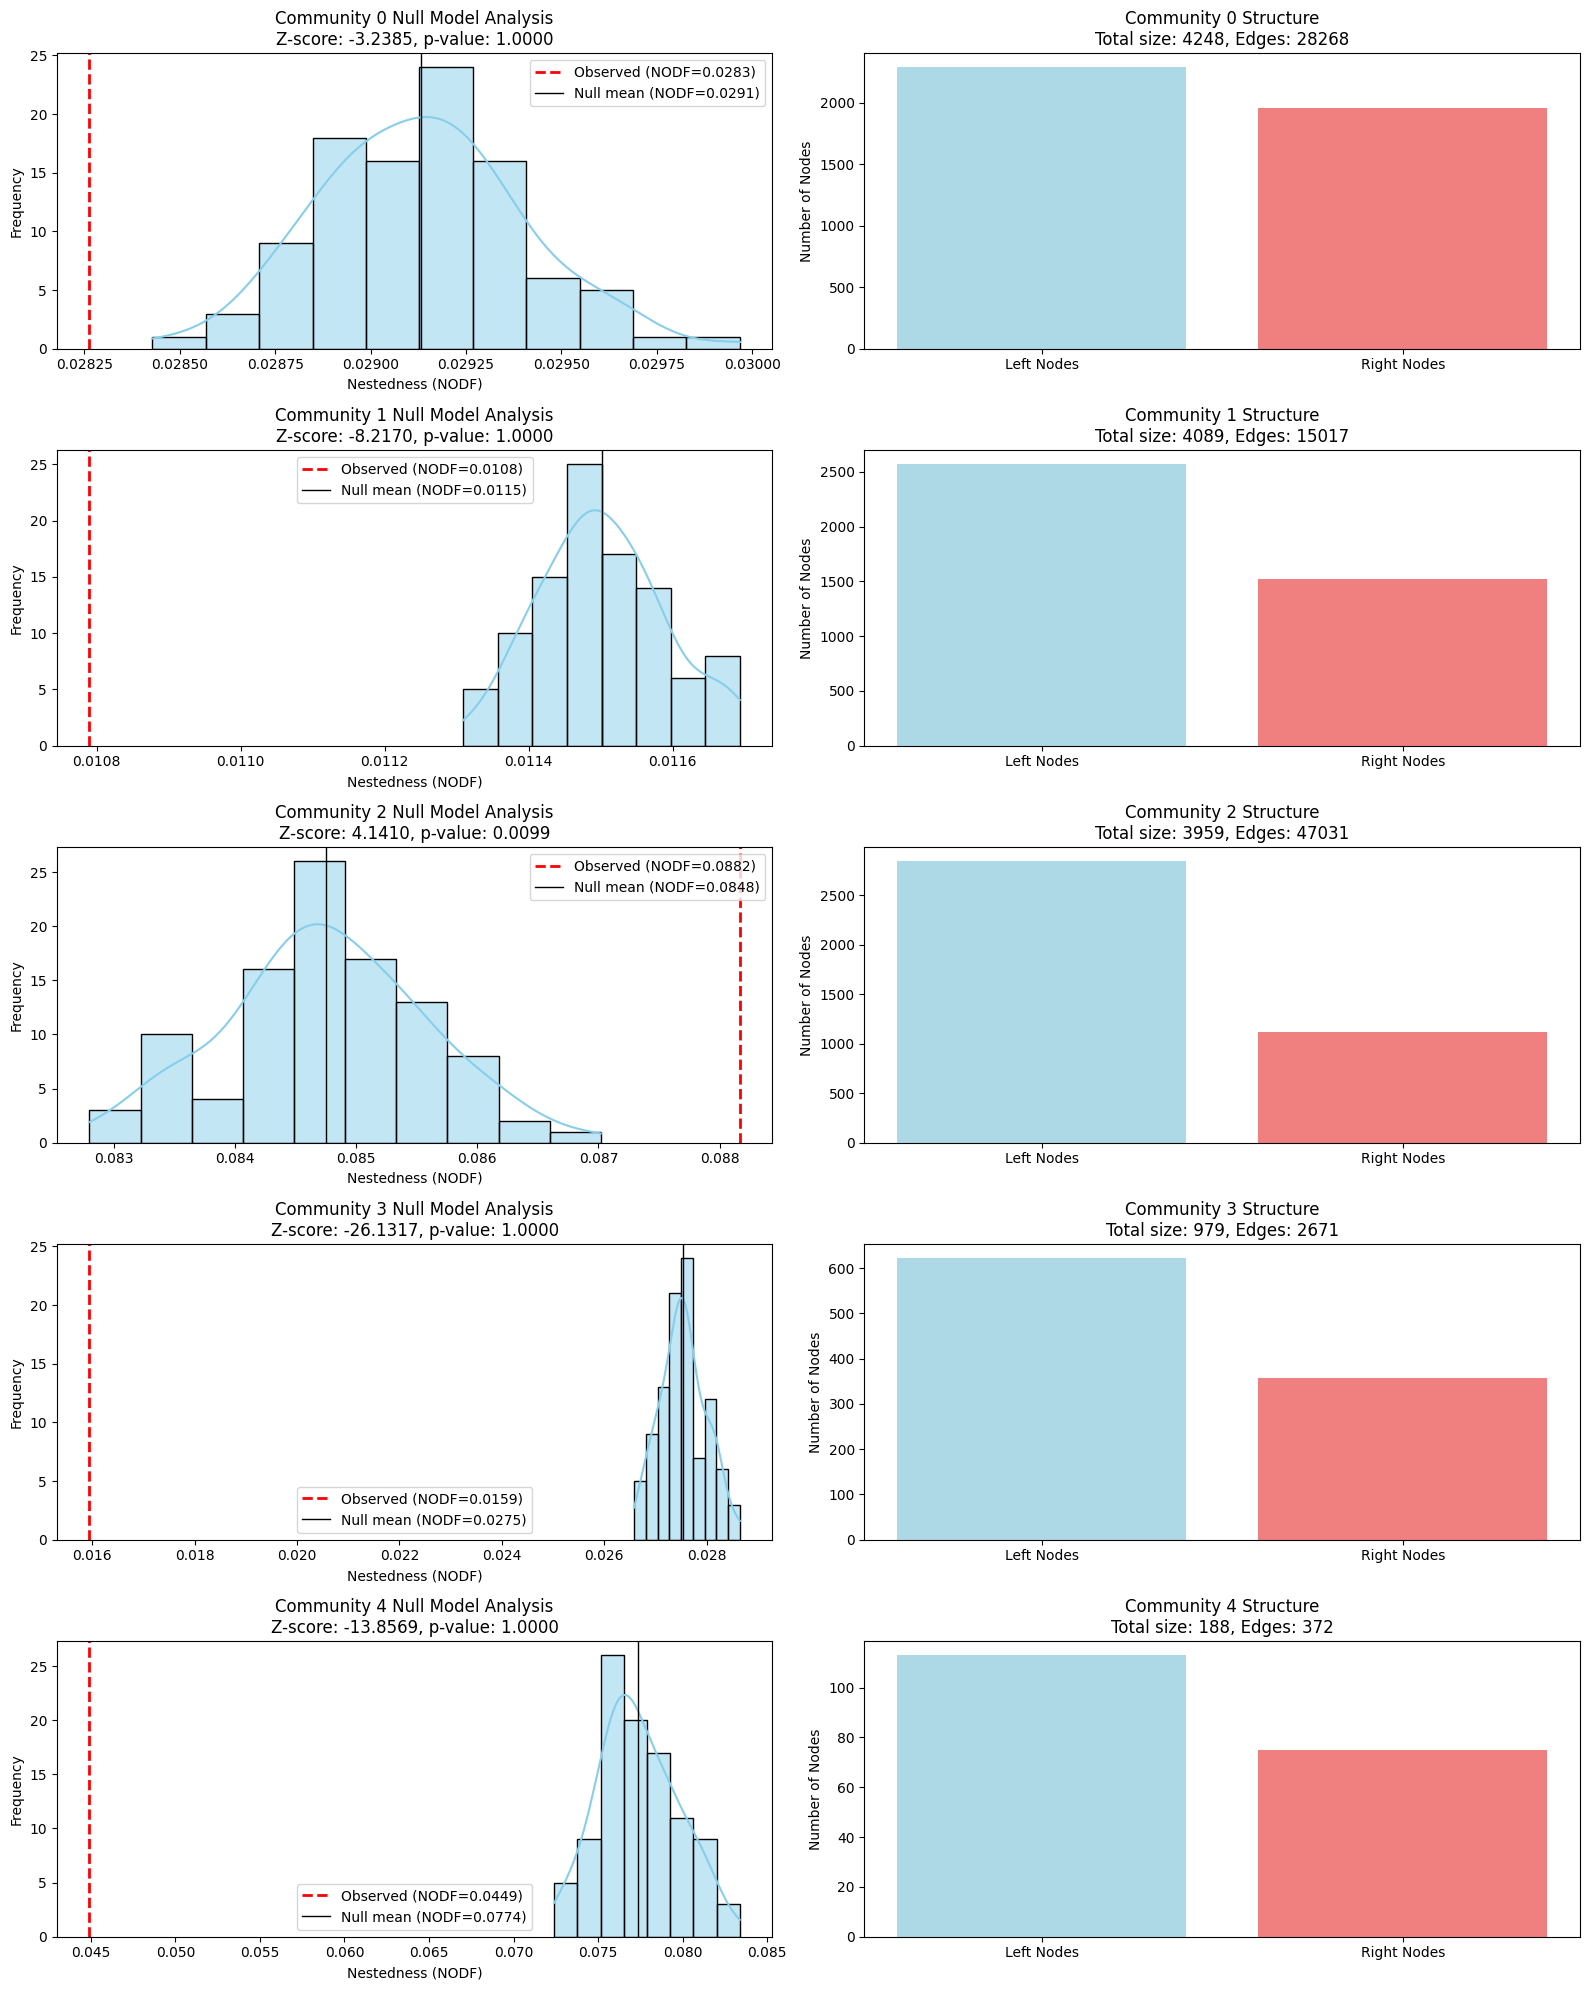

In [95]:
# Create detailed plots for significant communities
significant_communities = valid_results_community_nestedness.head(5)

print(f"\nDetailed analysis for top {len(significant_communities)} significant communities:")

plot_communities_null_models_and_structure(significant_communities, figures_dir, 'significant_communities_detailed.png', 'community_id')

### Deepdive Communities

In [96]:
investments_pairs_communities = investments_pairs.copy()
# Create a mapping from investor name to community ID
investor_to_community = {}
for comm_idx, community in enumerate(communities):
  for investor in community:
    investor_to_community[investor] = comm_idx

# Add community column for left and right investors
investments_pairs_communities['community_left'] = investments_pairs_communities['investor_name_left'].map(investor_to_community).fillna(-1).astype(int)
investments_pairs_communities['community_right'] = investments_pairs_communities['investor_name_right'].map(investor_to_community).fillna(-1).astype(int)

# A pair is considered to be in a community if both investors are in the same community
investments_pairs_communities['community'] = np.where(
  (investments_pairs_communities['community_left'] == investments_pairs_communities['community_right']) & 
  (investments_pairs_communities['community_left'] != -1),
  investments_pairs_communities['community_left'],
  -1
)

# Drop the intermediate columns
#investments_pairs_communities.drop(columns=['community_left', 'community_right'], inplace=True)

# Print distribution of communities
community_counts = investments_pairs_communities['community'].value_counts()
print(f"Investment pairs assigned to communities: {(investments_pairs_communities['community'] != -1).sum()}")
print(f"Investment pairs not in any community: {(investments_pairs_communities['community'] == -1).sum()}")
print("\nTop 5 communities by number of investment pairs:")
print(community_counts.head())


Investment pairs assigned to communities: 111350
Investment pairs not in any community: 58329

Top 5 communities by number of investment pairs:
community
-1    58329
 2    55863
 0    32164
 1    17301
 3     2904
Name: count, dtype: int64


In [97]:
# Filter the data for communities 0, 1, and 2
communities_of_interest = [0, 1, 2]

community_data = {}
for comm_id in communities_of_interest:
  community_data[comm_id] = investments_pairs_communities[investments_pairs_communities['community'] == comm_id]

# Print the sizes of each community
for comm_id in communities_of_interest:
  print(f"Community {comm_id}: {len(community_data[comm_id])} investment pairs")

# Function to truncate long category names
def truncate_name(name, max_length=30):
  if isinstance(name, str) and len(name) > max_length:
    return name[:max_length] + '...'
  return name

Community 0: 32164 investment pairs
Community 1: 17301 investment pairs
Community 2: 55863 investment pairs


#### Numeric Columns

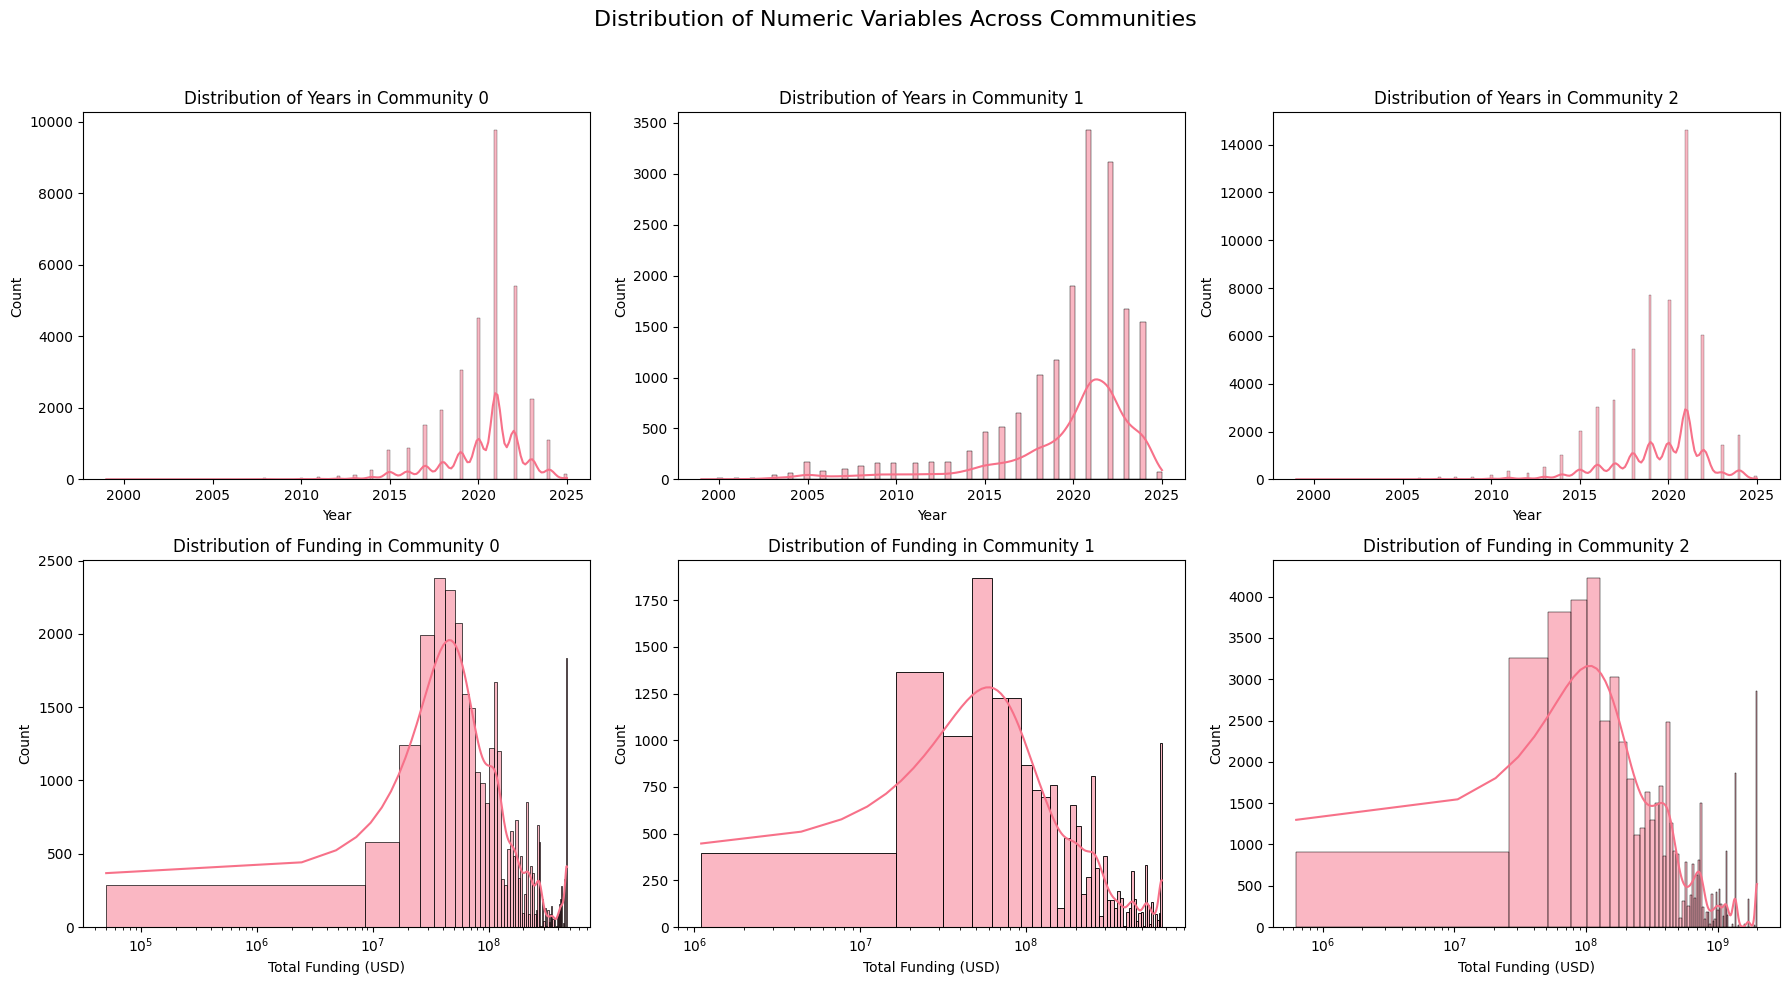

In [98]:
# Plot numeric columns
numeric_columns = ['year', 'total_funding_usd']
fig, axes = plt.subplots(len(numeric_columns), len(communities_of_interest), figsize=(18, 10))
fig.suptitle('Distribution of Numeric Variables Across Communities', fontsize=16)

for row_idx, column in enumerate(numeric_columns):
  for col_idx, comm_id in enumerate(communities_of_interest):
    ax = axes[row_idx, col_idx]
    data = community_data[comm_id]
    
    if len(data) > 0:
      if column == 'total_funding_usd':
        # Log scale and clip outliers
        sns.histplot(data[column].clip(upper=data[column].quantile(0.95), ), kde=True, ax=ax)
        ax.set_xlabel('Total Funding (USD)')
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of Funding in Community {comm_id}')
        ax.set_xscale('log')

      else:
        sns.histplot(data[column], kde=True, ax=ax)
        ax.set_xlabel('Year')
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of Years in Community {comm_id}')
        
    else:
      ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
      ax.set_title(f'Community {comm_id}')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig(os.path.join(figures_dir, 'numeric_variables_distribution.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

#### Categorical Columns

<Figure size 1200x800 with 0 Axes>

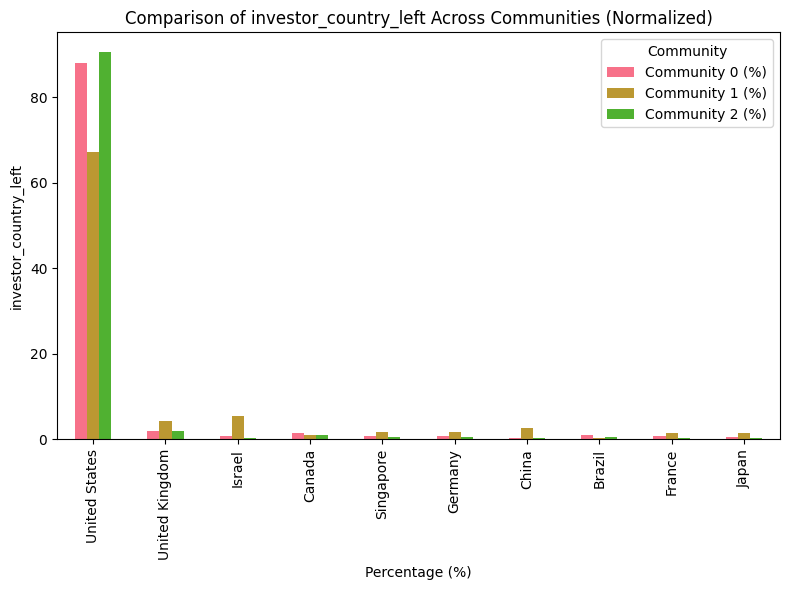

<Figure size 1200x800 with 0 Axes>

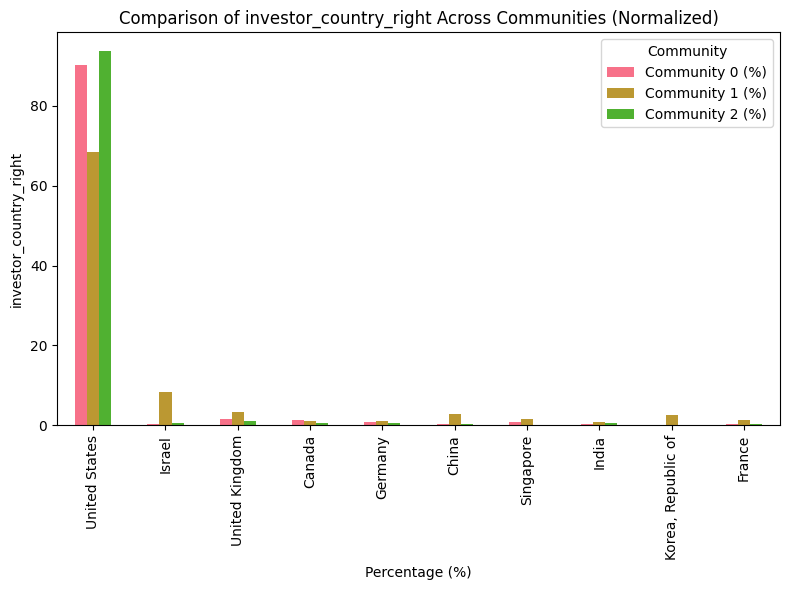

<Figure size 1200x800 with 0 Axes>

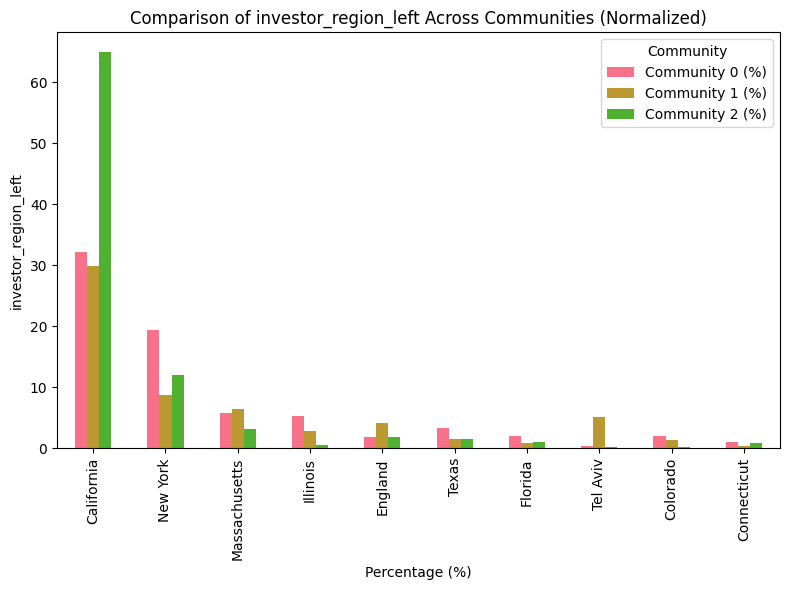

<Figure size 1200x800 with 0 Axes>

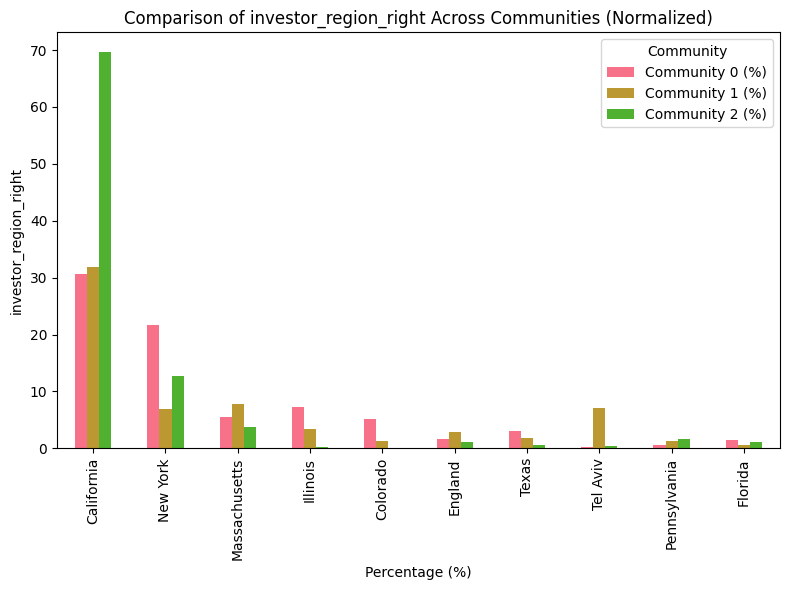

<Figure size 1200x800 with 0 Axes>

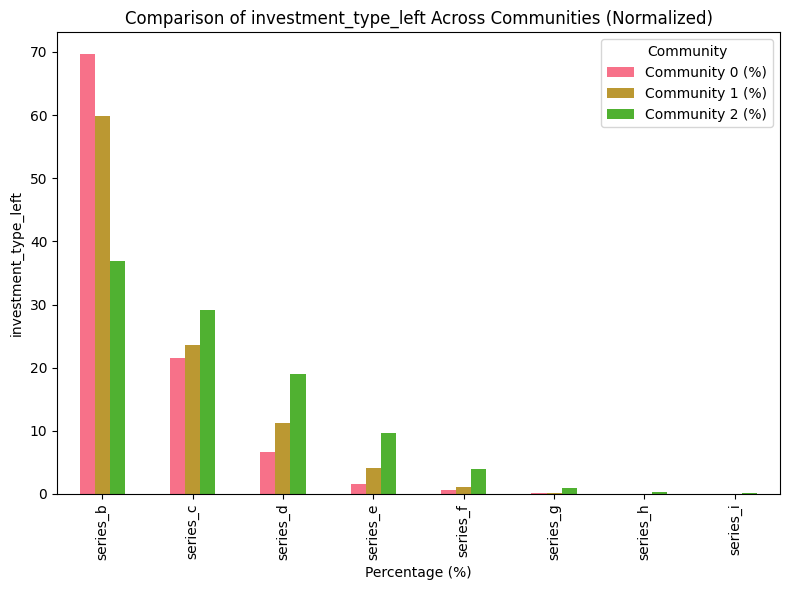

<Figure size 1200x800 with 0 Axes>

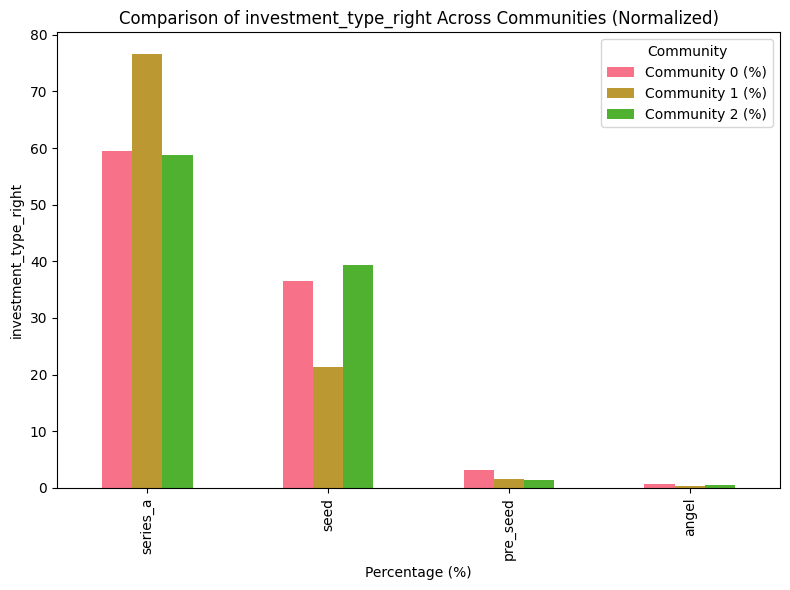

<Figure size 1200x800 with 0 Axes>

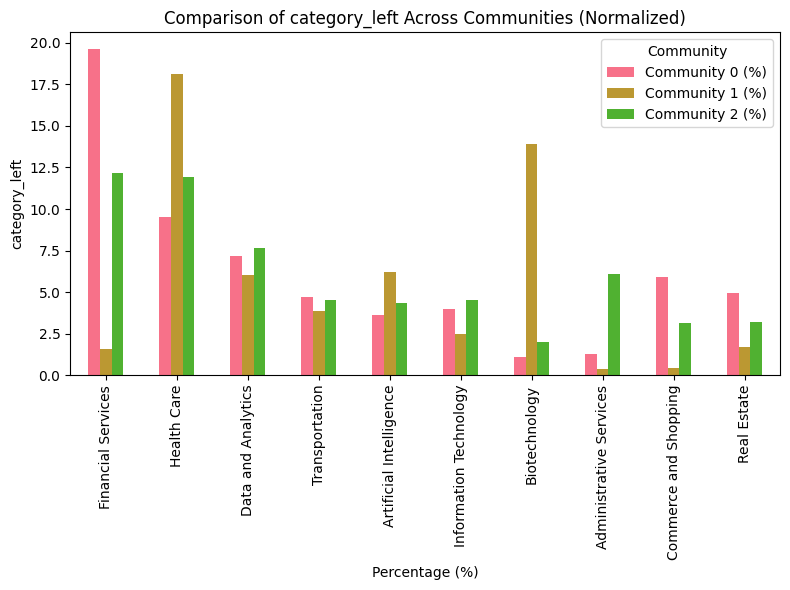

In [99]:
# Plot categorical columns
categorical_columns = [
  'investor_country_left',
  'investor_country_right',
  'investor_region_left',
  'investor_region_right',
  'investment_type_left',
  'investment_type_right',
  'category_left',
]

for column in categorical_columns:
  # Get the top 10 categories across all communities
  all_data = pd.concat([community_data[comm_id][column] for col_idx, comm_id in enumerate(communities_of_interest)])
  top_categories = all_data.value_counts().head(10).index.tolist()
  
  # Create a comparison dataframe
  comparison_df = pd.DataFrame(index=top_categories)
  
  for comm_id in communities_of_interest:
    if len(community_data[comm_id]) > 0:
      # Get counts for this community
      counts = community_data[comm_id][column].value_counts()
      # Normalize to percentages
      normalized_counts = counts / len(community_data[comm_id]) * 100
      # Add to comparison df
      comparison_df[f'Community {comm_id} (%)'] = normalized_counts.reindex(comparison_df.index, fill_value=0)
    else:
      comparison_df[f'Community {comm_id} (%)'] = 0
  
  # Truncate long category names
  truncated_index = [truncate_name(cat) for cat in comparison_df.index]
  comparison_df.index = truncated_index
  
  # Plot the comparison
  plt.figure(figsize=(12, 8))
  comparison_df.plot(kind='bar', figsize=(8, 6))
  plt.title(f'Comparison of {column} Across Communities (Normalized)')
  plt.xlabel('Percentage (%)')
  plt.ylabel(column)
  plt.legend(title='Community')
  plt.tight_layout()
  
  # Save figure
  safe_column_name = column.replace('/', '_').replace(' ', '_')
  plt.savefig(os.path.join(figures_dir, f'categorical_comparison_{safe_column_name}.png'), 
              dpi=300, bbox_inches='tight')
  plt.show()

#### Percentage of local (US and California) and foreign



US vs Foreign Investors Analysis

Community 0 (32164 investment pairs)
------------------------------
Country Distribution:
  Late-stage investors (Left): US 88.0% (28319/32164), Foreign 12.0% (3845/32164)
  Early-stage investors (Right): US 90.2% (29001/32164), Foreign 9.8% (3163/32164)

US Region Distribution:
  Late-stage US investors (Left): California 36.6% (10357/28319), Other US 63.4% (17962/28319)
  Early-stage US investors (Right): California 33.9% (9833/29001), Other US 66.1% (19168/29001)

Community 1 (17301 investment pairs)
------------------------------
Country Distribution:
  Late-stage investors (Left): US 67.1% (11605/17301), Foreign 32.9% (5696/17301)
  Early-stage investors (Right): US 68.5% (11856/17301), Foreign 31.5% (5445/17301)

US Region Distribution:
  Late-stage US investors (Left): California 44.6% (5175/11605), Other US 55.4% (6430/11605)
  Early-stage US investors (Right): California 46.4% (5502/11856), Other US 53.6% (6354/11856)

Community 2 (55863 inv

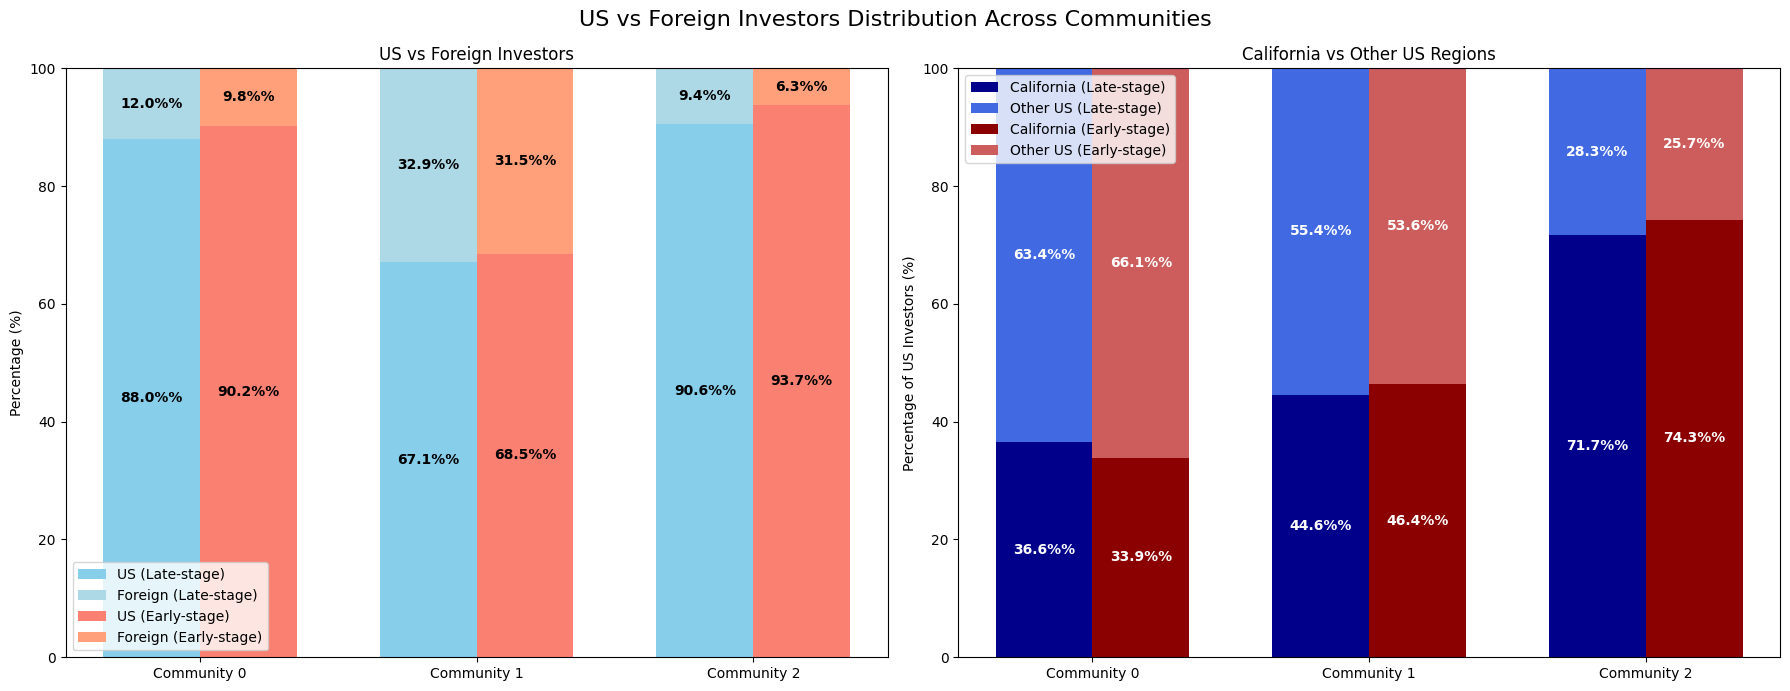

In [100]:
# Calculate percentage of US vs foreign investors for each community
print("\n\nUS vs Foreign Investors Analysis")
print("=" * 50)

# Initialize dictionaries to store results
country_stats = {}
region_stats = {}

for comm_id in communities_of_interest:
    # Get data for this community
    data = community_data[comm_id]
    
    # Country analysis
    country_stats[comm_id] = {}
    
    # Left investors (late-stage investors)
    left_total = len(data)
    left_us = data[data['investor_country_left'] == 'United States'].shape[0]
    left_foreign = left_total - left_us
    left_us_pct = (left_us / left_total * 100) if left_total > 0 else 0
    left_foreign_pct = (left_foreign / left_total * 100) if left_total > 0 else 0
    
    # Right investors (early-stage investors)
    right_total = len(data)
    right_us = data[data['investor_country_right'] == 'United States'].shape[0]
    right_foreign = right_total - right_us
    right_us_pct = (right_us / right_total * 100) if right_total > 0 else 0
    right_foreign_pct = (right_foreign / right_total * 100) if right_total > 0 else 0
    
    # Store results
    country_stats[comm_id]['left_us'] = left_us
    country_stats[comm_id]['left_foreign'] = left_foreign
    country_stats[comm_id]['left_us_pct'] = left_us_pct
    country_stats[comm_id]['left_foreign_pct'] = left_foreign_pct
    country_stats[comm_id]['right_us'] = right_us
    country_stats[comm_id]['right_foreign'] = right_foreign
    country_stats[comm_id]['right_us_pct'] = right_us_pct
    country_stats[comm_id]['right_foreign_pct'] = right_foreign_pct
    
    # Region analysis - California vs Other US regions
    region_stats[comm_id] = {}
    
    # Left investors (late-stage)
    left_us_data = data[data['investor_country_left'] == 'United States']
    left_us_total = len(left_us_data)
    left_california = left_us_data[left_us_data['investor_region_left'] == 'California'].shape[0]
    left_other_us = left_us_total - left_california
    left_california_pct = (left_california / left_us_total * 100) if left_us_total > 0 else 0
    left_other_us_pct = (left_other_us / left_us_total * 100) if left_us_total > 0 else 0
    
    # Right investors (early-stage)
    right_us_data = data[data['investor_country_right'] == 'United States']
    right_us_total = len(right_us_data)
    right_california = right_us_data[right_us_data['investor_region_right'] == 'California'].shape[0]
    right_other_us = right_us_total - right_california
    right_california_pct = (right_california / right_us_total * 100) if right_us_total > 0 else 0
    right_other_us_pct = (right_other_us / right_us_total * 100) if right_us_total > 0 else 0
    
    # Store results
    region_stats[comm_id]['left_california'] = left_california
    region_stats[comm_id]['left_other_us'] = left_other_us
    region_stats[comm_id]['left_california_pct'] = left_california_pct
    region_stats[comm_id]['left_other_us_pct'] = left_other_us_pct
    region_stats[comm_id]['right_california'] = right_california
    region_stats[comm_id]['right_other_us'] = right_other_us
    region_stats[comm_id]['right_california_pct'] = right_california_pct
    region_stats[comm_id]['right_other_us_pct'] = right_other_us_pct

    # Print results
    print(f"\nCommunity {comm_id} ({len(data)} investment pairs)")
    print("-" * 30)
    print("Country Distribution:")
    print(f"  Late-stage investors (Left): US {left_us_pct:.1f}% ({left_us}/{left_total}), Foreign {left_foreign_pct:.1f}% ({left_foreign}/{left_total})")
    print(f"  Early-stage investors (Right): US {right_us_pct:.1f}% ({right_us}/{right_total}), Foreign {right_foreign_pct:.1f}% ({right_foreign}/{right_total})")
    
    print("\nUS Region Distribution:")
    print(f"  Late-stage US investors (Left): California {left_california_pct:.1f}% ({left_california}/{left_us_total}), Other US {left_other_us_pct:.1f}% ({left_other_us}/{left_us_total})")
    print(f"  Early-stage US investors (Right): California {right_california_pct:.1f}% ({right_california}/{right_us_total}), Other US {right_other_us_pct:.1f}% ({right_other_us}/{right_us_total})")

# Create visualizations
# Country distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('US vs Foreign Investors Distribution Across Communities', fontsize=16)

# Data preparation for visualization
country_df = pd.DataFrame({
    'Community': list(communities_of_interest) * 2,
    'Investor Type': ['Late-stage (Left)'] * len(communities_of_interest) + ['Early-stage (Right)'] * len(communities_of_interest),
    'US Percentage': [country_stats[c]['left_us_pct'] for c in communities_of_interest] + 
                    [country_stats[c]['right_us_pct'] for c in communities_of_interest],
    'Foreign Percentage': [country_stats[c]['left_foreign_pct'] for c in communities_of_interest] + 
                         [country_stats[c]['right_foreign_pct'] for c in communities_of_interest]
})

# Bar plot for US vs Foreign
ax = axes[0]
x = np.arange(len(communities_of_interest))
width = 0.35

# Left investors (late-stage)
ax.bar(x - width/2, 
       [country_stats[c]['left_us_pct'] for c in communities_of_interest], 
       width, label='US (Late-stage)', color='skyblue')
ax.bar(x - width/2, 
       [country_stats[c]['left_foreign_pct'] for c in communities_of_interest],
       width, bottom=[country_stats[c]['left_us_pct'] for c in communities_of_interest],
       label='Foreign (Late-stage)', color='lightblue')

# Right investors (early-stage)
ax.bar(x + width/2, 
       [country_stats[c]['right_us_pct'] for c in communities_of_interest], 
       width, label='US (Early-stage)', color='salmon')
ax.bar(x + width/2, 
       [country_stats[c]['right_foreign_pct'] for c in communities_of_interest],
       width, bottom=[country_stats[c]['right_us_pct'] for c in communities_of_interest],
       label='Foreign (Early-stage)', color='lightsalmon')

ax.set_ylabel('Percentage (%)')
ax.set_title('US vs Foreign Investors')
ax.set_xticks(x)
ax.set_xticklabels([f'Community {c}' for c in communities_of_interest])
ax.legend()
ax.set_ylim(0, 100)

# Add value labels on bars
for i, c in enumerate(communities_of_interest):
    # Late-stage US
    ax.text(i - width/2, country_stats[c]['left_us_pct']/2, 
            f"{country_stats[c]['left_us_pct']:.1f}%%", 
            ha='center', va='center', color='black', fontweight='bold')
    
    # Late-stage Foreign
    ax.text(i - width/2, country_stats[c]['left_us_pct'] + country_stats[c]['left_foreign_pct']/2, 
            f"{country_stats[c]['left_foreign_pct']:.1f}%%", 
            ha='center', va='center', color='black', fontweight='bold')
    
    # Early-stage US
    ax.text(i + width/2, country_stats[c]['right_us_pct']/2, 
            f"{country_stats[c]['right_us_pct']:.1f}%%", 
            ha='center', va='center', color='black', fontweight='bold')
    
    # Early-stage Foreign
    ax.text(i + width/2, country_stats[c]['right_us_pct'] + country_stats[c]['right_foreign_pct']/2, 
            f"{country_stats[c]['right_foreign_pct']:.1f}%%", 
            ha='center', va='center', color='black', fontweight='bold')

# Region distribution (California vs Other US)
ax = axes[1]

# Left investors (late-stage)
ax.bar(x - width/2, 
       [region_stats[c]['left_california_pct'] for c in communities_of_interest], 
       width, label='California (Late-stage)', color='darkblue')
ax.bar(x - width/2, 
       [region_stats[c]['left_other_us_pct'] for c in communities_of_interest],
       width, bottom=[region_stats[c]['left_california_pct'] for c in communities_of_interest],
       label='Other US (Late-stage)', color='royalblue')

# Right investors (early-stage)
ax.bar(x + width/2, 
       [region_stats[c]['right_california_pct'] for c in communities_of_interest], 
       width, label='California (Early-stage)', color='darkred')
ax.bar(x + width/2, 
       [region_stats[c]['right_other_us_pct'] for c in communities_of_interest],
       width, bottom=[region_stats[c]['right_california_pct'] for c in communities_of_interest],
       label='Other US (Early-stage)', color='indianred')

ax.set_ylabel('Percentage of US Investors (%)')
ax.set_title('California vs Other US Regions')
ax.set_xticks(x)
ax.set_xticklabels([f'Community {c}' for c in communities_of_interest])
ax.legend()
ax.set_ylim(0, 100)

# Add value labels on bars
for i, c in enumerate(communities_of_interest):
    # Late-stage California
    if region_stats[c]['left_california_pct'] > 5:  # Only show label if enough space
        ax.text(i - width/2, region_stats[c]['left_california_pct']/2, 
                f"{region_stats[c]['left_california_pct']:.1f}%%", 
                ha='center', va='center', color='white', fontweight='bold')
    
    # Late-stage Other US
    if region_stats[c]['left_other_us_pct'] > 5:
        ax.text(i - width/2, region_stats[c]['left_california_pct'] + region_stats[c]['left_other_us_pct']/2, 
                f"{region_stats[c]['left_other_us_pct']:.1f}%%", 
                ha='center', va='center', color='white', fontweight='bold')
    
    # Early-stage California
    if region_stats[c]['right_california_pct'] > 5:
        ax.text(i + width/2, region_stats[c]['right_california_pct']/2, 
                f"{region_stats[c]['right_california_pct']:.1f}%%", 
                ha='center', va='center', color='white', fontweight='bold')
    
    # Early-stage Other US
    if region_stats[c]['right_other_us_pct'] > 5:
        ax.text(i + width/2, region_stats[c]['right_california_pct'] + region_stats[c]['right_other_us_pct']/2, 
                f"{region_stats[c]['right_other_us_pct']:.1f}%%", 
                ha='center', va='center', color='white', fontweight='bold')

# Statistical tests for comparing proportions across communities
print("\n\nStatistical Tests for Community Differences")
print("=" * 50)

# US vs Foreign comparison
print("\nUS vs Foreign Investors Comparison:")
for i in range(len(communities_of_interest)):
    for j in range(i+1, len(communities_of_interest)):
        comm1 = communities_of_interest[i]
        comm2 = communities_of_interest[j]
        
        # Late-stage (left) US proportion test
        count1 = country_stats[comm1]['left_us']
        count2 = country_stats[comm2]['left_us']
        total1 = len(community_data[comm1])
        total2 = len(community_data[comm2])
        
        if count1 >= 5 and count2 >= 5 and total1 >= 20 and total2 >= 20:
            # Create contingency table
            contingency = np.array([
                [count1, count2],
                [total1 - count1, total2 - count2]
            ])
            
            # Perform chi-square test
            _, p_value = stats.chi2_contingency(contingency)[:2]
            
            # Format result with significance indicator
            sig = ''
            if p_value < 0.05: sig = '*'
            if p_value < 0.01: sig = '**'
            if p_value < 0.001: sig = '***'
            
            print(f"  Late-stage US Investors - Communities {comm1} vs {comm2}: {count1/total1*100:.1f}% vs {count2/total2*100:.1f}%, p-value={p_value:.4f} {sig}")
        
        # Early-stage (right) US proportion test
        count1 = country_stats[comm1]['right_us']
        count2 = country_stats[comm2]['right_us']
        
        if count1 >= 5 and count2 >= 5 and total1 >= 20 and total2 >= 20:
            # Create contingency table
            contingency = np.array([
                [count1, count2],
                [total1 - count1, total2 - count2]
            ])
            
            # Perform chi-square test
            _, p_value = stats.chi2_contingency(contingency)[:2]
            
            # Format result with significance indicator
            sig = ''
            if p_value < 0.05: sig = '*'
            if p_value < 0.01: sig = '**'
            if p_value < 0.001: sig = '***'
            
            print(f"  Early-stage US Investors - Communities {comm1} vs {comm2}: {count1/total1*100:.1f}% vs {count2/total2*100:.1f}%, p-value={p_value:.4f} {sig}")

# California vs Other US comparison
print("\nCalifornia vs Other US Regions Comparison:")
for i in range(len(communities_of_interest)):
    for j in range(i+1, len(communities_of_interest)):
        comm1 = communities_of_interest[i]
        comm2 = communities_of_interest[j]
        
        # Late-stage (left) California proportion test
        count1 = region_stats[comm1]['left_california']
        count2 = region_stats[comm2]['left_california']
        total1 = country_stats[comm1]['left_us']
        total2 = country_stats[comm2]['left_us']
        
        if count1 >= 5 and count2 >= 5 and total1 >= 20 and total2 >= 20:
            # Create contingency table
            contingency = np.array([
                [count1, count2],
                [total1 - count1, total2 - count2]
            ])
            
            # Perform chi-square test
            _, p_value = stats.chi2_contingency(contingency)[:2]
            
            # Format result with significance indicator
            sig = ''
            if p_value < 0.05: sig = '*'
            if p_value < 0.01: sig = '**'
            if p_value < 0.001: sig = '***'
            
            print(f"  Late-stage California Investors - Communities {comm1} vs {comm2}: {count1/total1*100:.1f}% vs {count2/total2*100:.1f}%, p-value={p_value:.4f} {sig}")
        
        # Early-stage (right) California proportion test
        count1 = region_stats[comm1]['right_california']
        count2 = region_stats[comm2]['right_california']
        total1 = country_stats[comm1]['right_us']
        total2 = country_stats[comm2]['right_us']
        
        if count1 >= 5 and count2 >= 5 and total1 >= 20 and total2 >= 20:
            # Create contingency table
            contingency = np.array([
                [count1, count2],
                [total1 - count1, total2 - count2]
            ])
            
            # Perform chi-square test
            _, p_value = stats.chi2_contingency(contingency)[:2]
            
            # Format result with significance indicator
            sig = ''
            if p_value < 0.05: sig = '*'
            if p_value < 0.01: sig = '**'
            if p_value < 0.001: sig = '***'
            
            print(f"  Early-stage California Investors - Communities {comm1} vs {comm2}: {count1/total1*100:.1f}% vs {count2/total2*100:.1f}%, p-value={p_value:.4f} {sig}")

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(figures_dir, 'us_vs_foreign_investors_distribution.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

#### Distribution of degrees

In [101]:
# Calculate degree centrality for all nodes in the bipartite graph
degree_dict = dict(bipartite_graph.degree())

# Initialize storage for community degree distributions
community_degree_distributions = {}

for comm_id in communities_of_interest:
    # Get nodes in this community
    community_nodes = list(top_communities[comm_id])
    
    # Get degrees for nodes in this community
    community_degrees = [degree_dict[node] for node in community_nodes if node in degree_dict]
    
    # Store the distribution
    community_degree_distributions[comm_id] = community_degrees
    
    print(f"Community {comm_id}: {len(community_degrees)} nodes")
    print(f"  Mean degree: {np.mean(community_degrees):.2f}")
    print(f"  Median degree: {np.median(community_degrees):.2f}")
    print(f"  Max degree: {np.max(community_degrees):.0f}")
    print(f"  Min degree: {np.min(community_degrees):.0f}")
    print(f"  Std deviation: {np.std(community_degrees):.2f}")
    print()

Community 0: 4248 nodes
  Mean degree: 21.24
  Median degree: 11.00
  Max degree: 582
  Min degree: 1
  Std deviation: 35.93

Community 1: 4089 nodes
  Mean degree: 11.84
  Median degree: 7.00
  Max degree: 240
  Min degree: 1
  Std deviation: 16.49

Community 2: 3959 nodes
  Mean degree: 33.66
  Median degree: 13.00
  Max degree: 974
  Min degree: 1
  Std deviation: 61.23



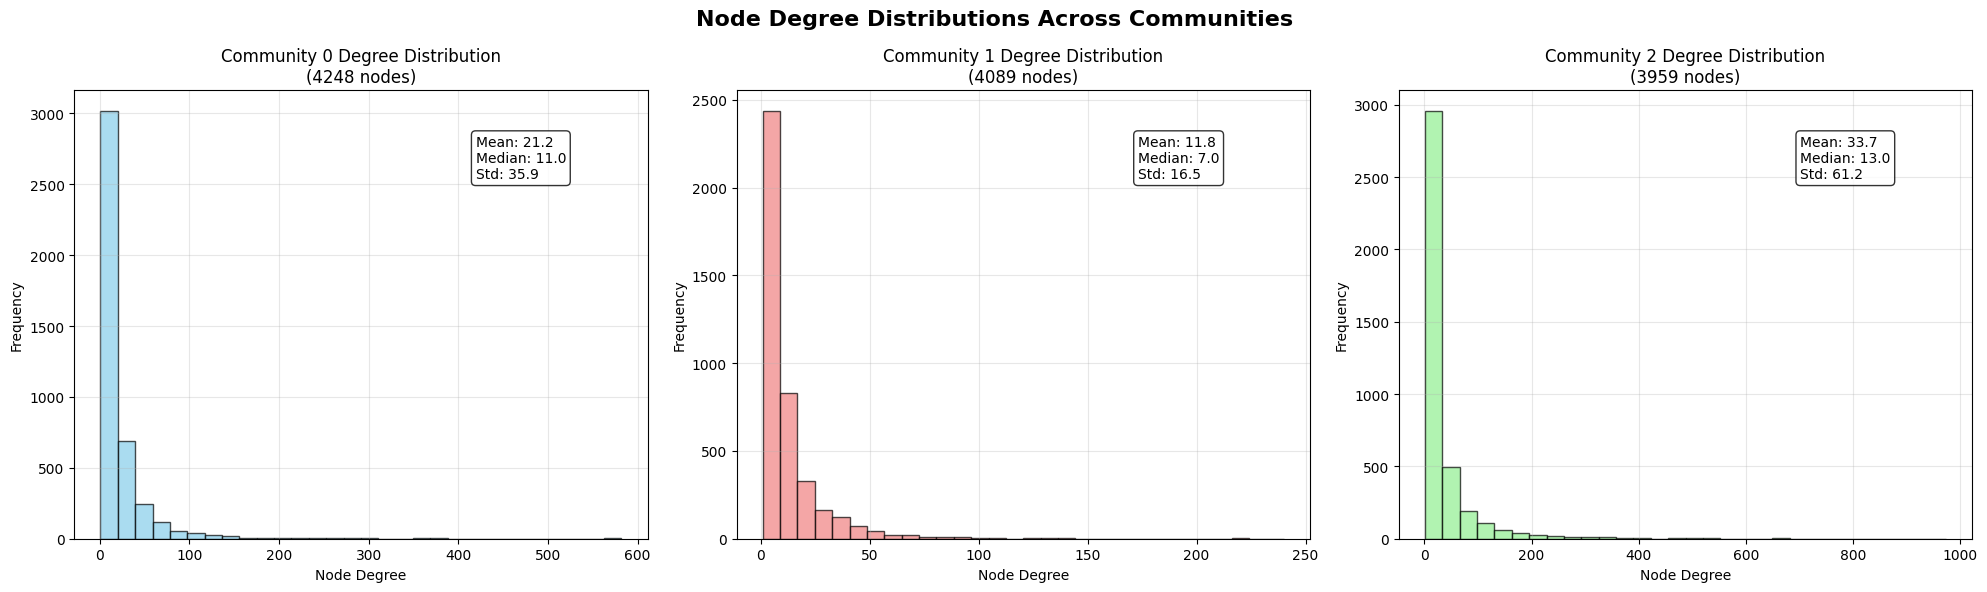

In [102]:
# Create comprehensive degree distribution plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Node Degree Distributions Across Communities', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Colors for each community
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Plot 1: Histograms for each community
for i, comm_id in enumerate(communities_of_interest):
    ax = axes_flat[i]
    degrees = community_degree_distributions[comm_id]
    
    # Create histogram
    ax.hist(degrees, bins=30, alpha=0.7, color=colors[i], edgecolor='black')
    ax.set_title(f'Community {comm_id} Degree Distribution\n({len(degrees)} nodes)')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f'Mean: {np.mean(degrees):.1f}\nMedian: {np.median(degrees):.1f}\nStd: {np.std(degrees):.1f}'
    ax.text(0.7, 0.9, stats_text, transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top')

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(figures_dir, 'node_degree_distributions_comprehensive_pt1.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

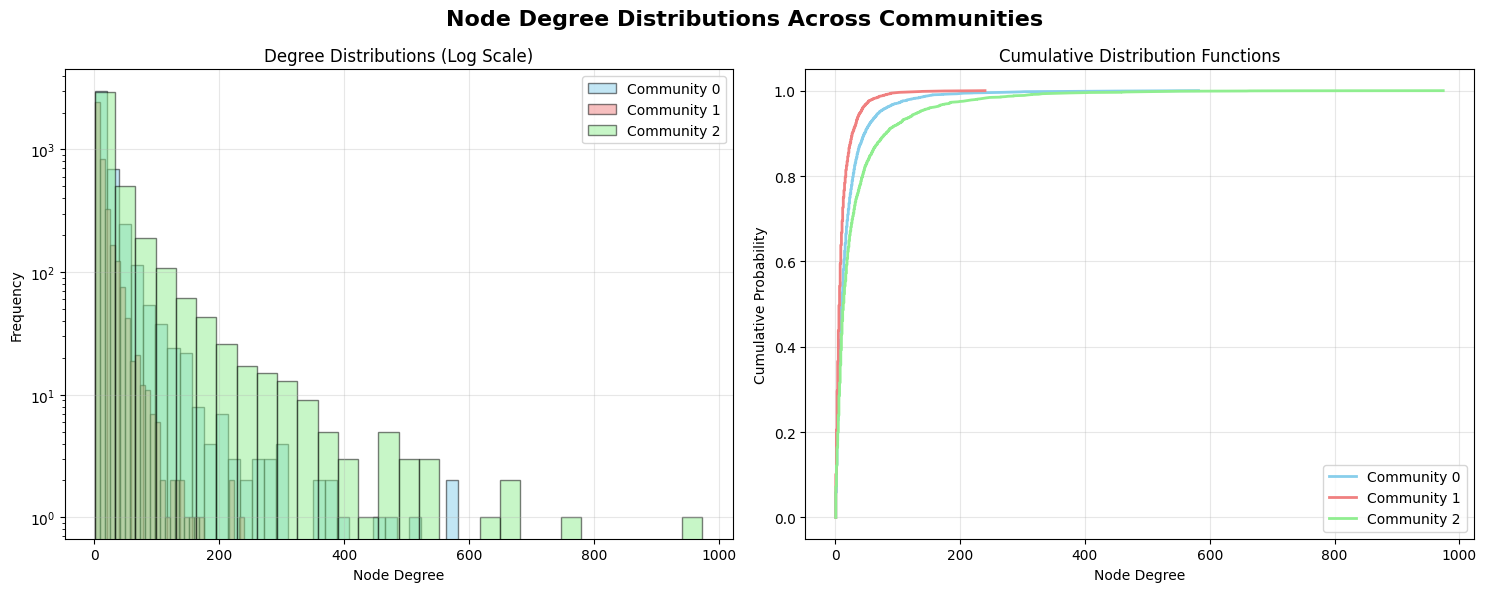

In [103]:
# Create comprehensive degree distribution plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Node Degree Distributions Across Communities', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Plot 5: Log-scale histograms (to better see heavy tails)
ax = axes_flat[0]
for i, comm_id in enumerate(communities_of_interest):
    degrees = community_degree_distributions[comm_id]
    ax.hist(degrees, bins=30, alpha=0.5, label=f'Community {comm_id}', 
            color=colors[i], edgecolor='black')

ax.set_title('Degree Distributions (Log Scale)')
ax.set_xlabel('Node Degree')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Cumulative distribution functions
ax = axes_flat[1]
for i, comm_id in enumerate(communities_of_interest):
    degrees = np.array(community_degree_distributions[comm_id])
    degrees_sorted = np.sort(degrees)
    cdf = np.arange(1, len(degrees_sorted) + 1) / len(degrees_sorted)
    
    ax.plot(degrees_sorted, cdf, label=f'Community {comm_id}', color=colors[i], linewidth=2)

ax.set_title('Cumulative Distribution Functions')
ax.set_xlabel('Node Degree')
ax.set_ylabel('Cumulative Probability')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(figures_dir, 'node_degree_distributions_comprehensive_pt2.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

In [104]:
# Statistical tests for degree distribution differences
print("Statistical Tests for Degree Distribution Differences")
print("=" * 60)

# Kolmogorov-Smirnov tests between communities
print("\nKolmogorov-Smirnov Tests (comparing distributions):")
for i in range(len(communities_of_interest)):
    for j in range(i+1, len(communities_of_interest)):
        comm1 = communities_of_interest[i]
        comm2 = communities_of_interest[j]
        
        degrees1 = community_degree_distributions[comm1]
        degrees2 = community_degree_distributions[comm2]
        
        # Perform KS test
        ks_stat, p_value = stats.ks_2samp(degrees1, degrees2)
        
        # Format result with significance indicator
        sig = ''
        if p_value < 0.05: sig = '*'
        if p_value < 0.01: sig = '**'
        if p_value < 0.001: sig = '***'
        
        print(f"  Communities {comm1} vs {comm2}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.4f} {sig}")

# Mann-Whitney U tests for median differences
print("\nMann-Whitney U Tests (comparing medians):")
for i in range(len(communities_of_interest)):
    for j in range(i+1, len(communities_of_interest)):
        comm1 = communities_of_interest[i]
        comm2 = communities_of_interest[j]
        
        degrees1 = community_degree_distributions[comm1]
        degrees2 = community_degree_distributions[comm2]
        
        # Perform Mann-Whitney U test
        u_stat, p_value = stats.mannwhitneyu(degrees1, degrees2, alternative='two-sided')
        
        # Format result with significance indicator
        sig = ''
        if p_value < 0.05: sig = '*'
        if p_value < 0.01: sig = '**'
        if p_value < 0.001: sig = '***'
        
        median1 = np.median(degrees1)
        median2 = np.median(degrees2)
        
        print(f"  Communities {comm1} vs {comm2}: medians = {median1:.1f} vs {median2:.1f}, p-value = {p_value:.4f} {sig}")

# Summary statistics table
print("\nSummary Statistics Table:")
print("-" * 80)
print(f"{'Community':<12} {'Nodes':<8} {'Mean':<8} {'Median':<8} {'Std':<8} {'Min':<6} {'Max':<6} {'Skewness':<10}")
print("-" * 80)

for comm_id in communities_of_interest:
    degrees = community_degree_distributions[comm_id]
    mean_deg = np.mean(degrees)
    median_deg = np.median(degrees)
    std_deg = np.std(degrees)
    min_deg = np.min(degrees)
    max_deg = np.max(degrees)
    skewness = stats.skew(degrees)
    
    print(f"{comm_id:<12} {len(degrees):<8} {mean_deg:<8.1f} {median_deg:<8.1f} {std_deg:<8.1f} {min_deg:<6.0f} {max_deg:<6.0f} {skewness:<10.2f}")

Statistical Tests for Degree Distribution Differences

Kolmogorov-Smirnov Tests (comparing distributions):
  Communities 0 vs 1: KS statistic = 0.1795, p-value = 0.0000 ***
  Communities 0 vs 2: KS statistic = 0.0969, p-value = 0.0000 ***
  Communities 1 vs 2: KS statistic = 0.2474, p-value = 0.0000 ***

Mann-Whitney U Tests (comparing medians):
  Communities 0 vs 1: medians = 11.0 vs 7.0, p-value = 0.0000 ***
  Communities 0 vs 2: medians = 11.0 vs 13.0, p-value = 0.0000 ***
  Communities 1 vs 2: medians = 7.0 vs 13.0, p-value = 0.0000 ***

Summary Statistics Table:
--------------------------------------------------------------------------------
Community    Nodes    Mean     Median   Std      Min    Max    Skewness  
--------------------------------------------------------------------------------
0            4248     21.2     11.0     35.9     1      582    6.44      
1            4089     11.8     7.0      16.5     1      240    4.62      
2            3959     33.7     13.0     61

In [105]:
# Analyze high-degree nodes (hubs) in each community
print("High-Degree Nodes (Hubs) Analysis")
print("=" * 50)

show_top = 20

for comm_id in communities_of_interest:
    degrees = community_degree_distributions[comm_id]
    community_nodes = list(top_communities[comm_id])
    
    # Find nodes with degrees in top 5%
    threshold_95 = np.percentile(degrees, 95)
    
    # Get high-degree nodes
    high_degree_nodes = []
    for node in community_nodes:
        if node in degree_dict and degree_dict[node] >= threshold_95:
            high_degree_nodes.append((node, degree_dict[node]))
    
    # Sort by degree (descending)
    high_degree_nodes.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nCommunity {comm_id} - Top High-Degree Nodes (95th percentile, threshold={threshold_95:.1f}):")
    print("-" * 60)
    
    for i, (node, degree) in enumerate(high_degree_nodes[:show_top]):  # Show top show_top
        # Determine if it's a left or right node
        node_type = 'Late-stage' if node in set_0 else 'Early-stage'
        print(f"  {i+1:2d}. {node:<40} (degree: {degree:3d}, type: {node_type})")
    
    if len(high_degree_nodes) > show_top:
        print(f"     ... and {len(high_degree_nodes) - show_top} more high-degree nodes")
    
    # Calculate percentage of high-degree nodes by type
    left_hubs = sum(1 for node, _ in high_degree_nodes if node in set_0)
    right_hubs = sum(1 for node, _ in high_degree_nodes if node in set_1)
    total_hubs = len(high_degree_nodes)
    
    if total_hubs > 0:
        left_pct = (left_hubs / total_hubs) * 100
        right_pct = (right_hubs / total_hubs) * 100
        print(f"     Hub distribution: {left_hubs} late-stage ({left_pct:.1f}%), {right_hubs} early-stage ({right_pct:.1f}%)")

High-Degree Nodes (Hubs) Analysis

Community 0 - Top High-Degree Nodes (95th percentile, threshold=71.0):
------------------------------------------------------------
   1. Techstars-seed                           (degree: 582, type: Early-stage)
   2. 500 Global-seed                          (degree: 564, type: Early-stage)
   3. Gaingels-series_b                        (degree: 509, type: Late-stage)
   4. Greycroft-series_a                       (degree: 483, type: Early-stage)
   5. Bossa Invest-series_b                    (degree: 450, type: Late-stage)
   6. New Enterprise Associates-series_b       (degree: 392, type: Late-stage)
   7. FJ Labs-series_b                         (degree: 385, type: Late-stage)
   8. Lerer Hippeau-series_a                   (degree: 375, type: Early-stage)
   9. RRE Ventures-series_a                    (degree: 356, type: Early-stage)
  10. 500 Global-series_a                      (degree: 353, type: Early-stage)
  11. Techstars-pre_seed             

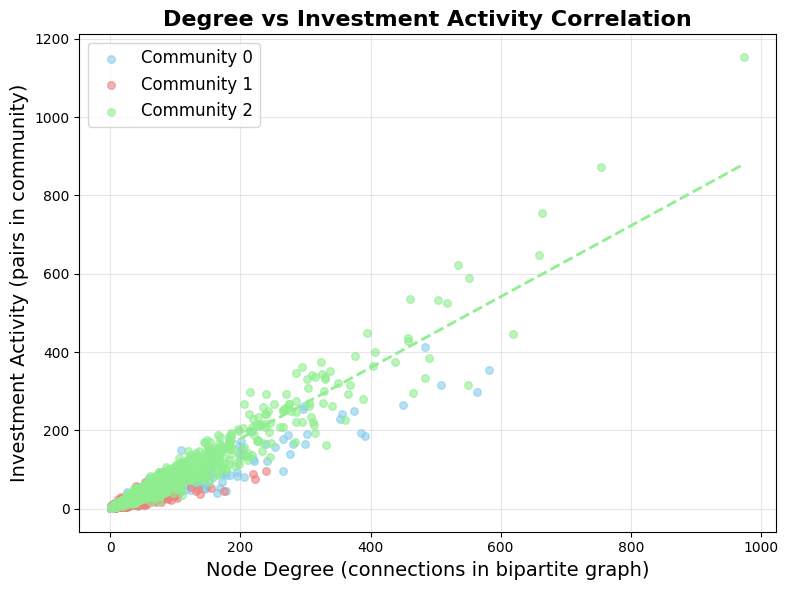

In [106]:
# Create a detailed degree analysis plot focused on the tails of the distribution
plt.figure(figsize=(8, 6))
plt.title('Degree vs Investment Activity Correlation', fontsize=16, fontweight='bold')

# For each community, plot degree vs some measure of activity
for i, comm_id in enumerate(communities_of_interest):
    community_nodes = list(top_communities[comm_id])
    community_data_subset = community_data[comm_id]
    
    # Count investment pairs for each investor
    investor_activity = {}
    for _, row in community_data_subset.iterrows():
        left_inv = row['investor_name_left']
        right_inv = row['investor_name_right']
        
        investor_activity[left_inv] = investor_activity.get(left_inv, 0) + 1
        investor_activity[right_inv] = investor_activity.get(right_inv, 0) + 1
    
    # Create scatter plot of degree vs activity
    degrees_plot = []
    activities_plot = []
    
    for node in community_nodes:
        if node in degree_dict and node in investor_activity:
            degrees_plot.append(degree_dict[node])
            activities_plot.append(investor_activity[node])
    
    if degrees_plot and activities_plot:
        plt.scatter(degrees_plot, activities_plot, alpha=0.6, 
                  label=f'Community {comm_id}', color=colors[i], s=30)

plt.xlabel('Node Degree (connections in bipartite graph)', fontsize=14)
plt.ylabel('Investment Activity (pairs in community)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add trendlines for visual aid
for i, comm_id in enumerate(communities_of_interest):
    community_nodes = list(top_communities[comm_id])
    community_data_subset = community_data[comm_id]
    
    # Get degrees and activities again for trendline
    degrees_plot = []
    activities_plot = []
    
    for node in community_nodes:
        if node in degree_dict and node in investor_activity:
            degrees_plot.append(degree_dict[node])
            activities_plot.append(investor_activity[node])
    
    if degrees_plot and activities_plot:
        # Calculate trendline
        z = np.polyfit(degrees_plot, activities_plot, 1)
        p = np.poly1d(z)
        
        # Add trendline to plot
        x_trend = np.linspace(min(degrees_plot), max(degrees_plot), 100)
        plt.plot(x_trend, p(x_trend), '--', color=colors[i], linewidth=2)

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(figures_dir, 'degree_vs_investment_corr.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

#### Nestedness Evolution

#### Nestedness Evolution for Community 2

Analysis of nestedness evolution over time for community 2 using cumulative 5-year windows and curve ball null models.

In [107]:
# Focus on community 2 for temporal nestedness analysis
target_community = 2
community_2_data = community_data[target_community].copy()

print(f"Community {target_community} temporal analysis")
print(f"Total investment pairs: {len(community_2_data)}")
print(f"Year range: {community_2_data['year'].min()} to {community_2_data['year'].max()}")

# Show year distribution
year_counts = community_2_data['year'].value_counts().sort_index()
print(f"\nInvestment pairs per year:")
print(year_counts)

Community 2 temporal analysis
Total investment pairs: 55863
Year range: 1999 to 2025

Investment pairs per year:
year
1999        5
2000       13
2001        8
2002       13
2003       13
2004       21
2005       36
2006       47
2007       90
2008       81
2009       82
2010      165
2011      342
2012      253
2013      531
2014     1031
2015     2020
2016     3033
2017     3304
2018     5434
2019     7706
2020     7499
2021    14618
2022     6047
2023     1446
2024     1876
2025      149
Name: count, dtype: int64


In [108]:
# Initialize storage for community 2 time series nestedness analysis
community_2_nestedness_ts = []
cumulative_window = 21
min_edges_threshold = 10

print(f"Computing nestedness evolution for Community {target_community} ({cumulative_window}-year cumulative windows)...")
print("=" * 70)

# Get community 2 nodes from the bipartite graph
community_2_nodes = set(top_communities[target_community])

if CALCULATE_COMMUNITY_2_TS_NESTEDNESS or not os.path.exists(community_2_ts_nestedness_file):
    # Loop through each year and calculate metrics using cumulative windows
    for year in range(min_year, max_year + 1):
        # Get cumulative data for the current window
        window_data = community_2_data[
            (community_2_data['year'] <= year) & 
            (community_2_data['year'] >= year - cumulative_window)
        ]
        
        if len(window_data) < min_edges_threshold:
            print(f"Year {year}: Skipping (only {len(window_data)} investment pairs)")
            continue
        
        try:
            # Get active investors for this time window from the investment pairs
            active_left_investors = set(window_data['investor_name_left'].unique())
            active_right_investors = set(window_data['investor_name_right'].unique())
            
            # Filter to only include investors that are in community 2 AND active in this window
            window_community_left = [node for node in community_2_nodes if node in set_0 and node in active_left_investors]
            window_community_right = [node for node in community_2_nodes if node in set_1 and node in active_right_investors]
            
            # Skip if either set is empty
            if len(window_community_left) == 0 or len(window_community_right) == 0:
                print(f"Year {year}: Skipping (empty bipartite set in time window)")
                continue
            
            # Create adjacency matrix for this community and time window
            left_indices_window = {node: i for i, node in enumerate(window_community_left)}
            right_indices_window = {node: j for j, node in enumerate(window_community_right)}
            
            # Initialize adjacency matrix
            adjacency_matrix_window = np.zeros((len(window_community_left), len(window_community_right)))
            
            # Fill matrix with connections from the bipartite graph
            for left_node in window_community_left:
                for right_node in window_community_right:
                    if bipartite_graph.has_edge(left_node, right_node):
                        left_idx = left_indices_window[left_node]
                        right_idx = right_indices_window[right_node]
                        adjacency_matrix_window[left_idx, right_idx] = 1
            
            # Calculate observed nestedness
            calculator_window = NestednessCalculator(adjacency_matrix_window)
            nestedness_score_window = calculator_window.nodf(adjacency_matrix_window)
            
            # Basic network metrics
            num_nodes = len(window_community_left) + len(window_community_right)
            num_left_vcs = len(window_community_left)
            num_right_vcs = len(window_community_right)
            num_edges = int(adjacency_matrix_window.sum())
            density = adjacency_matrix_window.mean()
            connectance = num_edges / (len(window_community_left) * len(window_community_right))
            
            # Generate null models using curve ball algorithm
            null_nestedness_scores_window = []
            n_iterations = 100  # Reduced for computational efficiency in time series
            n_iterations_cv = 10000
            
            print(f"Year {year}: Generating {n_iterations} null models...")
            for i in tqdm(range(n_iterations), desc=f"Year {year}", leave=False):
                try:
                    # Generate null model matrix
                    M = adjacency_matrix_window.copy()
                    r_hp = find_presences(M)
                    RM = curve_ball(M, r_hp, n_iterations_cv)
                    
                    null_matrix = RM.astype(adjacency_matrix_window.dtype)
                    
                    # Calculate nestedness of null model
                    calculator_null = NestednessCalculator(null_matrix)
                    null_score = calculator_null.nodf(null_matrix)
                    null_nestedness_scores_window.append(null_score)
                    
                except Exception as e:
                    print(f"    Error in null model iteration {i}: {e}")
                    continue
            
            # Calculate statistical significance
            if len(null_nestedness_scores_window) > 0:
                null_scores_array = np.array(null_nestedness_scores_window)
                mean_null = np.mean(null_scores_array)
                std_null = np.std(null_scores_array)
                
                if std_null > 0:
                    z_score = (nestedness_score_window - mean_null) / std_null
                else:
                    z_score = np.nan
                
                # Corrected p-value calculation for empirical distributions
                # Adding 1 to both numerator and denominator to avoid p-values of exactly 0
                # This is the standard approach for empirical p-values with discrete distributions
                p_value = (np.sum(null_scores_array >= nestedness_score_window) + 1) / (len(null_scores_array) + 1)
                significance = 'significant' if p_value < 0.05 else 'not_significant'
            else:
                mean_null = std_null = z_score = p_value = np.nan
                significance = 'null_model_failed'
                null_scores_array = np.array([])
            
            # Store results
            community_2_nestedness_ts.append({
                'community_id': 2,
                'year': year,
                'window_start': year - cumulative_window,
                'window_end': year,
                'num_pairs': len(window_data),
                'num_nodes': num_nodes,
                'left_nodes': num_left_vcs,
                'right_nodes': num_right_vcs,
                'num_edges': num_edges,
                'density': density,
                'connectance': connectance,
                'observed_nestedness': nestedness_score_window,
                'null_mean': mean_null,
                'null_std': std_null,
                'z_score': z_score,
                'p_value': p_value,
                'significance': significance,
                'null_scores': null_scores_array.tolist() if len(null_scores_array) > 0 else []
            })
            
            print(f"Year {year}: {num_nodes} nodes ({num_left_vcs} left, {num_right_vcs} right), "
                f"{num_edges} edges, Connectance: {connectance:.4f}, "
                f"Nestedness: {nestedness_score_window:.4f}, "
                f"Z-score: {z_score:.4f}, P-value: {p_value:.4f} ({significance})")
            
        except Exception as e:
            print(f"Year {year}: Error - {str(e)}")
            continue

    print(f"\nSuccessfully analyzed {len(community_2_nestedness_ts)} years for Community {target_community}")
    community_2_nestedness_df = pd.DataFrame(community_2_nestedness_ts)
    community_2_nestedness_df.to_csv(community_2_ts_nestedness_file, compression='gzip')
    print(f"Saved nestedness results to {community_2_ts_nestedness_file}")
else:
    community_2_nestedness_df = pd.read_csv(community_2_ts_nestedness_file, compression='gzip')    
    # Apply the parsing function to the null_scores column
    community_2_nestedness_df['null_scores'] = community_2_nestedness_df['null_scores'].apply(parse_null_scores)
    print(f"Got nestedness results from {community_2_ts_nestedness_file}")
    
community_2_nestedness_df['community_size'] = community_2_nestedness_df['num_nodes']

Computing nestedness evolution for Community 2 (21-year cumulative windows)...
Got nestedness results from ../data/processed/us/community_2_ts_nestedness_file.csv.gz


In [109]:
print(f"Community {target_community} Nestedness Evolution Summary:")
print("=" * 60)
print(f"Years analyzed: {len(community_2_nestedness_df)}")
print(f"Period: {community_2_nestedness_df['year'].min()} to {community_2_nestedness_df['year'].max()}")
print(f"Significant periods (p < 0.05): {len(community_2_nestedness_df[community_2_nestedness_df['significance'] == 'significant'])}")

# Display summary statistics
print("\nNestedness Statistics Over Time:")
valid_results = community_2_nestedness_df[community_2_nestedness_df['significance'].isin(['significant', 'not_significant'])]
if len(valid_results) > 0:
    print(f"Mean observed nestedness: {valid_results['observed_nestedness'].mean():.4f} ± {valid_results['observed_nestedness'].std():.4f}")
    print(f"Mean null nestedness: {valid_results['null_mean'].mean():.4f} ± {valid_results['null_mean'].std():.4f}")
    print(f"Mean Z-score: {valid_results['z_score'].mean():.4f} ± {valid_results['z_score'].std():.4f}")
    print(f"Mean connectance: {valid_results['connectance'].mean():.4f} ± {valid_results['connectance'].std():.4f}")

print("\nDetailed Year-by-Year Results:")
print(community_2_nestedness_df[['year', 'num_pairs', 'num_nodes', 'connectance', 'observed_nestedness', 'z_score', 'p_value', 'significance']].round(4))

Community 2 Nestedness Evolution Summary:
Years analyzed: 18
Period: 2007 to 2024
Significant periods (p < 0.05): 6

Nestedness Statistics Over Time:
Mean observed nestedness: 0.2130 ± 0.1106
Mean null nestedness: 0.2166 ± 0.1163
Mean Z-score: 0.2701 ± 2.8646
Mean connectance: 0.0758 ± 0.0596

Detailed Year-by-Year Results:
    year  num_pairs  num_nodes  connectance  observed_nestedness  z_score  \
0   2007        246        137       0.1952               0.3761  -1.4808   
1   2008        327        177       0.1626               0.3597  -1.3476   
2   2009        409        206       0.1521               0.3521  -0.4236   
3   2010        574        258       0.1444               0.3519  -0.9481   
4   2011        916        345       0.1249               0.3325  -2.0740   
5   2012       1169        397       0.1135               0.3117  -3.1743   
6   2013       1700        497       0.0989               0.2758  -3.6070   
7   2014       2731        695       0.0783               

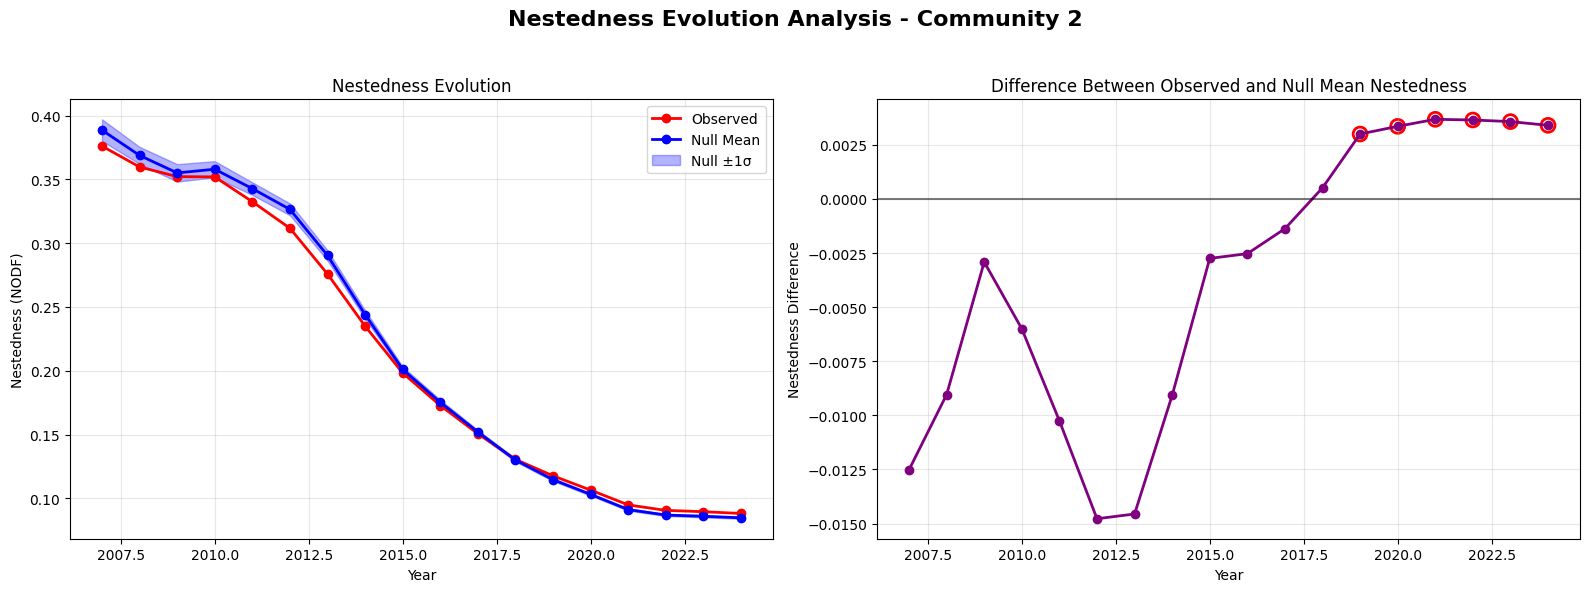

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Nestedness Evolution Analysis - Community {target_community}', 
                          fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot 1: Observed vs Null Nestedness over time (top left)
ax = axes[0]
ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['observed_nestedness'], 
                'o-', linewidth=2, markersize=6, color='red', label='Observed')
ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['null_mean'], 
                'o-', linewidth=2, markersize=6, color='blue', label='Null Mean')
ax.fill_between(community_2_nestedness_df['year'], 
                                community_2_nestedness_df['null_mean'] - community_2_nestedness_df['null_std'],
                                community_2_nestedness_df['null_mean'] + community_2_nestedness_df['null_std'],
                                alpha=0.3, color='blue', label='Null ±1σ')
ax.set_title('Nestedness Evolution')
ax.set_xlabel('Year')
ax.set_ylabel('Nestedness (NODF)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Difference between observed and null mean nestedness (bottom right)
ax = axes[1]
nestedness_diff = community_2_nestedness_df['observed_nestedness'] - community_2_nestedness_df['null_mean']
ax.plot(community_2_nestedness_df['year'], nestedness_diff, 
                'o-', linewidth=2, markersize=6, color='purple')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax.set_title('Difference Between Observed and Null Mean Nestedness')
ax.set_xlabel('Year')
ax.set_ylabel('Nestedness Difference')
ax.grid(True, alpha=0.3)

# Highlight significant differences
for i, (year, diff, sig) in enumerate(zip(community_2_nestedness_df['year'], 
                                                                                 nestedness_diff, 
                                                                                 community_2_nestedness_df['significance'])):
        if sig == 'significant':
                ax.scatter(year, diff, s=100, edgecolor='red', facecolor='none', linewidth=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig(os.path.join(figures_dir, f'nestedness_evolution_community_{target_community}_pt1.png'), 
                        dpi=300, bbox_inches='tight')
plt.show()

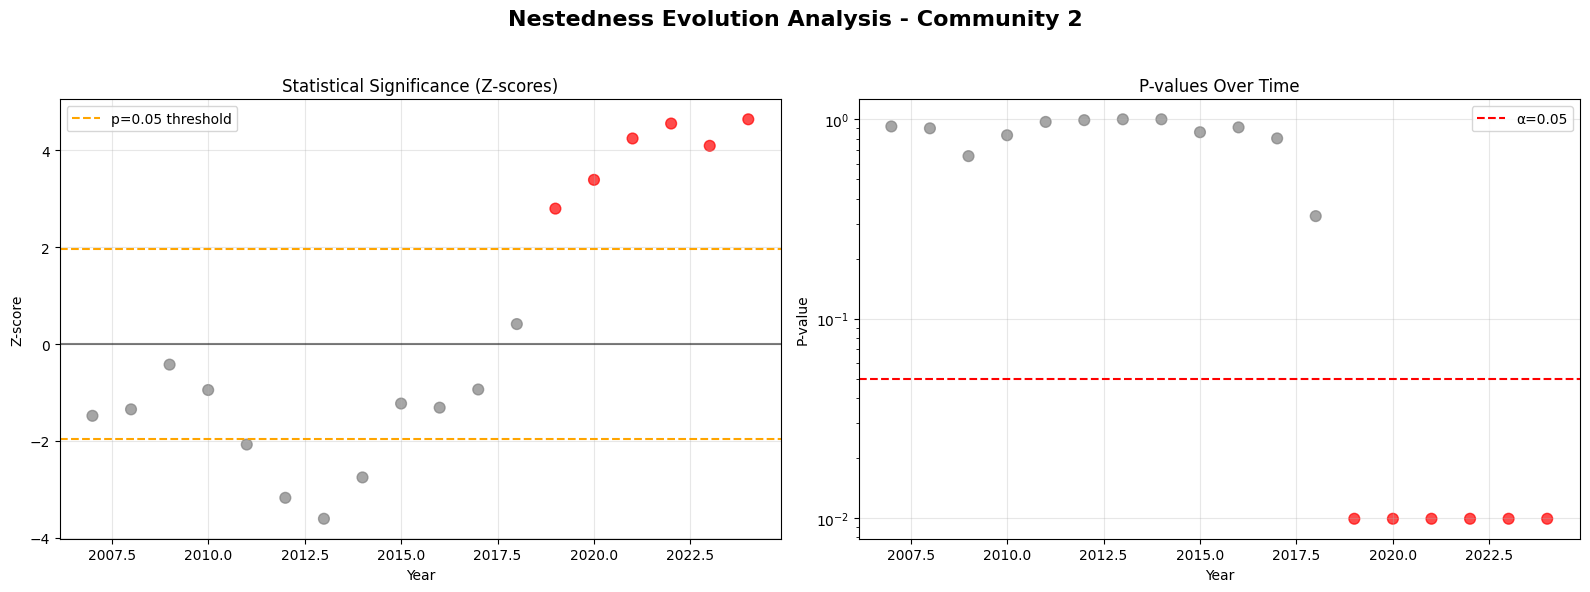

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Nestedness Evolution Analysis - Community {target_community}', 
                          fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot 2: Z-scores over time (top right)
ax = axes[0]
colors_sig = ['red' if sig == 'significant' else 'gray' for sig in community_2_nestedness_df['significance']]
ax.scatter(community_2_nestedness_df['year'], community_2_nestedness_df['z_score'], 
                  c=colors_sig, s=60, alpha=0.7)
ax.axhline(y=1.96, color='orange', linestyle='--', label='p=0.05 threshold')
ax.axhline(y=-1.96, color='orange', linestyle='--')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax.set_title('Statistical Significance (Z-scores)')
ax.set_xlabel('Year')
ax.set_ylabel('Z-score')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: P-values over time (bottom left)
ax = axes[1]
ax.scatter(community_2_nestedness_df['year'], community_2_nestedness_df['p_value'], 
                  c=colors_sig, s=60, alpha=0.7)
ax.axhline(y=0.05, color='red', linestyle='--', label='α=0.05')
ax.set_title('P-values Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('P-value')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig(os.path.join(figures_dir, f'nestedness_evolution_community_{target_community}_pt2.png'), 
                        dpi=300, bbox_inches='tight')
plt.show()

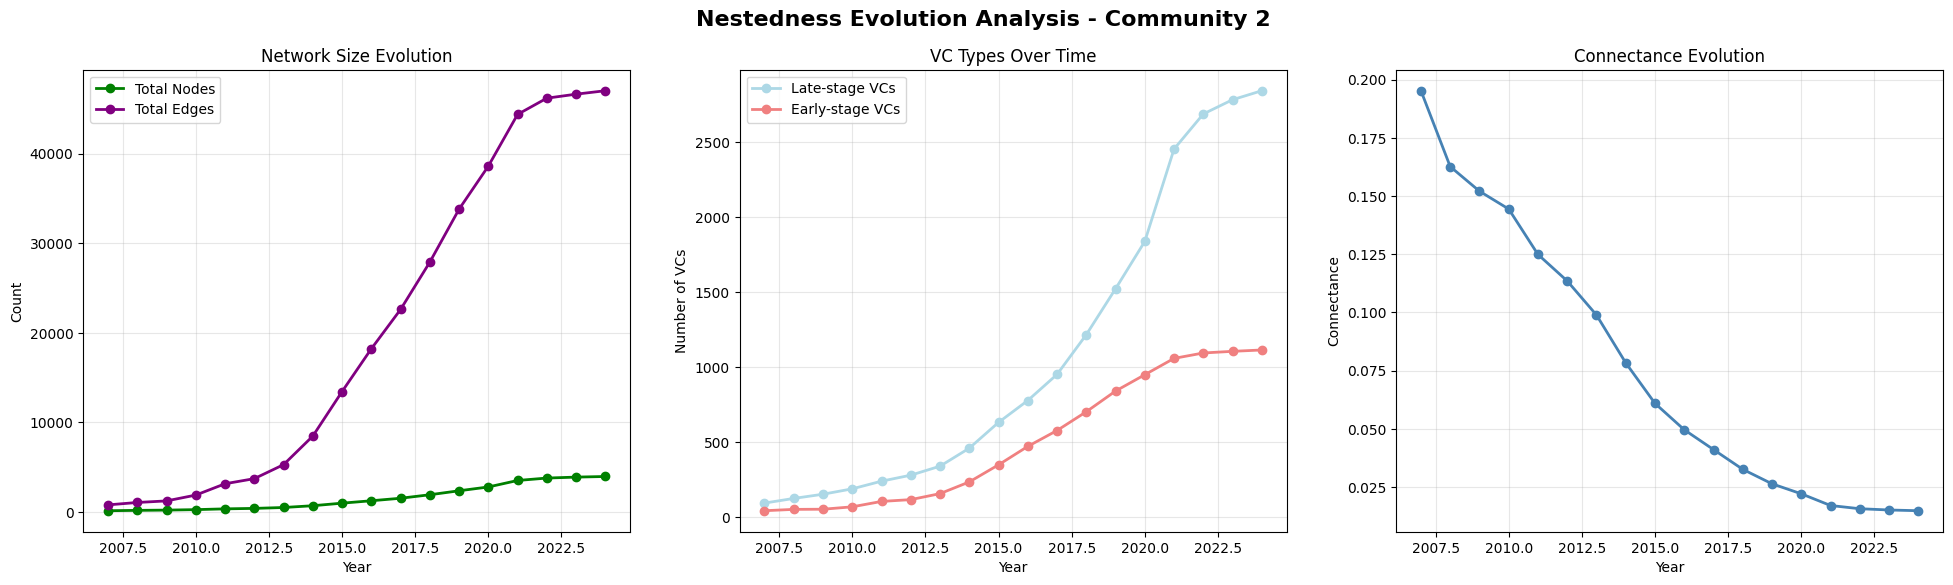

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
fig.suptitle(f'Nestedness Evolution Analysis - Community {target_community}', 
              fontsize=16, fontweight='bold')

# Plot 3: Network size evolution
ax = axes[0]
ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['num_nodes'], 
        'o-', linewidth=2, markersize=6, color='green', label='Total Nodes')
ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['num_edges'], 
        'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
ax.set_title('Network Size Evolution')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Connectance evolution
ax = axes[2]
ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['connectance'], 
        'o-', linewidth=2, markersize=6, color='steelblue')
ax.set_title('Connectance Evolution')
ax.set_xlabel('Year')
ax.set_ylabel('Connectance')
ax.grid(True, alpha=0.3)

# Plot 5: Left vs Right VCs
ax = axes[1]
ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['left_nodes'], 
        'o-', linewidth=2, markersize=6, color='lightblue', label='Late-stage VCs')
ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['right_nodes'], 
        'o-', linewidth=2, markersize=6, color='lightcoral', label='Early-stage VCs')
ax.set_title('VC Types Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Number of VCs')
ax.legend()
ax.grid(True, alpha=0.3)

# Save figure
plt.savefig(os.path.join(figures_dir, f'nestedness_evolution_community_{target_community}_pt3.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

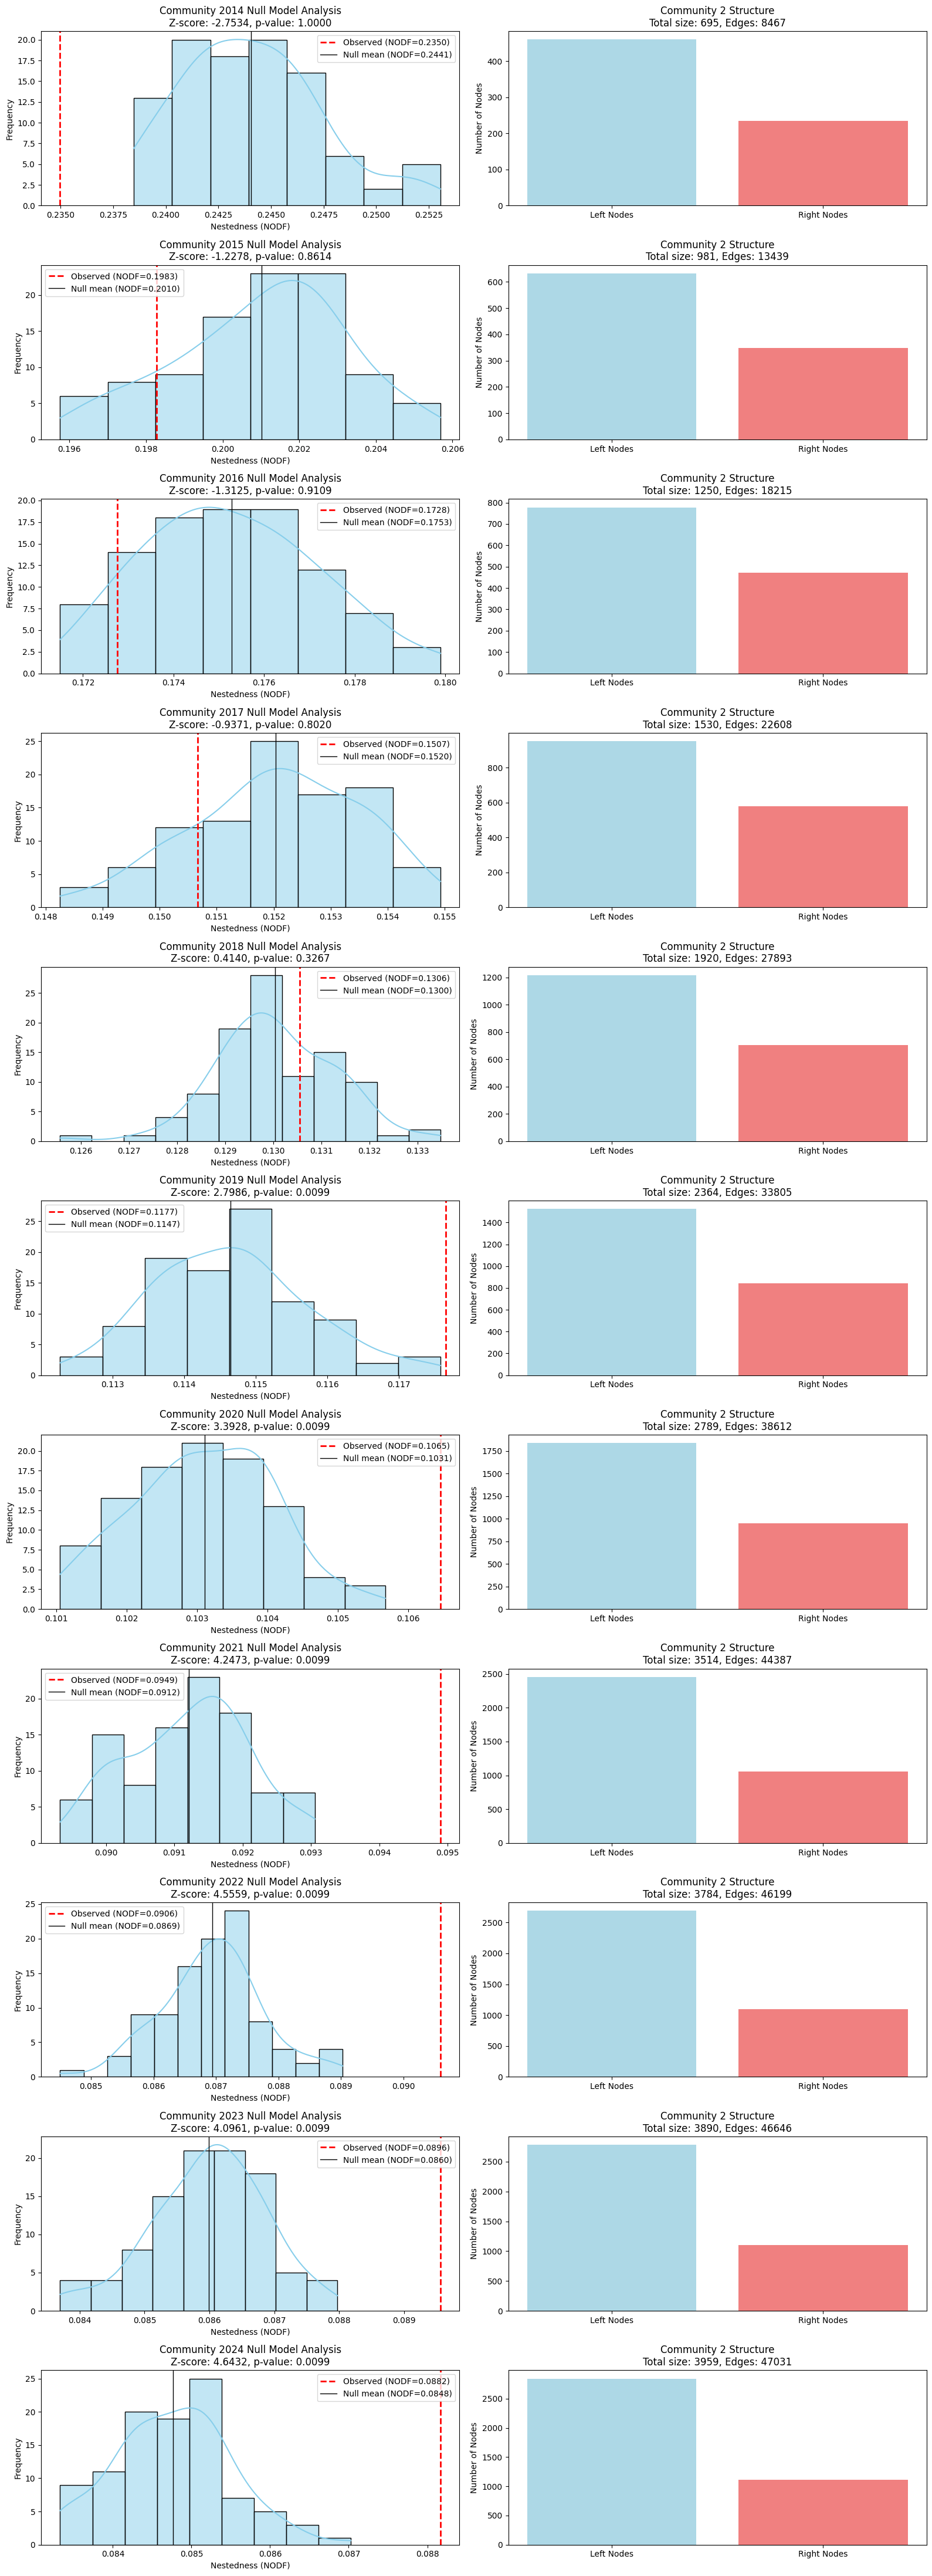

In [113]:
significant_periods = community_2_nestedness_df[community_2_nestedness_df['year'] >= 2014]
plot_communities_null_models_and_structure(significant_periods, figures_dir, f'significant_periods_community_{target_community}.png', 'year')